## Import libraries

In [1]:
# Data analysis
import pandas as pd
import numpy as np
import numba as nb
from numba import jit, prange

# Survival analysis
from lifelines.plotting import plot_lifetimes
from lifelines import KaplanMeierFitter, NelsonAalenFitter, CoxPHFitter


# ML
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.neighbors import KDTree, NearestNeighbors
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import (
    RandomForestClassifier,
    ExtraTreesClassifier,
    IsolationForest,
    BaggingClassifier,
    VotingClassifier,
)
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    StratifiedKFold,
    KFold,
    cross_validate,
)
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    roc_auc_score,
    classification_report,
    precision_recall_fscore_support,
    precision_score,
    recall_score,
    make_scorer,
)
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import (
    LabelEncoder,
    StandardScaler,
    MinMaxScaler,
    RobustScaler,
    OneHotEncoder,
)
from sklearn.cluster import MiniBatchKMeans, KMeans, AgglomerativeClustering
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy import sparse
import category_encoders as ce

from embedder2 import preprocessing
from embedder2.regression import Embedder
from keras.callbacks import EarlyStopping, ModelCheckpoint

# from keras.models import Sequential
# from keras.layers import Dense
# from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers import Dense, Dropout, Embedding, Flatten, Input, merge, concatenate
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import PReLU
from keras.models import Model, Sequential
from keras import backend as K
import tensorflow as tf

import datawig

import catboost as cb
import xgboost as xgb
from xgboost import plot_importance
from imblearn.over_sampling import SMOTE
import optuna

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick

# User-defined modules
from utils.feature_engineer import *
from utils.preprocessing import *

# Miscs
import math
from itertools import combinations
from datetime import datetime
from tqdm import tqdm, tqdm_notebook
import math
import gc
import random
import os, warnings, sys
from pyvi import ViTokenizer
import glob
from collections import Counter
from string import punctuation
from underthesea import word_tokenize

warnings.simplefilter(action="ignore", category=FutureWarning)
# warnings.simplefilter(action='ignore', category=ConvergenceWarning)
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("display.width", 1000)

warnings.filterwarnings("ignore")
%load_ext autoreload
%load_ext lab_black
%aimport utils
%autoreload 2

Using TensorFlow backend.
/usr/local/lib64/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib64/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.bagging module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib64/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.base module is  deprecated in version 0.22 an

## Utils

In [2]:
def fillna_numeric(df, columns):
    X = df.copy()
    for c in columns:
        if X[c].isna().mean() > 0:
            X[c] = X[c].fillna(X[c].median())
    return X

In [3]:
def find_optimal_clusters(data, max_k):
    iters = range(2, max_k + 1, 2)

    sse = []
    for k in iters:
        sse.append(
            KMeans(n_clusters=k, init="k-means++", n_jobs=-1, random_state=2020)
            .fit(data)
            .inertia_
        )
        print("Fit {} clusters".format(k))

    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker="o")
    ax.set_xlabel("Cluster Centers")
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel("SSE")
    ax.set_title("SSE by Cluster Center Plot")


# find_optimal_clusters(text, 20)

In [4]:
@nb.jit(nopython=True, fastmath=True)
def nb_mean(x):
    s = 0
    for i in range(x.shape[0]):
        s += x[i]
    return s / x.shape[0]

In [5]:
# Euclidean distance between rows
def fsi_numpy(arr, item_id):
    tmp_arr = arr - arr[item_id]
    tmp_ser = np.sum(np.square(tmp_arr), axis=1)
    return tmp_ser

In [52]:
def aggregate_features(
    df, group_cols, agg_cols, transformations=["mean", "median", "min", "max", "std"]
):
    """Create aggregation features: Require a `group` column and a column to do aggregations on.
    
    Args:
        df (DataFrame): Input dataframe
        group_col (list): columns to group 
        agg_col (list): columns to do aggregations
        transformations (list, optional): List of aggregate functions to apply
        Returns
    
    Returns:
        DataFrame: Output dataframe with added features
        list: list of added features
    """
    X = df.copy()
    agg_ft = []
    for c1 in group_cols:
        for c2 in agg_cols:
            for f in transformations:
                X[f"agg_{c1}_{c2}_{f}"] = X.groupby(c1)[c2].transform(f).fillna(0)
                agg_ft.append(f"agg_{c1}_{c2}_{f}")
    return X, agg_ft


def interact_features(df, feature_set):
    """Create interaction features
    
    Args:
        df (DataFrame): Input dataframe
        feature_set1 (list): List of features to get interactions
    
    Returns:
        DataFrame: Output dataframe with added features
        list: list of added features
    """
    X = df.copy()
    inter_cols = []
    for (f1, f2) in combinations(feature_set, 2):
        X[f"inter_{f1}_{f2}_sum"] = X[f1] + X[f2]
        X[f"inter_{f1}_{f2}_sub"] = X[f1] - X[f2]
        X[f"inter_{f1}_{f2}_mul"] = X[f1] * X[f2]
        X[f"inter_{f1}_{f2}_div"] = (X[f1] / X[f2]).fillna(0)
        X[f"inter_{f2}_{f1}_div"] = (X[f2] / X[f1]).fillna(0)
        inter_cols.extend(
            [
                f"inter_{f1}_{f2}_sum",
                f"inter_{f1}_{f2}_sub",
                f"inter_{f1}_{f2}_mul",
                f"inter_{f1}_{f2}_div",
                f"inter_{f2}_{f1}_div",
            ]
        )
    return X, inter_cols


def cat_count_features(df, cat_cols):
    """Get value counts of categorical variables each row
    
    Args:
        df (DataFrame): Description
        cat_cols (TYPE): Description
    
    Returns:
        DataFrame: Output dataframe with added features
        list: list of added features
    """
    X = df.copy()
    cat_count_cols = []
    for c in cat_cols:
        d = X[c].value_counts().to_dict()
        X[f"{c}_count"] = X[c].apply(lambda x: d.get(x, 0))
        cat_count_cols.append(f"{c}_count")
    return X, cat_count_cols

In [7]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        tmin, tsec = divmod((datetime.now() - start_time).total_seconds(), 60)
        print("\n Time taken: %i minutes and %s seconds." % (tmin, round(tsec, 2)))

In [8]:
def get_embedding_df(embed_matrix, entity_list, colname="artist_id", prefix="a"):
    df1 = pd.DataFrame(entity_list, columns=[colname])
    df2 = pd.DataFrame(
        embed_matrix,
        columns=["{}_{}".format(prefix, i) for i in range(embed_matrix.shape[1])],
    )
    return pd.concat((df1, df2), axis=1).fillna("undefined")

In [9]:
def gini(actual, pred, **kwargs):
    assert len(actual) == len(pred)
    all = np.asarray(np.c_[actual, pred, np.arange(len(actual))], dtype=np.float)
    all = all[np.lexsort((all[:, 2], -1 * all[:, 1]))]
    totalLosses = all[:, 0].sum()
    giniSum = all[:, 0].cumsum().sum() / totalLosses

    giniSum -= (len(actual) + 1) / 2.0
    return giniSum / len(actual)

In [10]:
# Compute gini
# from CPMP's kernel https://www.kaggle.com/cpmpml/extremely-fast-gini-computation
@jit
def eval_gini(y_true, y_prob):
    y_true = np.array(y_true)
    y_true = y_true[np.argsort(y_prob)]
    ntrue = 0
    gini = 0
    delta = 0
    n = len(y_true)
    for i in range(n - 1, -1, -1):
        y_i = y_true[i]
        ntrue += y_i
        gini += y_i * delta
        delta += 1 - y_i
    gini = 1 - 2 * gini / (ntrue * (n - ntrue))
    return gini

In [11]:
# Funcitons from olivier's kernel
# https://www.kaggle.com/ogrellier/xgb-classifier-upsampling-lb-0-283
def add_noise(series, noise_level):
    return series * (1 + noise_level * np.random.randn(len(series)))

In [12]:
# Funcitons from olivier's kernel
# https://www.kaggle.com/ogrellier/xgb-classifier-upsampling-lb-0-283
def gini_xgb(preds, dtrain):
    labels = dtrain.get_label()
    gini_score = -gini(labels, preds)
    return [("gini", gini_score)]

In [13]:
def mean_encoding(X, y, X_test, cols, label="label"):
    skf = StratifiedKFold(5, shuffle=True, random_state=123)
    df_tr = pd.concat([X, y], axis=1)
    new_df_tr = df_tr.copy()
    # CV loop to avoid overfitting
    for tr_ind, val_ind in skf.split(X, y):
        X_tr, X_val = df_tr.iloc[tr_ind], df_tr.iloc[val_ind]
        for col in cols:
            means = X_val[col].map(X_tr.groupby(col)[label].mean())
            #             X_val[col + "_mean_target"] = means
            new_df_tr.loc[val_ind, col + "_mean_target"] = means
    #         new_df_tr.iloc[val_ind] = X_val
    prior = df_tr[label].mean()  # global mean
    new_df_tr = new_df_tr.fillna(prior)  # fill NANs with global mean

    X_new = new_df_tr.drop(columns=[label])
    X_test_new = X_test.copy()
    for col in cols:
        mean_mapping = pd.Series(
            X_new[col + "_mean_target"].values, index=X_new[col]
        ).to_dict()
        X_test_new[col + "_mean_target"] = X_test_new[col].map(mean_mapping)
    return X_new, X_test_new

In [14]:
# Funcitons from olivier's kernel
# https://www.kaggle.com/ogrellier/xgb-classifier-upsampling-lb-0-283
def target_encode(
    trn_series=None,  # Revised to encode validation series
    val_series=None,
    tst_series=None,
    target=None,
    min_samples_leaf=1,
    smoothing=1,
    noise_level=0,
):
    """
    Smoothing is computed like in the following paper by Daniele Micci-Barreca
    https://kaggle2.blob.core.windows.net/forum-message-attachments/225952/7441/high%20cardinality%20categoricals.pdf
    trn_series : training categorical feature as a pd.Series
    tst_series : test categorical feature as a pd.Series
    target : target data as a pd.Series
    min_samples_leaf (int) : minimum samples to take category average into account
    smoothing (int) : smoothing effect to balance categorical average vs prior
    """
    #     print(trn_series.name)
    #     print(target.name)
    assert len(trn_series) == len(target)
    if tst_series:
        assert trn_series.name == tst_series.name
    temp = pd.concat([trn_series, target], axis=1)
    # Compute target mean
    averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])
    # Compute smoothing
    smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))
    # Apply average function to all target data
    prior = target.mean()
    # The bigger the count the less full_avg is taken into account
    averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
    averages.drop(["mean", "count"], axis=1, inplace=True)
    #     print(averages.head())
    # Apply averages to trn and tst series
    #     print(trn_series.to_frame(trn_series.name))
    #     print(averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}))
    ft_trn_series = (
        pd.merge(
            trn_series.to_frame(trn_series.name),
            averages.reset_index().rename(
                columns={"index": target.name, target.name: "average"}
            ),
            on=trn_series.name,
            how="left",
        )["average"]
        .rename(trn_series.name + "_mean")
        .fillna(prior)
    )
    # pd.merge does not keep the index so restore it
    ft_trn_series.index = trn_series.index
    ft_val_series = (
        pd.merge(
            val_series.to_frame(val_series.name),
            averages.reset_index().rename(
                columns={"index": target.name, target.name: "average"}
            ),
            on=val_series.name,
            how="left",
        )["average"]
        .rename(trn_series.name + "_mean")
        .fillna(prior)
    )
    # pd.merge does not keep the index so restore it
    ft_val_series.index = val_series.index
    if tst_series:
        print(tst_series.to_frame(tst_series.name))
        print(
            averages.reset_index().rename(
                columns={"index": target.name, target.name: "average"}
            )
        )
        ft_tst_series = (
            pd.merge(
                tst_series.to_frame(tst_series.name),
                averages.reset_index().rename(
                    columns={"index": target.name, target.name: "average"}
                ),
                on=tst_series.name,
                how="left",
            )["average"]
            .rename(trn_series.name + "_mean")
            .fillna(prior)
        )
        # pd.merge does not keep the index so restore it
        ft_tst_series.index = tst_series.index
    if tst_series:
        return (
            add_noise(ft_trn_series, noise_level),
            add_noise(ft_val_series, noise_level),
            add_noise(ft_tst_series, noise_level),
        )
    else:
        return (
            add_noise(ft_trn_series, noise_level),
            add_noise(ft_val_series, noise_level),
            _,
        )

In [15]:
def corr_plot(data, title, method="pearson", figsize=(12, 9), **kwargs):
    """
    Plot the correlation matrix
    """
    mname = {
        "pearson": "Pearson correlation",
        "kendall": "Kendall Tau correlation",
        "spearman": "Spearman rank correlation",
    }
    corr = data.corr(method=method)
    fig, (ax) = plt.subplots(1, 1, figsize=figsize)
    ax.set_title("{} ({})".format(title, mname[method]))
    ax = sns.heatmap(
        corr,
        vmin=-1,
        vmax=1,
        center=0,
        cmap=sns.diverging_palette(20, 220, n=200),
        square=True,
        **kwargs
    )
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, horizontalalignment="right")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment="right")
    ax.set_ylim(corr.shape[0], 0)
    return fig, (ax)

In [16]:
skgini = make_scorer(gini, greater_is_better=True)

In [17]:
class LabelEncoderExt(BaseEstimator, TransformerMixin):
    def __init__(self):
        """
        It differs from LabelEncoder by handling new classes and providing a value for it [Unknown]
        Unknown will be added in fit and transform will take care of new item. It gives unknown class id
        """
        self.label_encoder = LabelEncoder()
        # self.classes_ = self.label_encoder.classes_

    def fit(self, data_list):
        """
        This will fit the encoder for all the unique values and introduce unknown value
        :param data_list: A list of string
        :return: self
        """
        self.label_encoder = self.label_encoder.fit(list(data_list) + ["Unknown"])
        self.classes_ = self.label_encoder.classes_

        return self

    def transform(self, data_list):
        """
        This will transform the data_list to id list where the new values get assigned to Unknown class
        :param data_list:
        :return:
        """
        new_data_list = list(data_list)
        for unique_item in np.unique(data_list):
            if unique_item not in self.label_encoder.classes_:
                new_data_list = [
                    "Unknown" if x == unique_item else x for x in new_data_list
                ]

        return self.label_encoder.transform(new_data_list)

In [18]:
def change_width(ax, new_value):
    for patch in ax.patches:
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * 0.5)

In [19]:
class AveragingClassifier(BaseEstimator, ClassifierMixin):
    """
    Average the predictions from a list of classifiers
    """

    def __init__(self, model_list, weights=None):
        """
        model_list: list of tuples (model_name, model_class)
        weights: list of weights, must have the same lenght as model_list
        """
        # self.demo_param = demo_param
        self.model_list = model_list
        self.weights = weights
        if self.weights is not None:
            assert len(weights) == len(model_list)
        else:
            self.weights = [1] * len(model_list)

    def fit(self, X, y):

        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        # Store the classes seen during fit
        # self.classes_ = unique_labels(y)

        self.X_ = X
        self.y_ = y

        # Return the classifier
        return self

    def predict(self, X):

        # Check is fit had been called
        check_is_fitted(self)

        # Input validation
        X = check_array(X)

        # Create empty array for storing predictions
        # self.predictions_ = np.empty((X.shape[0], len(self.model_list)))
        self.predictions_ = None
        for i, (name, clf) in enumerate(self.model_list):
            if name == "cb":
                clf.fit(self.X_, self.y_, silent=True)
            elif name == "xgb":
                clf.fit(self.X_, self.y_, verbose=False)
            else:
                clf.fit(self.X_, self.y_)
            if self.predictions_ is None:
                self.predictions_ = clf.predict_proba(X) * self.weights[i]
            else:
                self.predictions_ += clf.predict_proba(X) * self.weights[i]
        return np.argmax(self.predictions_ / len(self.model_list), axis=1)

    def predict_proba(self, X):
        # Check is fit had been called
        check_is_fitted(self)

        # Input validation
        X = check_array(X)

        # Create empty array for storing predictions
        # self.predictions_ = np.empty((X.shape[0], len(self.model_list)))
        self.predictions_ = None
        for i, (name, clf) in enumerate(self.model_list):
            if name == "cb":
                clf.fit(self.X_, self.y_, silent=True)
            elif name == "xgb":
                clf.fit(self.X_, self.y_, verbose=False)
            else:
                clf.fit(self.X_, self.y_)
            if self.predictions_ is None:
                self.predictions_ = clf.predict_proba(X) * self.weights[i]
            else:
                self.predictions_ += clf.predict_proba(X) * self.weights[i]

        return self.predictions_ / len(self.model_list)

## Load data

In [20]:
train_df = pd.read_csv("data/train.csv", low_memory=False)
test_df = pd.read_csv("data/test.csv", low_memory=False)
sample_submission = pd.read_csv("data/sample_submission.csv", low_memory=False)
# column_description = pd.read_csv("data/columns_description.csv", low_memory=False)

In [21]:
# Load folds
folds = []
for i in range(5):
    trn_ind = np.load(f"folds/fold_{i}_train.npy")
    test_ind = np.load(f"folds/fold_{i}_test.npy")
    folds.append((trn_ind, test_ind))

In [22]:
train_df.columns = map(str.lower, train_df.columns)
test_df.columns = map(str.lower, test_df.columns)

In [23]:
train_df.head(10)

,id,label,province,district,age_source1,age_source2,macv,field_1,field_2,field_3,field_4,field_5,field_6,field_7,field_8,field_9,field_10,field_11,field_12,field_13,field_14,field_15,field_16,field_17,field_18,field_19,field_20,field_21,field_22,field_23,field_24,field_25,field_26,field_27,field_28,field_29,field_30,field_31,field_32,field_33,field_34,field_35,field_36,field_37,field_38,field_39,field_40,field_41,field_42,field_43,field_44,field_45,field_46,field_47,field_48,field_49,field_50,field_51,field_52,field_53,field_54,field_55,field_56,field_57
0,0,0,NaN,NaN,NaN,NaN,NaN,1,1.0,2547.0,0.0,0.0,0.0,[],NaN,na,NaN,NaN,NaN,NaN,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,True,True,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,0,Tỉnh Đồng Nai,Thành phố Biên Hòa,44.0,44.0,None,1,0.0,-1.0,1.0,1.0,1.0,"['GD', 'GD', 'TE']",MALE,GD,T1,12,None,BI,0,0,2.0,G8,True,True,True,1.0,4.0,True,None,False,False,True,True,None,None,None,0,1,0,Zero,FALSE,TRUE,False,VN,None,V,Zezo,None,One,1,0,False,False,True,29.77,17.561,30.955,31.171,0.0,0.04,0.0,0.0
2,2,0,Tỉnh Đồng Nai,Huyện Long Thành,30.0,30.0,Công nhân,0,1.0,3273.0,1.0,4.0,0.0,"['DN', 'HN', 'DN']",FEMALE,DN,T1,12,0,YN,0,0,1.0,None,False,False,False,1.0,54.0,True,None,True,True,True,True,FALSE,FALSE,FALSE,0,1,1,Zero,FALSE,TRUE,False,None,None,I,Zezo,None,Two,2,1,True,True,True,29.77,56.512,30.955,31.171,0.0,0.16,0.0,0.0
3,3,0,Tỉnh Tuyên Quang,Thành phố Tuyên Quang,43.0,NaN,NaN,0,1.0,3991.0,1.0,1.0,0.0,"['CH', 'TQ']",NaN,na,NaN,NaN,NaN,NaN,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,False,True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,0,Thành phố Hồ Chí Minh,Quận 1,21.0,21.0,None,0,1.0,1450.0,0.0,2.0,0.0,"['SV', 'GD']",MALE,GD,T1,12,None,BI,0,0,1.0,G8,True,True,True,1.0,24.0,True,None,False,False,True,True,None,None,None,0,1,0,Zero,FALSE,TRUE,False,None,None,V,Zezo,None,One,1,1,True,True,True,29.77,13.789,30.955,31.171,0.0,0.03,0.0,0.0
5,5,0,NaN,NaN,NaN,NaN,NaN,1,1.0,1812.0,0.0,0.0,0.0,[],NaN,na,NaN,NaN,NaN,NaN,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,True,True,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,6,0,NaN,NaN,NaN,28.0,2983,1,0.0,-1.0,0.0,0.0,0.0,[],MALE,DN,GH,3,None,TG,1,1,1.0,None,True,True,False,1.0,0.0,True,None,False,False,True,True,None,None,None,0,1,0,Four,TRUE,TRUE,False,None,None,I,Zezo,None,One,1,1,False,False,True,29.77,4.413,30.955,31.171,0.0,0.00,0.0,0.0
7,7,0,Tỉnh Bắc Giang,Huyện Yên Dũng,40.0,32.0,Công nhân,1,1.0,2906.0,0.0,4.0,0.0,"['HS', 'GB', 'DN', 'DN']",FEMALE,DN,T1,7,0,YN,0,0,2.0,None,True,False,False,1.0,0.0,True,None,True,False,True,True,FALSE,TRUE,FALSE,0,0,0,Zero,FALSE,TRUE,False,None,1,I,Zezo,None,One,1,1,True,True,True,29.77,40.683,30.955,31.171,0.0,0.13,0.0,0.0
8,8,0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,na,NaN,NaN,NaN,NaN,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,False,False,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,9,0,NaN,NaN,NaN,NaN,NaN,1,1.0,2544.0,0.0,0.0,0.0,[],NaN,na,NaN,NaN,NaN,NaN,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,True,True,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
train_df.field_9.unique()

array(['na', 'GD', 'DN', 'XD', 'HC', 'TN', 'CH', 'CN', 'HT', 'DT', 'XK',
       'TK', 'GB', 'DK', 'SV', 'HN', 'TS', 'TA', 'HD', 'NN', 'BT', 'HS',
       'HX', 'NO', 'KC', 'TE', 'CB', 'TC', 'XV', '80', 'XN', 'CC', '86',
       '75', '79', 'MS'], dtype=object)

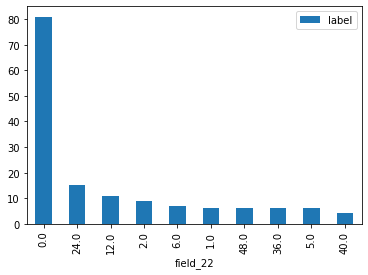

In [82]:
train_df.groupby("field_22").agg({"label": "sum"}).sort_values(
    by="label", ascending=False
).head(10).plot(kind="bar")

## Look at the data

### Determine types

In [25]:
nunique = train_df.nunique(dropna=False)
(nunique / train_df.shape[0]).sort_values(ascending=False)

2020-03-02 14:41:34,938 [INFO]  NumExpr defaulting to 4 threads.


id             1.000000
field_7        0.236300
field_51       0.150867
macv           0.102233
district       0.023967
field_53       0.020433
field_52       0.020433
field_3        0.017133
field_22       0.011633
field_13       0.007600
field_55       0.002900
age_source2    0.002333
province       0.002200
age_source1    0.002167
field_39       0.001533
field_11       0.001533
field_9        0.001200
field_56       0.001133
field_57       0.001133
field_5        0.000533
field_4        0.000367
field_54       0.000333
field_50       0.000333
field_40       0.000333
field_17       0.000300
field_43       0.000267
field_16       0.000200
field_41       0.000200
field_6        0.000200
field_12       0.000200
field_35       0.000200
field_24       0.000167
field_29       0.000133
field_42       0.000133
field_30       0.000133
field_21       0.000133
field_44       0.000133
field_36       0.000133
field_37       0.000133
field_45       0.000133
field_8        0.000100
field_2        0

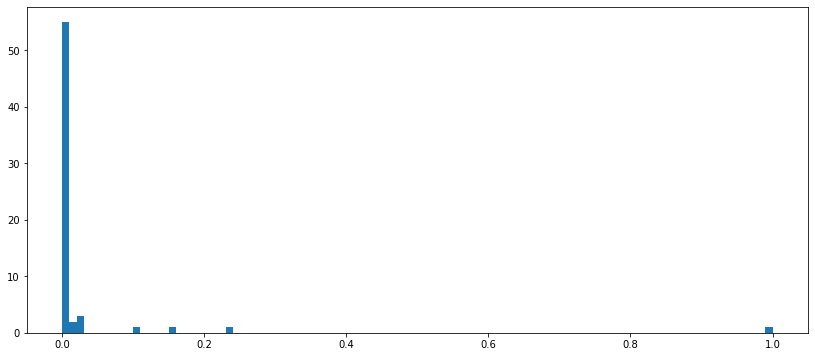

In [26]:
plt.figure(figsize=(14, 6))
_ = plt.hist(nunique.astype(float) / train_df.shape[0], bins=100)

In [10]:
train_df.columns

Index(['id', 'label', 'province', 'district', 'age_source1', 'age_source2', 'macv', 'field_1', 'field_2', 'field_3', 'field_4', 'field_5', 'field_6', 'field_7', 'field_8', 'field_9', 'field_10', 'field_11', 'field_12', 'field_13', 'field_14', 'field_15', 'field_16', 'field_17', 'field_18', 'field_19', 'field_20', 'field_21', 'field_22', 'field_23', 'field_24', 'field_25', 'field_26', 'field_27', 'field_28', 'field_29', 'field_30', 'field_31', 'field_32', 'field_33', 'field_34', 'field_35', 'field_36', 'field_37', 'field_38', 'field_39', 'field_40', 'field_41', 'field_42', 'field_43', 'field_44', 'field_45', 'field_46', 'field_47', 'field_48', 'field_49', 'field_50', 'field_51', 'field_52', 'field_53', 'field_54', 'field_55', 'field_56', 'field_57'], dtype='object')

In [11]:
pd.Series([train_df[c].dtype.kind for c in train_df.drop(columns=['id', 'label']).columns]).value_counts()

O    34
f    18
i     7
b     3
dtype: int64

In [12]:
obj_cols = [c for c in train_df.drop(columns=['id', 'label']) if train_df[c].dtype.kind in 'O']
bin_cols = [c for c in train_df.drop(columns=['id', 'label']) if train_df[c].dtype.kind in 'b']
numeric_cols = [c for c in train_df.drop(columns=['id', 'label']) if train_df[c].dtype.kind in 'fi']

In [13]:
features = obj_cols + bin_cols + numeric_cols

34 object columns, 18 float columns, 7 int columns, 3 boolean columns

In [14]:
train_df['missing'] = (train_df.isna()).sum(axis=1).astype(float)

In [15]:
train_df.drop(columns=['missing'], inplace=True)

### Correlation plot

(<Figure size 1440x1296 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f6c8cffb8d0>)

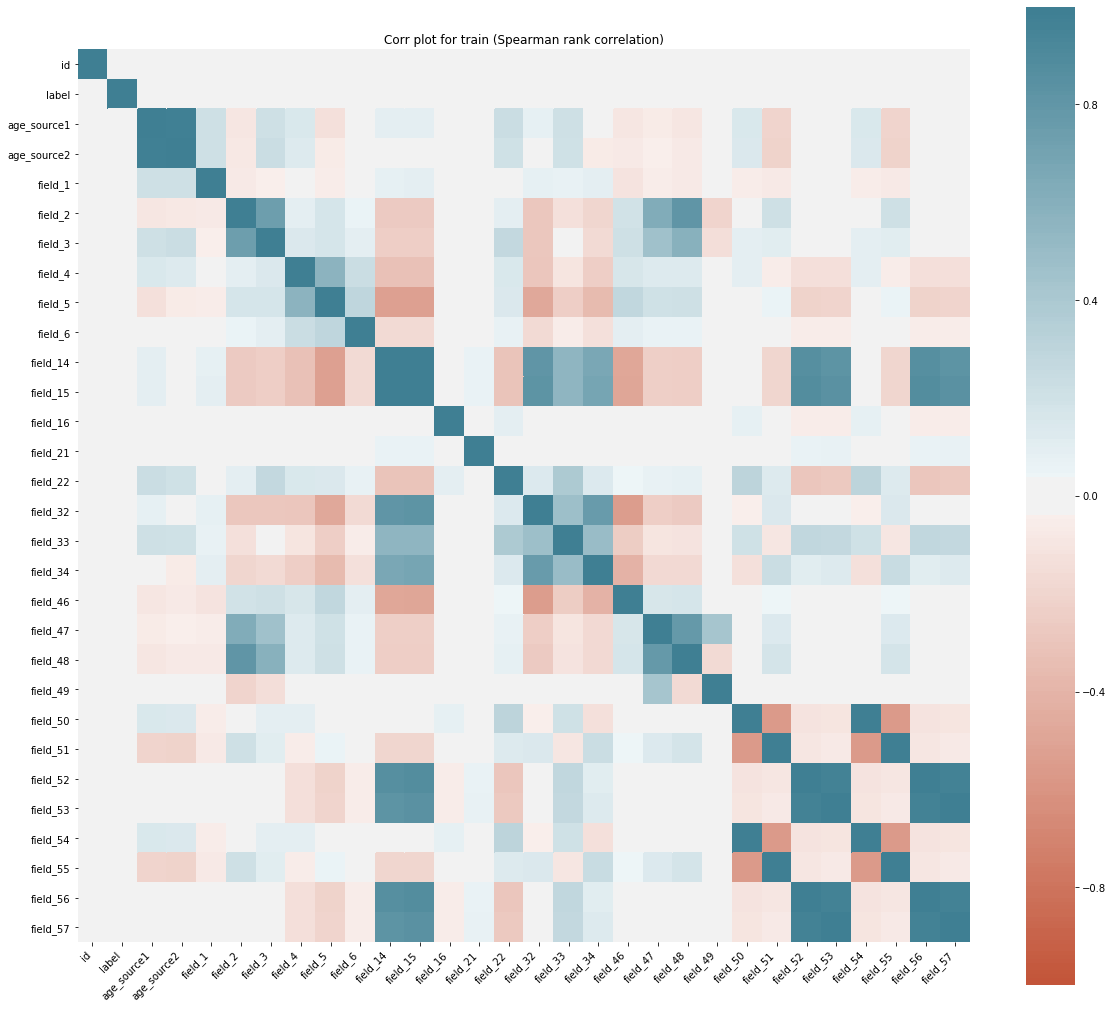

In [324]:
corr_plot(train_df, "Corr plot for train", method='spearman', figsize=(20, 18), annot=False, fmt='.2f')

(<Figure size 1080x936 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7ff644ac7610>)

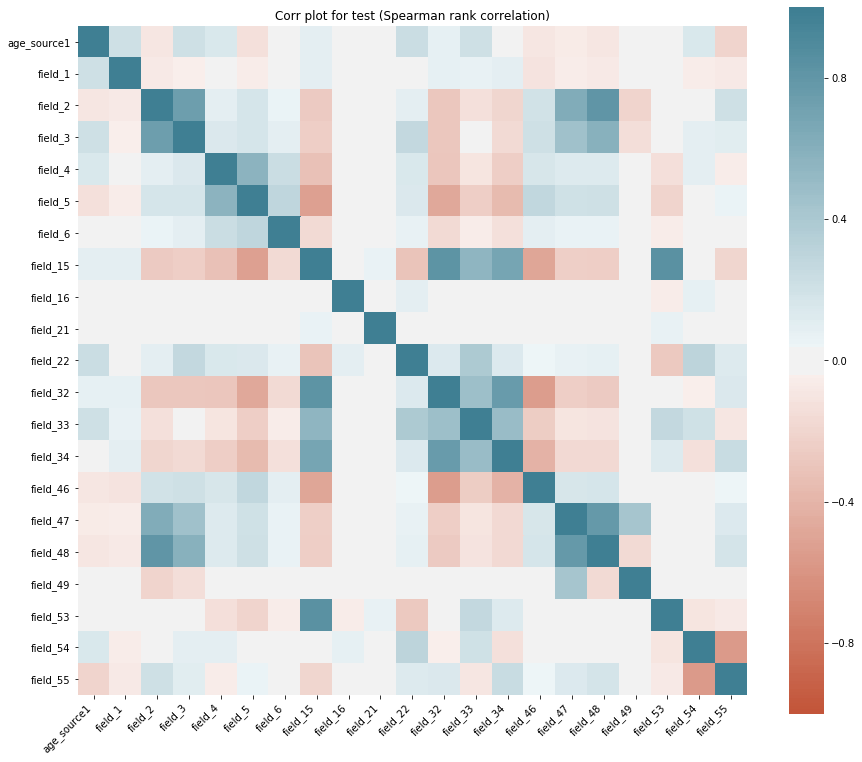

In [82]:
corr_plot(train_df[features], "Corr plot for test", method='spearman', figsize=(15, 13))

In [314]:
corrs1 = train_df.corr(method='pearson').abs().unstack(1).reset_index(name='corr')
corrs1['method'] = 'pearson'
corrs2 = train_df.corr(method='spearman').abs().unstack(1).reset_index(name='corr')
corrs2['method'] = 'spearman'
corrs = pd.concat((corrs1, corrs2))

In [325]:
# corrs = corrs.reset_index(name='corr')
corrs[(corrs['corr'] >= 0.9) & (corrs['level_0'] != (corrs['level_1']))].sort_values(by='level_0')

,level_0,level_1,corr,method
63,age_source1,age_source2,0.957839,pearson
63,age_source1,age_source2,0.979412,spearman
92,age_source2,age_source1,0.957839,pearson
92,age_source2,age_source1,0.979412,spearman
311,field_14,field_15,0.994374,pearson
311,field_14,field_15,0.994374,spearman
340,field_15,field_14,0.994374,pearson
340,field_15,field_14,0.994374,spearman
686,field_50,field_54,1.000000,spearman
717,field_51,field_55,0.998067,spearman


Drop the colinear columns

In [17]:
to_drop = ['age_source2', 'field_14', 'field_52', 'field_56', 'field_18', 'field_19', 'field_27', 'field_50', 'field_51', 'field_57']
len(to_drop)

10

In [37]:
train_df_new = train_df.drop(columns=to_drop).copy()

In [38]:
test_df_new = test_df.drop(columns=to_drop).copy()

In [81]:
obj_cols = [c for c in train_df.drop(columns=['id', 'label']).columns if train_df[c].dtype.kind in 'O']
bin_cols = [c for c in train_df.drop(columns=['id', 'label']).columns if train_df[c].dtype.kind in 'b']
numeric_cols = [c for c in train_df.drop(columns=['id', 'label']).columns if train_df[c].dtype.kind in 'f']
features = obj_cols + bin_cols + numeric_cols

### Individual features

In [15]:
test_df.isna().sum().sum() / test_df.size

0.23913015873015872

In [16]:
train_df.isna().sum().sum() / train_df.size

0.23320572916666665

In [17]:
cat_cols = ['province', 'district', 'macv', 'field_7', 'field_8', 'field_9', 'field_10', 'field_12', 'field_13',
            'field_17', 'field_24', 'field_35', 'field_39', 'field_40', 'field_41', 'field_42', 'field_43', 'field_44', 'field_45']
ind_cols = ['field_4', 'field_5', 'field_6', 'field_11', 'field_16', 'field_21']
bin_cols = ['field_1', 'field_2', 'field_15', 'field_20', 'field_23', 'field_25', 'field_26', 'field_28', 'field_29', 'field_30', 'field_31', 'field_32', 'field_33', 'field_34',
           'field_36' , 'field_37', 'field_38', 'field_46', 'field_47', 'field_48', 'field_49']
num_cols = ['age_source1', 'field_3', 'field_22', 'field_53', 'field_54', 'field_55']
features = cat_cols + ind_cols + bin_cols + num_cols

In [317]:
train_df[cat_cols].describe()

,province,district,macv,field_7,field_8,field_9,field_10,field_12,field_13,field_17,field_24,field_35,field_39,field_40,field_41,field_42,field_43,field_44,field_45
count,17182,17151,20321,29537,20322,30000,20322,20322,20300,20322,20322,20322,20322,20322,20322,20322,20322,20322,20322
unique,65,718,3066,7088,2,36,2,5,227,8,4,5,45,9,5,3,7,3,3
top,Thành phố Hồ Chí Minh,Huyện Châu Thành,None,[],MALE,DN,T1,0,YN,None,None,Zero,VN,None,I,Zezo,None,One,1
freq,2389,405,13203,12630,11031,11002,10857,16650,4976,16631,19823,9210,10569,15221,12936,20163,19126,14850,15886


In [319]:
train_df[ind_cols].astype(object).describe()

,field_4,field_5,field_6,field_11,field_16,field_21
count,29537.0,29537.0,29537.0,20322,20322.0,20322.0
unique,10.0,15.0,5.0,45,5.0,3.0
top,0.0,0.0,0.0,12,1.0,1.0
freq,19746.0,12354.0,26418.0,8499,18412.0,20296.0


In [321]:
train_df[bin_cols].astype(object).describe()

,field_1,field_2,field_15,field_20,field_23,field_25,field_26,field_28,field_29,field_30,field_31,field_32,field_33,field_34,field_36,field_37,field_38,field_46,field_47,field_48,field_49
count,30000,29537.0,30000,20322,20322,20322,20322,20322,20322,20322,20322,30000,30000,30000,20322,20322,20322,30000,30000,30000,30000
unique,2,2.0,2,2,1,2,2,2,3,3,2,2,2,2,3,3,2,2,2,2,2
top,1,1.0,0,False,True,True,False,True,FALSE,FALSE,FALSE,0,1,0,FALSE,TRUE,False,0,True,True,True
freq,23260,22541.0,18148,17190,20322,15907,12301,20124,16717,10499,16083,19878,20478,16337,15932,19070,20200,17918,17583,20824,26366


In [323]:
train_df_new[num_cols].describe()

,age_source1,field_3,field_22,field_53,field_54,field_55,n_missing
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000
mean,32.169433,1726.953500,35.421367,32.963518,0.025065,0.105576,15.643567
std,7.027383,1461.535274,47.481152,7.587787,0.098425,0.070962,14.061763
min,0.000000,-1.000000,0.000000,31.171000,0.000000,0.000000,1.000000
25%,30.000000,345.000000,12.000000,31.171000,0.000000,0.050000,5.000000
50%,31.000000,1452.000000,23.000000,31.171000,0.000000,0.110000,8.000000
75%,33.000000,2912.000000,36.000000,31.171000,0.000000,0.130000,36.000000
max,71.000000,8037.000000,433.000000,67.634000,1.000000,1.000000,42.000000


In [48]:
# Fill NaNs with 'None'
train_df_plot = train_df_new.copy()
for c in features:
    if c in cat_cols or c in bin_cols or c in ind_cols:
        train_df_plot[c] = train_df_plot[c].fillna('None')
    elif c in num_cols:
        train_df_plot[c] = train_df_plot[c].fillna(train_df_plot[c].mean())
train_df_plot.macv = train_df_plot.macv.str.lower()

Conversion

In [49]:
for c in features:
    if (c in cat_cols or c in bin_cols or c in ind_cols) and (train_df_plot[c].dtype.kind in 'fi'):
        train_df_plot[c] = train_df_plot[c].astype('object')

In [42]:
train_df_plot[ind_cols]

,field_4,field_5,field_6,field_11,field_16,field_21
0,0,0,0,None,None,None
1,1,1,1,12,2,1
2,1,4,0,12,1,1
3,1,1,0,None,None,None
4,0,2,0,12,1,1
...,...,...,...,...,...,...
29995,2,6,0,0,1,1
29996,0,8,2,6,1,1
29997,2,1,0,None,None,None
29998,2,2,0,12,1,1


[Text(0, 0, 'none'),
 Text(0, 0, 'công nhân'),
 Text(0, 0, 'nhân viên'),
 Text(0, 0, 'giáo viên'),
 Text(0, 0, 'công nhân may'),
 Text(0, 0, 'công nhân may công nghiệp'),
 Text(0, 0, 'công nhân sản xuất'),
 Text(0, 0, 'công nhân viên'),
 Text(0, 0, 'nhân viên bán hàng'),
 Text(0, 0, 'nhân viên sản xuất')]

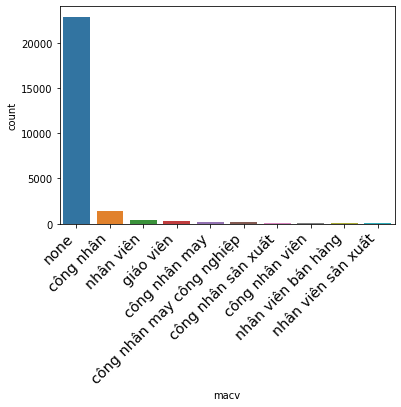

In [43]:
g = sns.countplot(x='macv', data=train_df_plot, order=train_df_plot.macv.value_counts().iloc[:10].index,)
xticklabels = g.get_xticklabels()
g.set_xticklabels(xticklabels,rotation=45, horizontalalignment='right', fontsize='x-large')

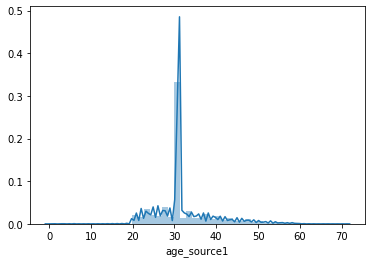

In [172]:
sns.distplot(train_df['age_source1'].fillna(train_df['age_source1'].median()))

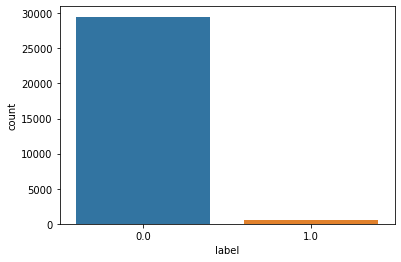

In [209]:
sns.countplot(x='label', data=train_df)

In [230]:
train_df['label']

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
29995    0.0
29996    0.0
29997    0.0
29998    0.0
29999    0.0
Name: label, Length: 30000, dtype: float64

#### Categorical features

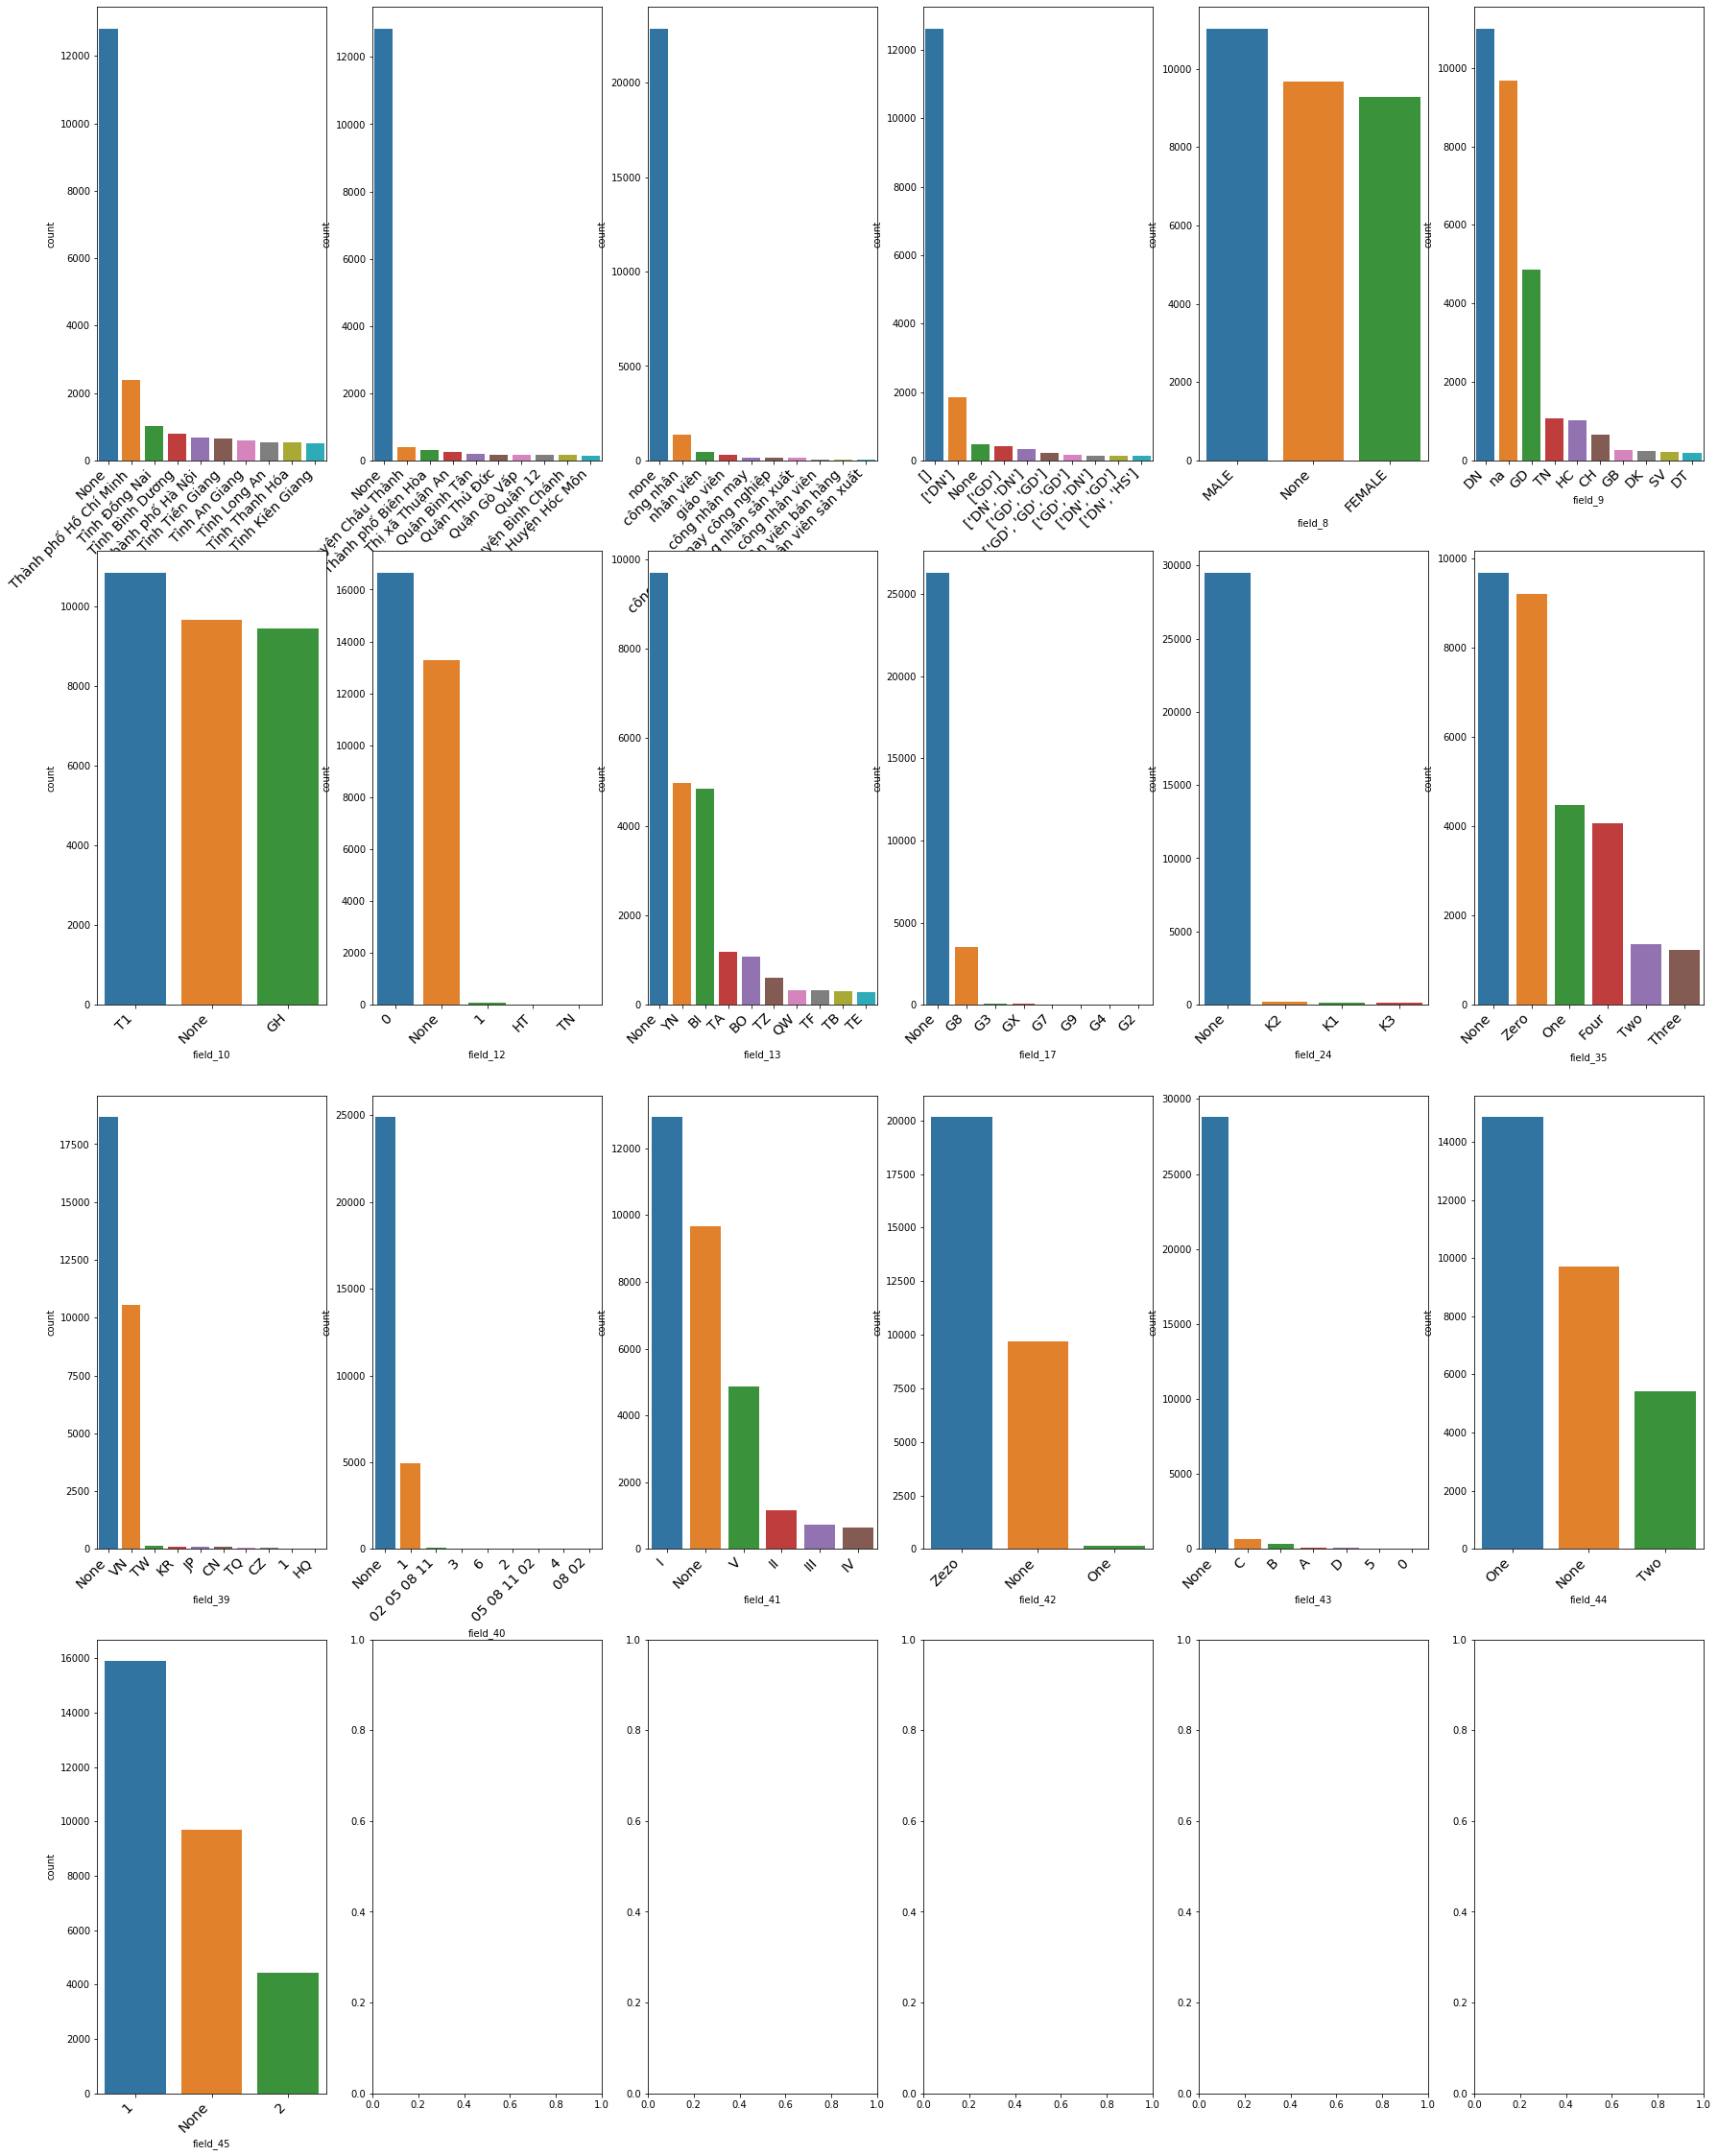

In [44]:
n = len(cat_cols)
# n = 3
ncols = 6
nrows = math.ceil(n / ncols)
fig, axes = plt.subplots(nrows, ncols, figsize= (30, 40))
# for i, c in enumerate(train_df[cat_cols].columns):
for i, ax in zip(range(n), axes.flat):
#     plt.sca(axes[i])
#     print(c)
    g = sns.countplot(x=cat_cols[i], data=train_df_plot, ax=ax, order=train_df_plot[cat_cols[i]].value_counts().iloc[:10].index)
    xticklabels = g.get_xticklabels()
    g.set_xticklabels(xticklabels,rotation=45, horizontalalignment='right', fontsize='x-large')

#### Ind features

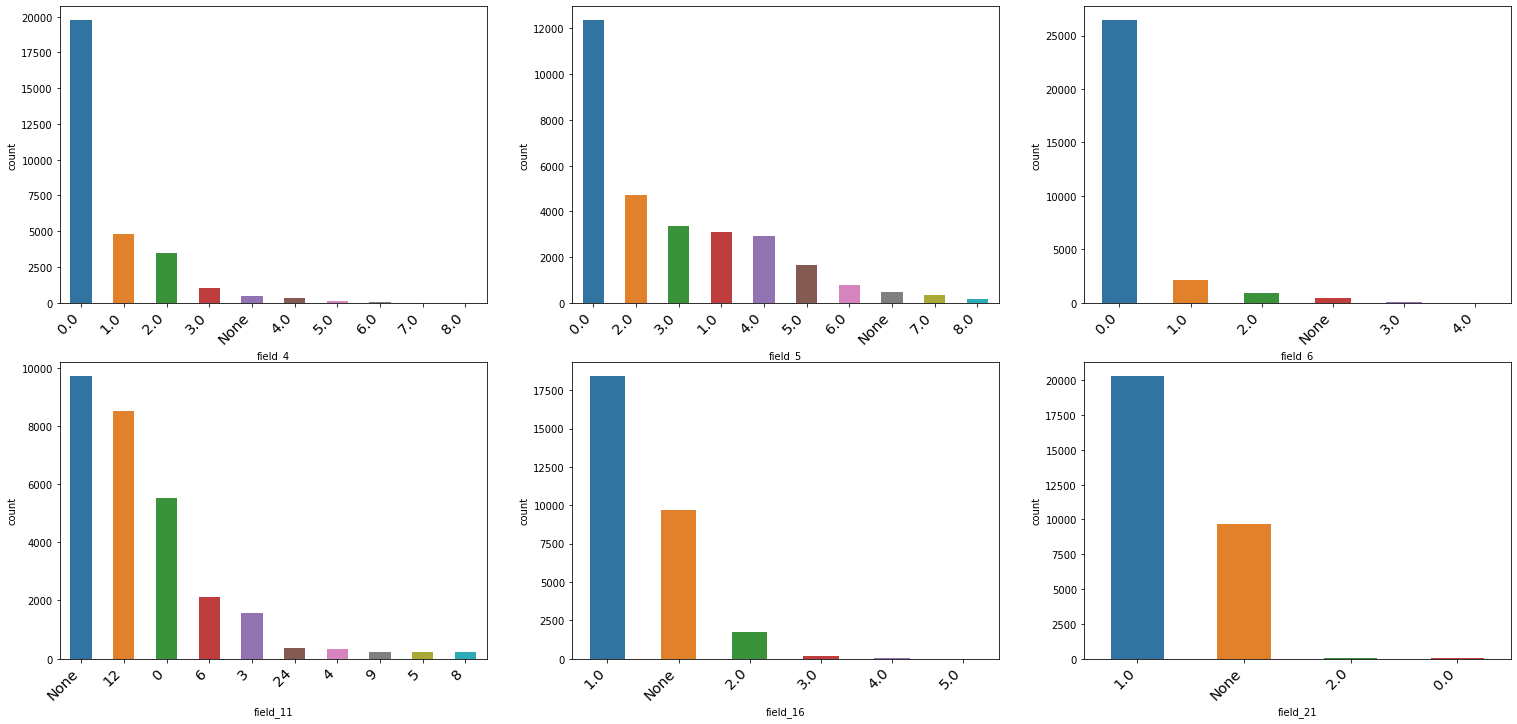

In [45]:
n = len(ind_cols)
# n = 3
ncols = 3
nrows = math.ceil(n / ncols)
fig, axes = plt.subplots(nrows, ncols, figsize= (26, 12))
# for i, c in enumerate(train_df[cat_cols].columns):
for i, ax in zip(range(n), axes.flat):
#     plt.sca(axes[i])
#     print(c)
    g = sns.countplot(x=ind_cols[i], data=train_df_plot, ax=ax, order=train_df_plot[ind_cols[i]].value_counts().iloc[:10].index)
    xticklabels = g.get_xticklabels()
    g.set_xticklabels(xticklabels,rotation=45, horizontalalignment='right', fontsize='x-large')
    change_width(ax, .5)

#### Binary features

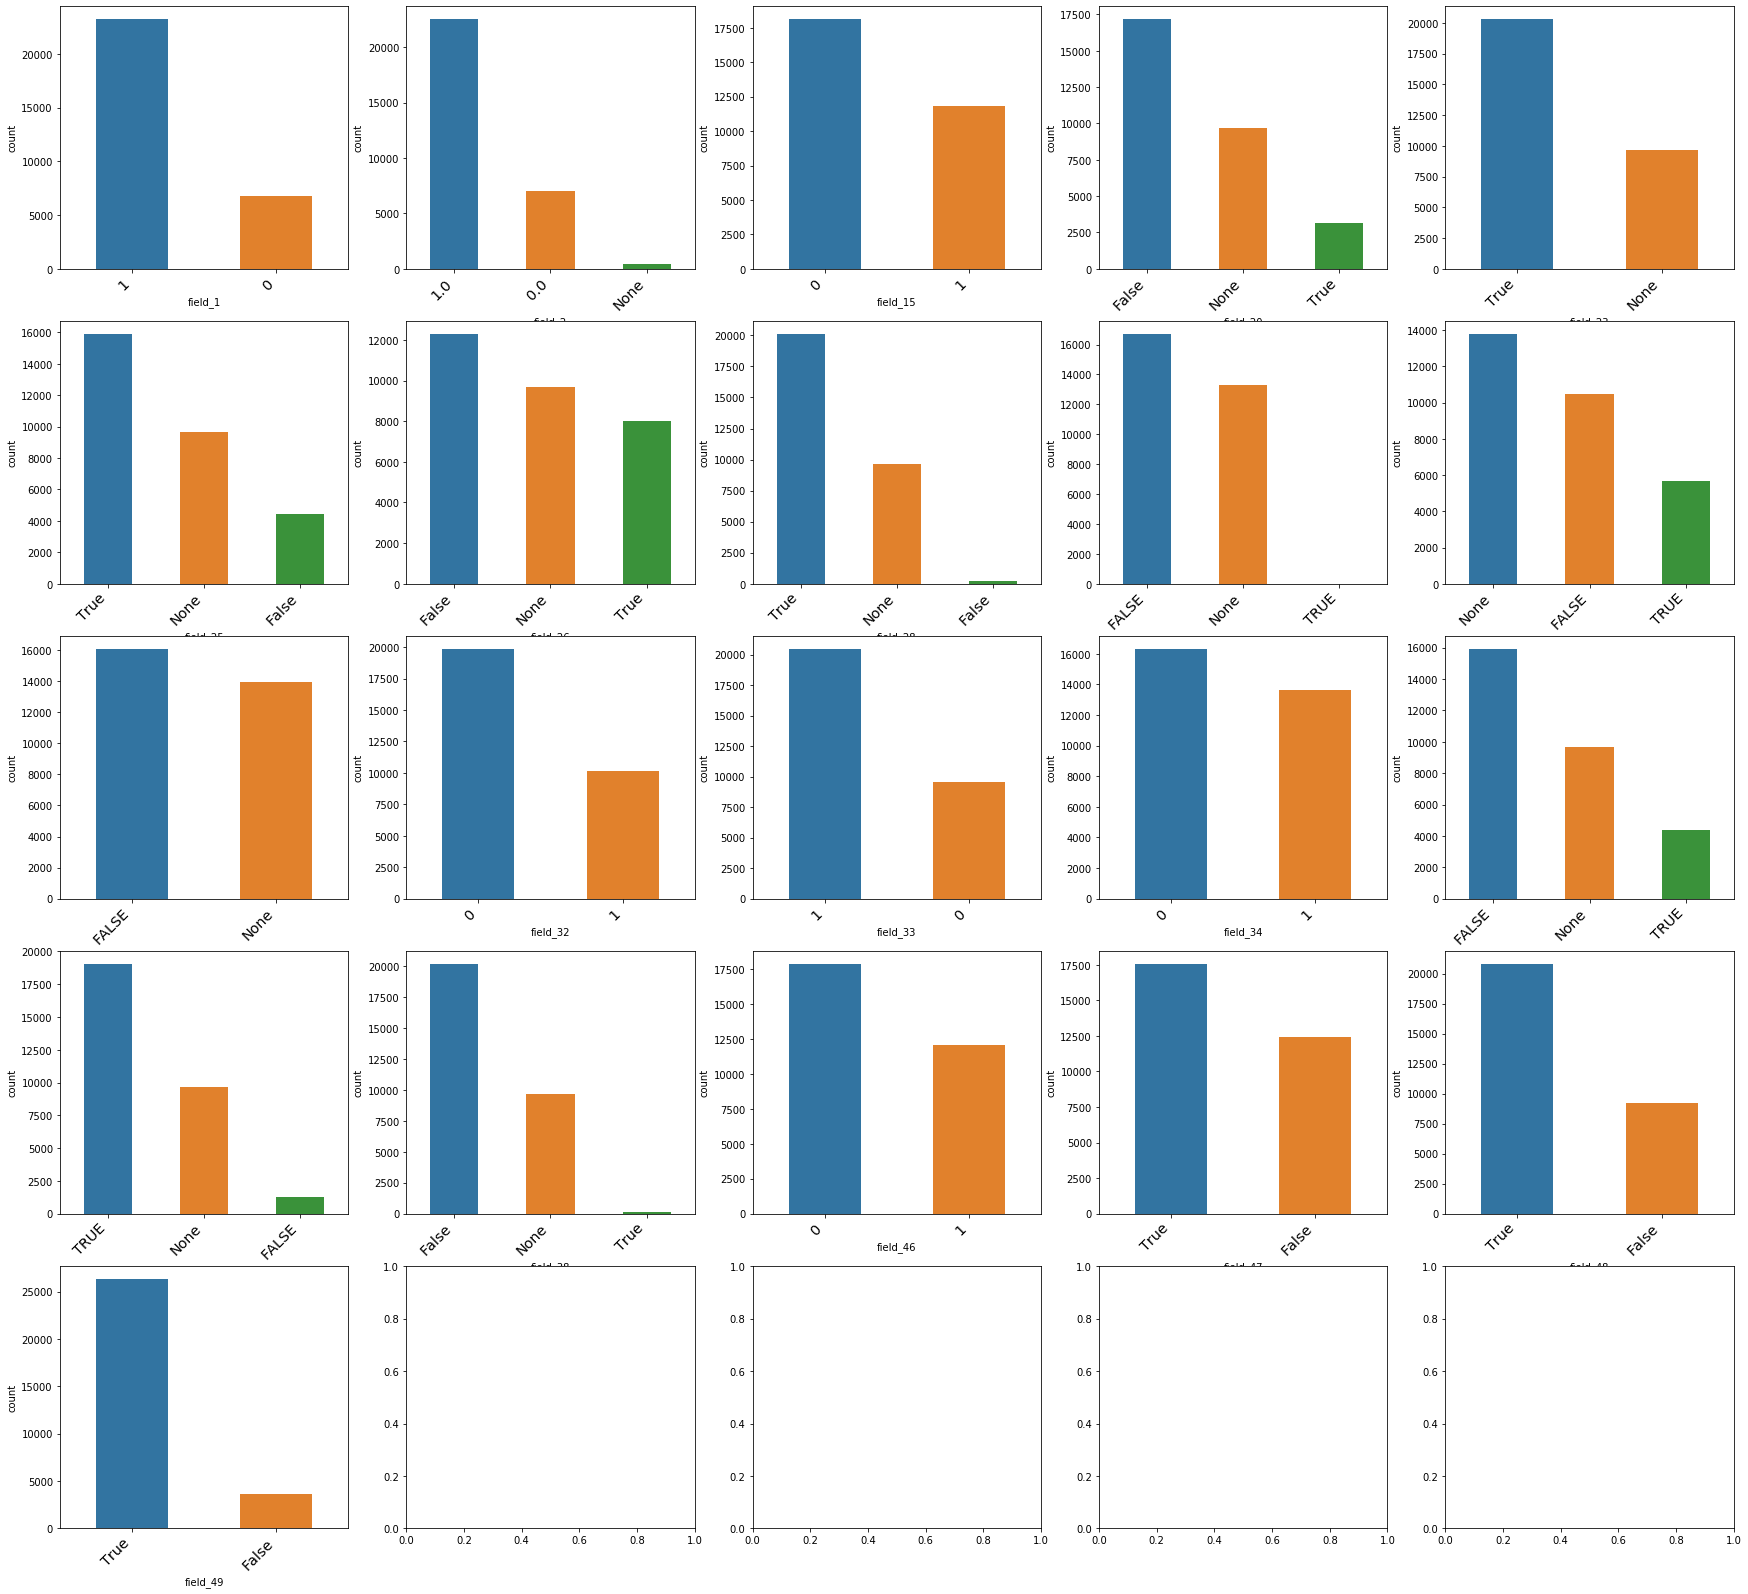

In [46]:
n = len(bin_cols)
# n = 3
ncols = 5
nrows = math.ceil(n / ncols)
fig, axes = plt.subplots(nrows, ncols, figsize= (30, 28))
# for i, c in enumerate(train_df[cat_cols].columns):
for i, ax in zip(range(n), axes.flat):
#     plt.sca(axes[i])
#     print(c)
    g = sns.countplot(x=bin_cols[i], data=train_df_plot, ax=ax, order=train_df_plot[bin_cols[i]].value_counts().iloc[:10].index)
    xticklabels = g.get_xticklabels()
    g.set_xticklabels(xticklabels,rotation=45, horizontalalignment='right', fontsize='x-large')
    change_width(ax, .5)

#### Float features

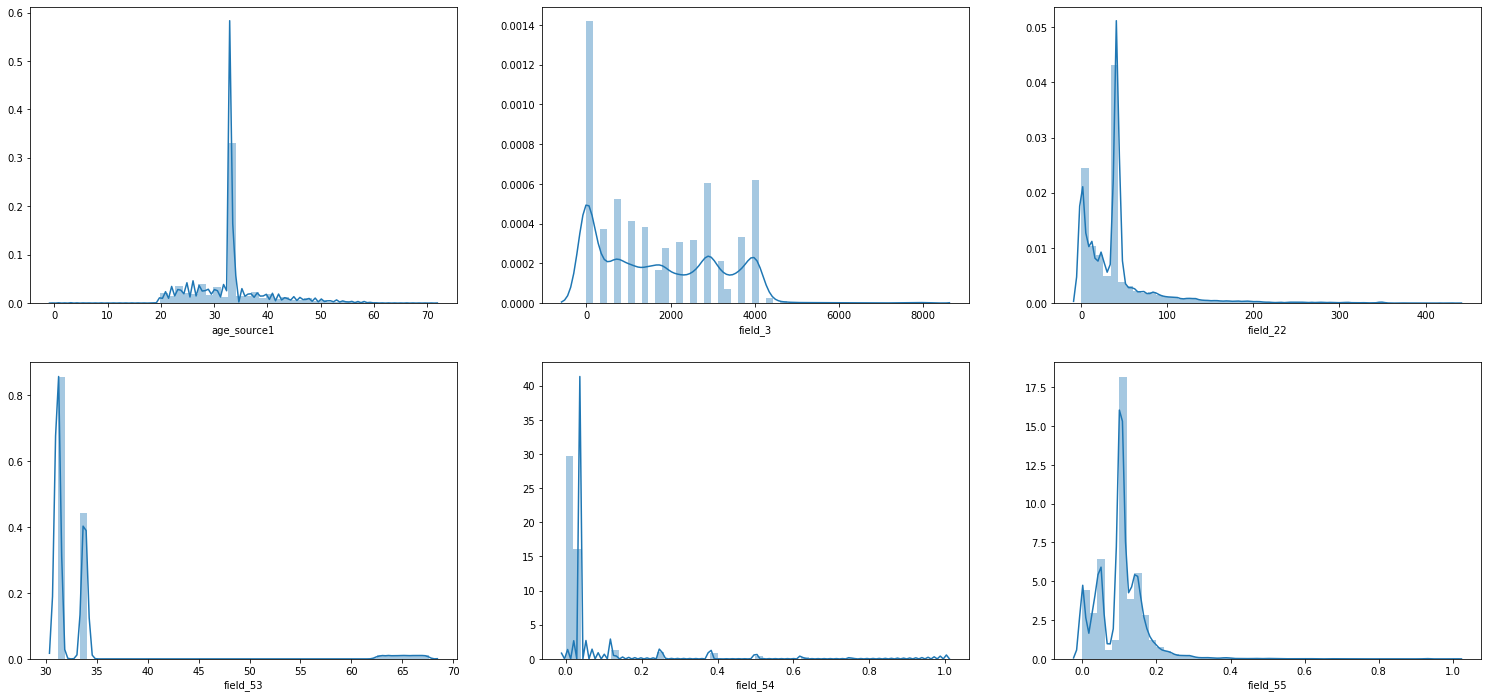

In [50]:
n = len(num_cols)
ncols = 3
nrows = math.ceil(n // ncols)
fig, axes = plt.subplots(nrows, ncols, figsize= (26, 12))
# for i, c in enumerate(train_df[cat_cols].columns):
for i, ax in zip(range(n), axes.flat):
#     plt.sca(axes[i])
#     print(c)
    g = sns.distplot(train_df_plot[num_cols[i]].fillna(train_df_plot[num_cols[i]].median()), ax=ax)

### Individual features' relationship with label

In [54]:
cat_cols

['province',
 'district',
 'macv',
 'field_7',
 'field_8',
 'field_9',
 'field_10',
 'field_12',
 'field_13',
 'field_17',
 'field_24',
 'field_35',
 'field_39',
 'field_40',
 'field_41',
 'field_42',
 'field_43',
 'field_44',
 'field_45']

#### Categorical features

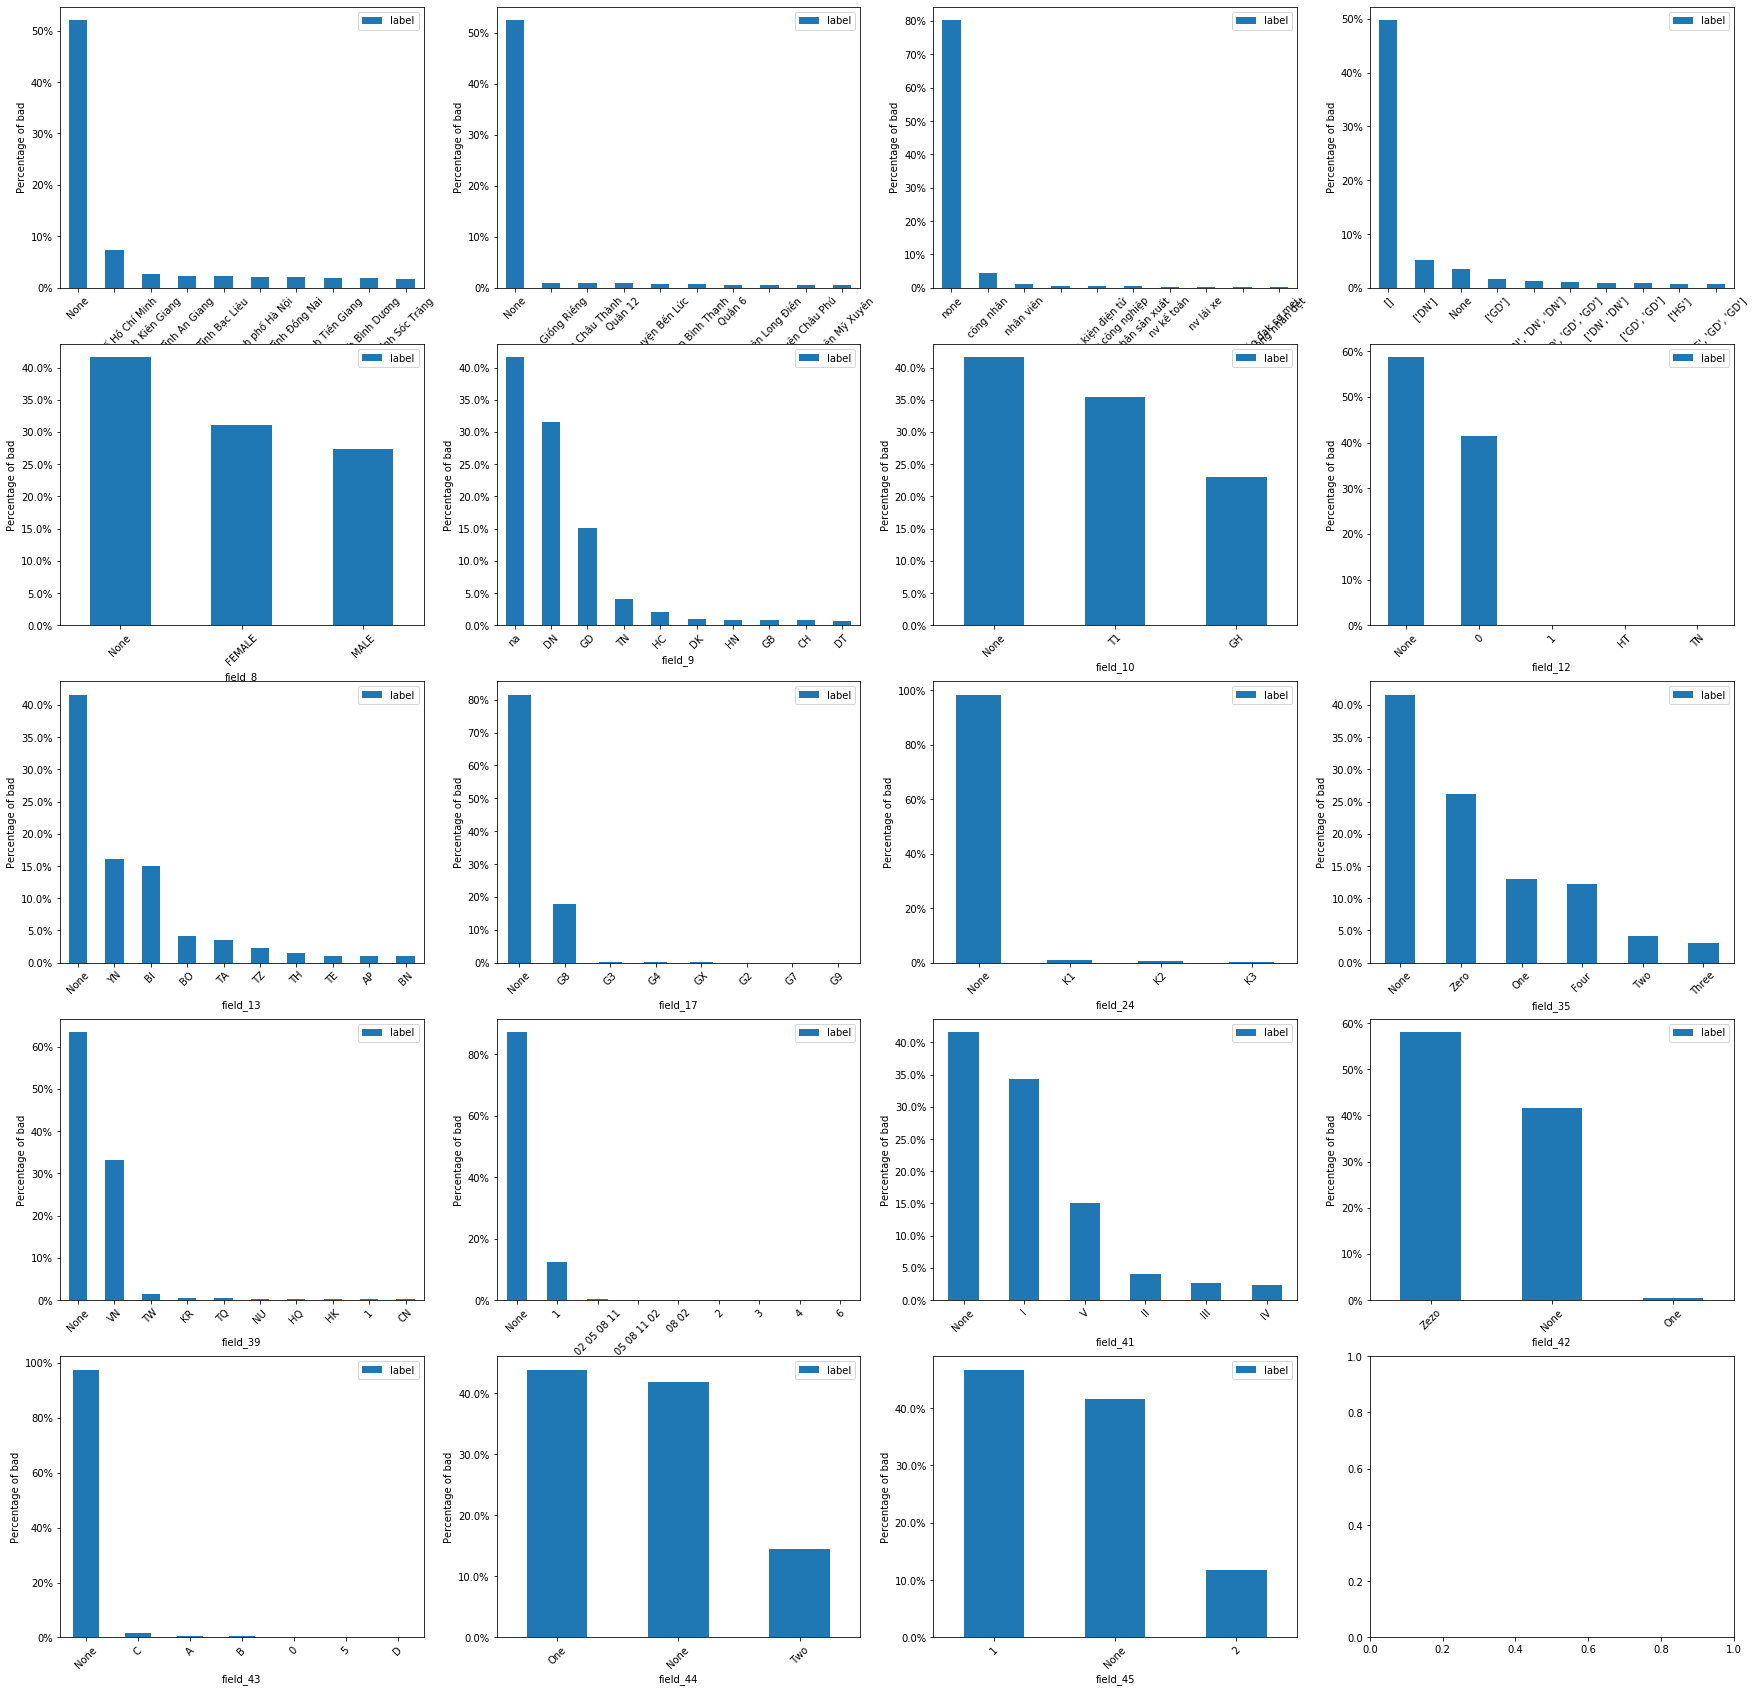

In [58]:
n = len(cat_cols)
bad_count = train_df[train_df['label'] == 1].label.count()
# n = 12
ncols = 4
nrows = math.ceil(n / ncols)
fig, axes = plt.subplots(nrows, ncols, figsize= (30, 30),)
# for i, c in enumerate(train_df[cat_cols].columns): 
for i, ax in zip(range(n), axes.flat):
    temp = train_df_plot.groupby(cat_cols[i]).agg({
        'label': lambda x: (x == 1).sum() * 100 / bad_count
    }).sort_values(by='label', ascending=False).head(10)
    # sns.barplot()
    temp.plot(kind='bar', ax=ax)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    ax.set_ylabel('Percentage of bad')
    ax.xaxis.set_tick_params(rotation=45)

#### Ind features

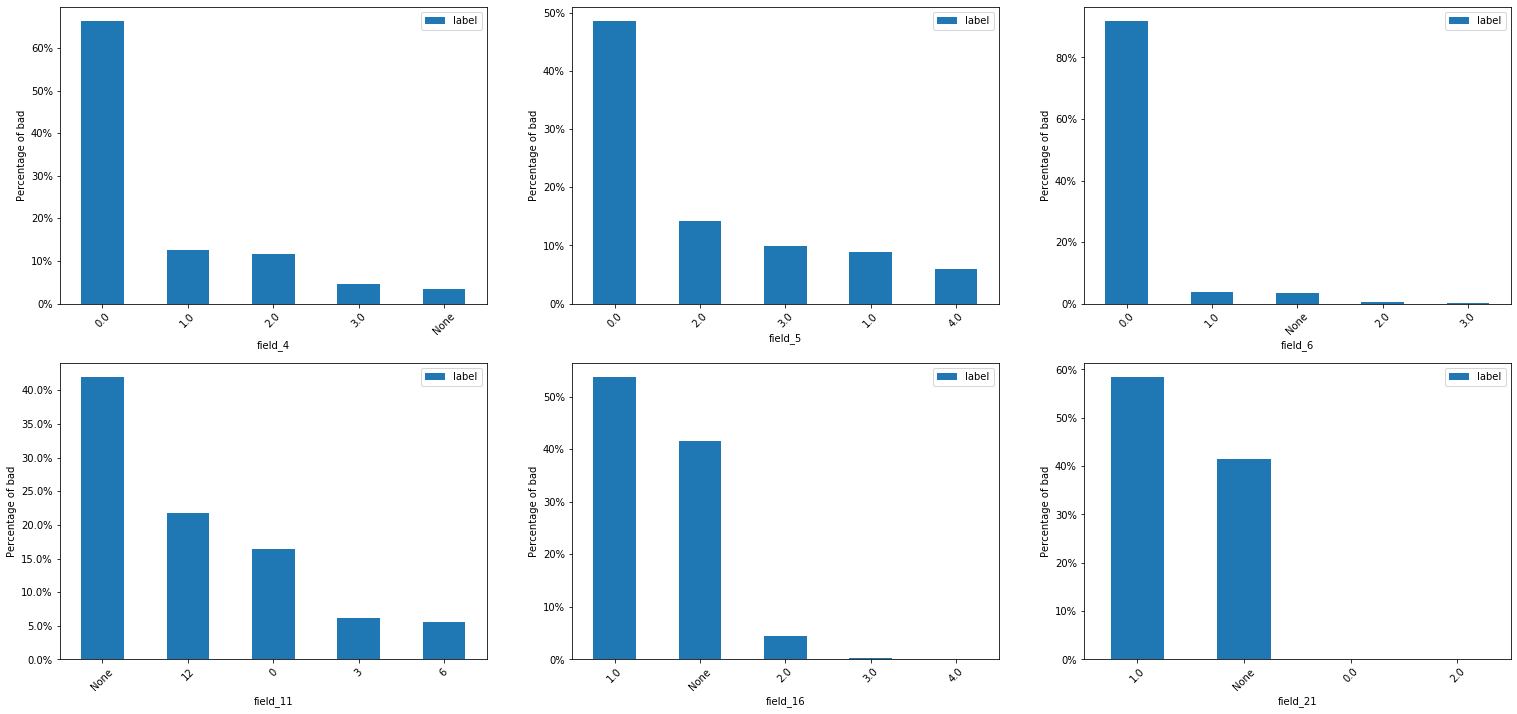

In [59]:
n = len(ind_cols)
bad_count = train_df_plot[train_df_plot['label'] == 1].label.count()
# n = 12
ncols = 3
nrows = math.ceil(n / ncols)
fig, axes = plt.subplots(nrows, ncols, figsize= (26, 12))
# for i, c in enumerate(train_df[cat_cols].columns):
for i, ax in zip(range(n), axes.flat):
    temp = train_df_plot.groupby(ind_cols[i]).agg({
        'label': lambda x: (x == 1).sum() * 100 / bad_count
    }).sort_values(by='label', ascending=False).head(5)
    # sns.barplot()
    temp.plot(kind='bar', ax=ax)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    ax.set_ylabel('Percentage of bad')
    ax.xaxis.set_tick_params(rotation=45)

#### Binary features

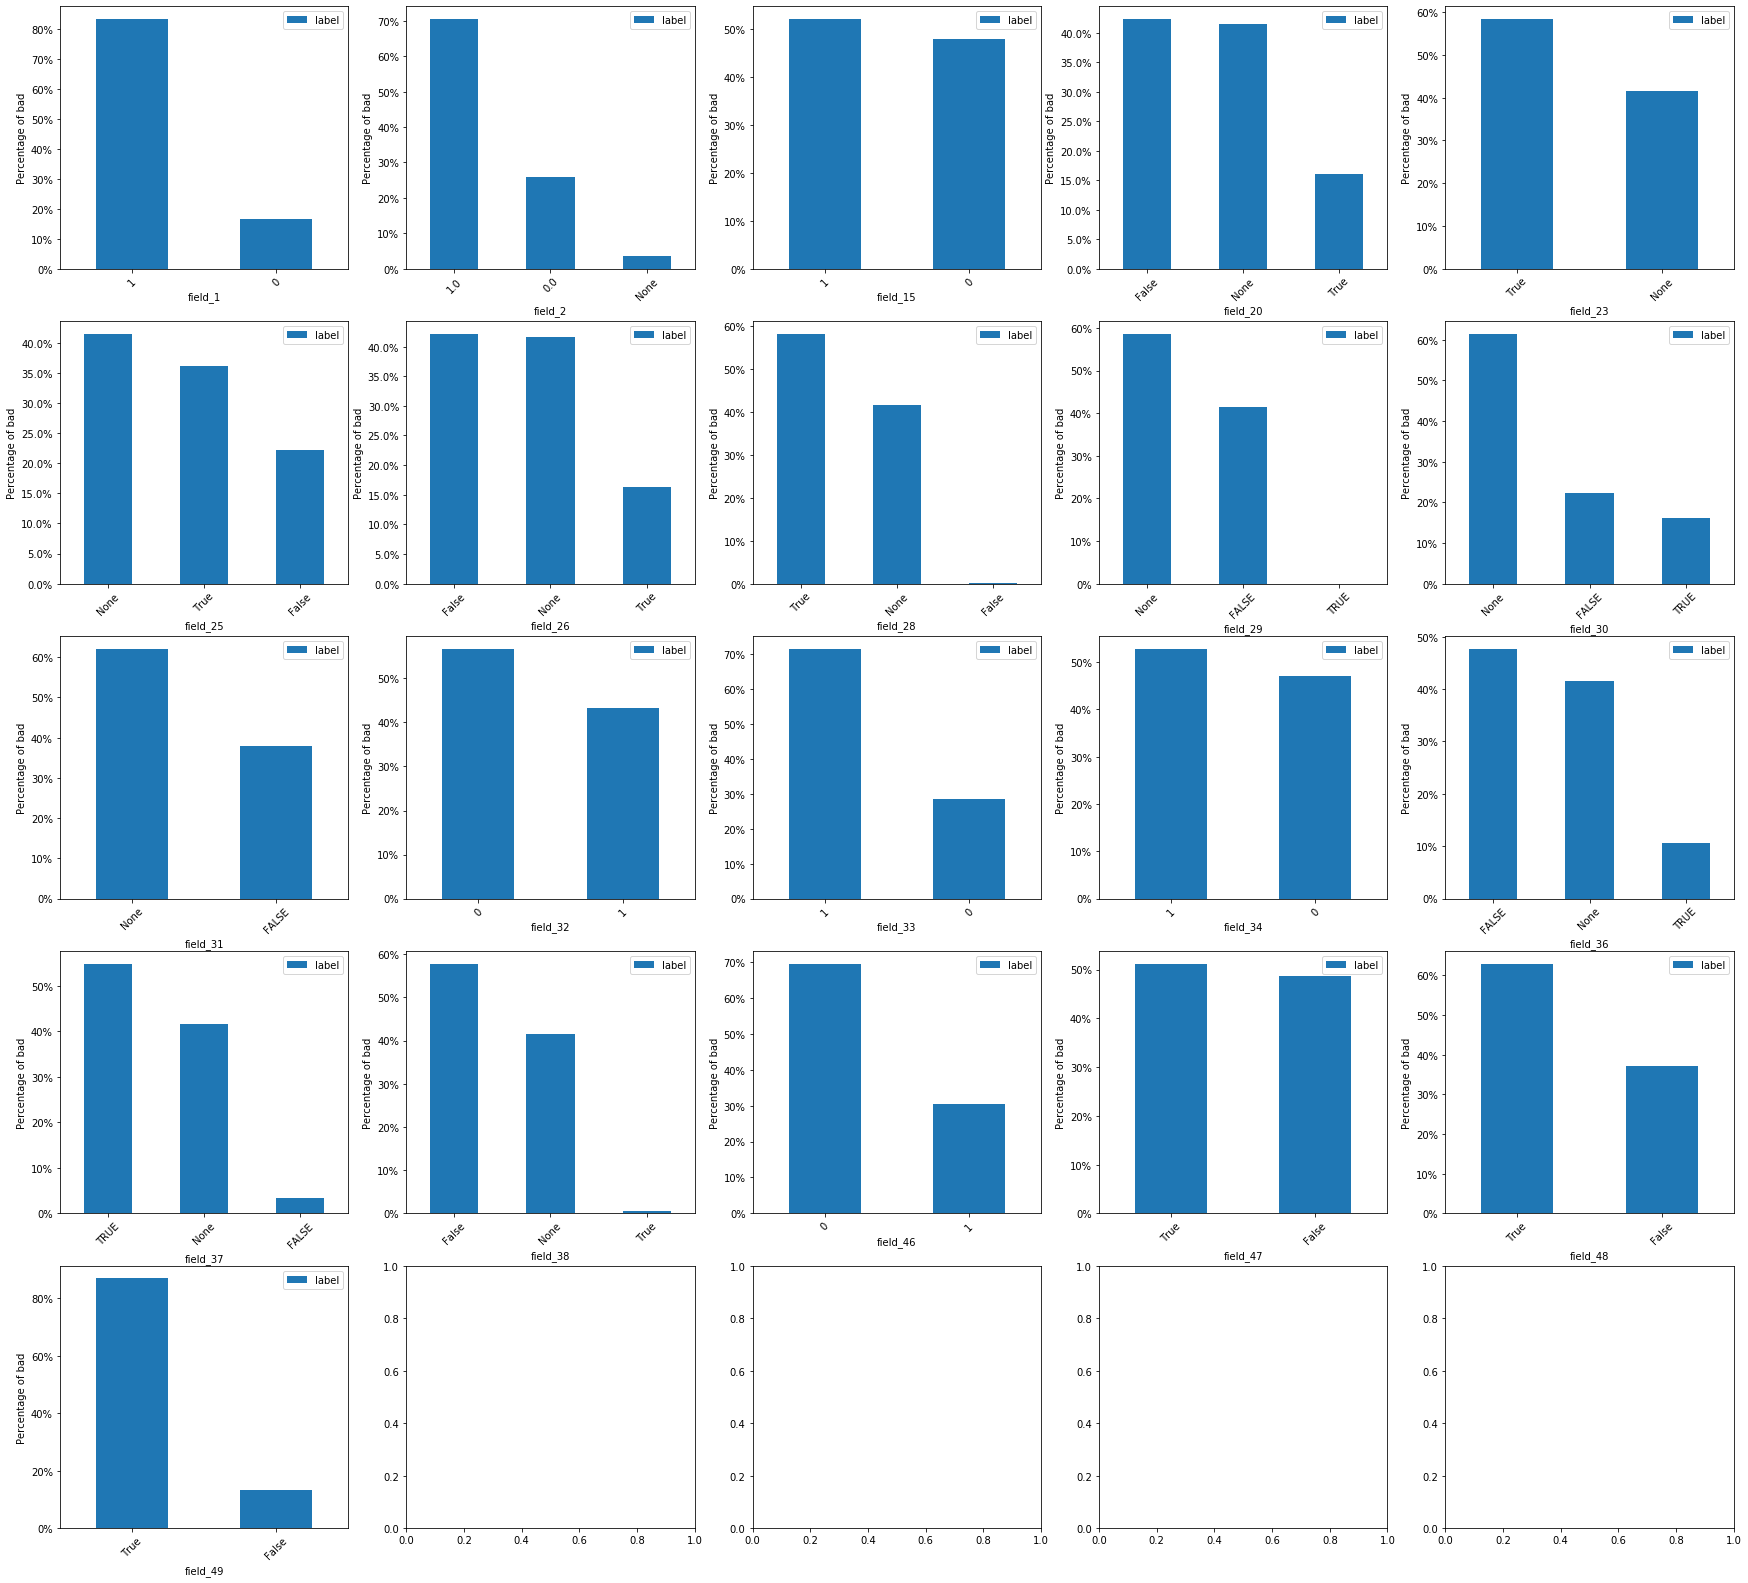

In [66]:
n = len(bin_cols)
bad_count = train_df_plot[train_df_plot['label'] == 1].label.count()
# n = 12
ncols = 5
nrows = math.ceil(n / ncols)
fig, axes = plt.subplots(nrows, ncols, figsize= (30, 28))
# for i, c in enumerate(train_df[cat_cols].columns):
for i, ax in zip(range(n), axes.flat):
    temp = train_df_plot.groupby(bin_cols[i]).agg({
        'label': lambda x: (x == 1).sum() * 100 / bad_count
    }).sort_values(by='label', ascending=False).head(5)
    # sns.barplot()
    temp.plot(kind='bar', ax=ax)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    ax.set_ylabel('Percentage of bad')
    ax.xaxis.set_tick_params(rotation=45)

#### Float features

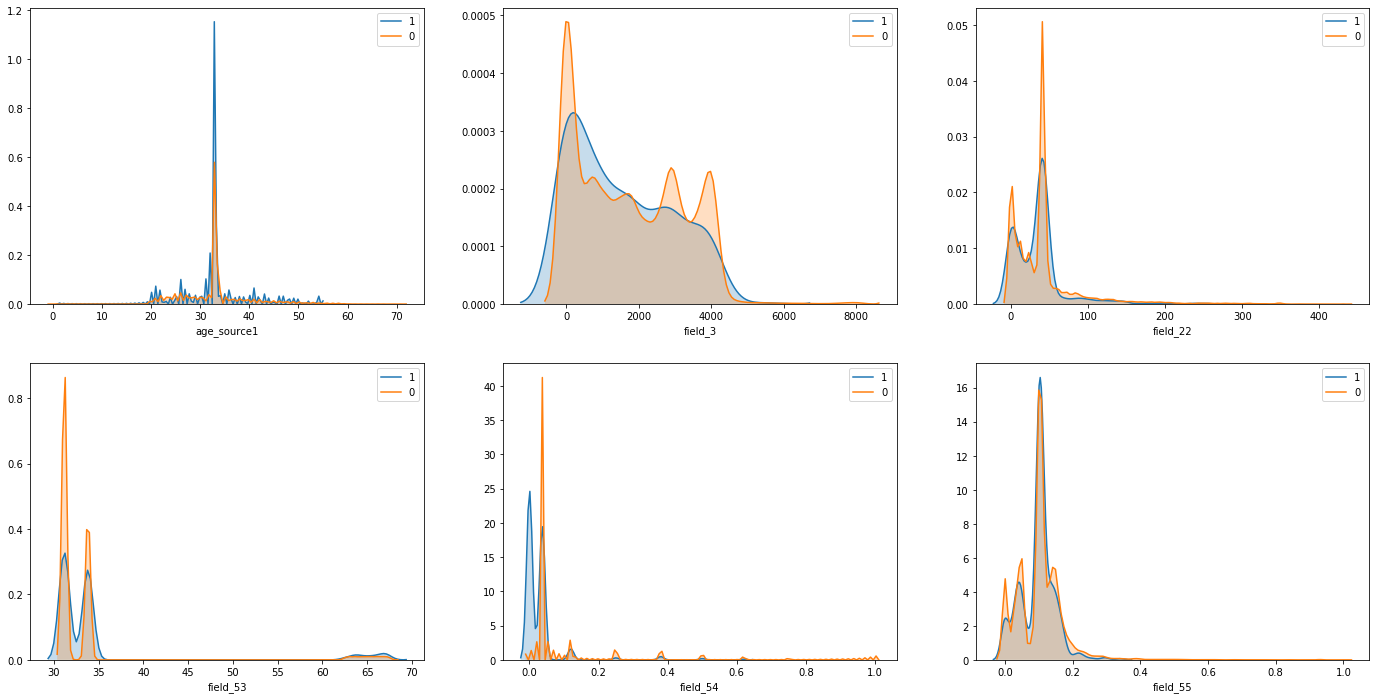

In [93]:
n = len(num_cols)
# bad_count = train_df_plot[train_df_plot['label'] == 1].label.count()
# n = 12
ncols = 3
nrows = math.ceil(n / ncols)
fig, axes = plt.subplots(nrows, ncols, figsize= (24, 12))
for i, ax in zip(range(n), axes.flat):
# for i in range(n):
#     pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
#     g = sns.FacetGrid(train_df_plot[[num_cols[i],'label']], row="label", hue="label", aspect=5, height=2.5, palette=pal)
#     # Draw the densities in a few steps
#     g.map(sns.kdeplot, num_cols[i], clip_on=False, shade=True, alpha=1, lw=1.5, bw=.2)
#     g.map(sns.kdeplot, num_cols[i], clip_on=False, color="w", lw=2, bw=.2)
#     g.map(plt.axhline, y=0, lw=2, clip_on=False)
#     g.map(label, num_cols[i])

#     # Set the subplots to overlap
#     g.fig.subplots_adjust(hspace=-.25)

#     # Remove axes details that don't play well with overlap
#     g.set_titles("")
#     g.set(yticks=[])
#     g.despine(bottom=True, left=True)
    sns.kdeplot(train_df_plot.loc[train_df_plot['label'] == 1, num_cols[i]], ax=ax, label="1", shade=True)
    sns.kdeplot(train_df_plot.loc[train_df_plot['label'] == 0, num_cols[i]], ax=ax, label="0", shade=True)
    ax.set_xlabel(num_cols[i])

## Cleaning

In [99]:
obj_cols = [c for c in train_df.drop(columns=['id', 'label']).columns if train_df[c].dtype.kind in 'O']
bin_cols = [c for c in train_df.drop(columns=['id', 'label']).columns if train_df[c].dtype.kind in 'b']
numeric_cols = [c for c in train_df.drop(columns=['id', 'label']).columns if train_df[c].dtype.kind in 'fi']

In [24]:
cat_cols = ['province', 'district', 'macv', 'field_7', 'field_8', 'field_9', 'field_10', 'field_12', 'field_13',
            'field_17', 'field_24', 'field_35', 'field_39', 'field_40', 'field_41', 'field_42', 'field_43', 'field_44', 'field_45']
ind_cols = ['field_4', 'field_5', 'field_6', 'field_11', 'field_16', 'field_21']
bin_cols = ['field_1', 'field_2', 'field_15', 'field_20', 'field_23', 'field_25', 'field_26', 'field_28', 'field_29', 'field_30', 'field_31', 'field_32', 'field_33', 'field_34',
           'field_36' , 'field_37', 'field_38', 'field_46', 'field_47', 'field_48', 'field_49']
bin_cols += ['field_14', 'field_18', 'field_19', 'field_27']
num_cols = ['age_source1', 'field_3', 'field_22', 'field_53', 'field_54', 'field_55']
num_cols += ['age_source2', 'field_50', 'field_51', 'field_52', 'field_56', 'field_57']
features = cat_cols + ind_cols + bin_cols + num_cols

In [138]:
nan_cols = []
for c in train_df.columns[2:]:
    print(f"{c} | ({train_df[c].dtype}) | {train_df[c].nunique()} values | {train_df[c].isna().mean().round(3) * 100} % missing | {train_df[c].unique()[:10]}")
    if train_df[c].isna().mean() > 0.3 and c in cat_cols:
        nan_cols.append(c)

province | (object) | 65 values | 42.699999999999996 % missing | [nan 'Tỉnh Đồng Nai' 'Tỉnh Tuyên Quang' 'Thành phố Hồ Chí Minh'
 'Tỉnh Bắc Giang' 'Tỉnh Thanh Hóa' 'Tỉnh Thừa Thiên Huế' 'Tỉnh Cà Mau'
 'Tỉnh Kiên Giang' 'Tỉnh Long An']
district | (object) | 718 values | 42.8 % missing | [nan 'Thành phố Biên Hòa' 'Huyện Long Thành' 'Thành phố Tuyên Quang'
 'Quận 1' 'Huyện Yên Dũng' 'Huyện Nga Sơn' 'Huyện Hóc Môn'
 'Huyện Phong Điền' 'Huyện Đầm Dơi']
age_source1 | (float64) | 64 values | 42.699999999999996 % missing | [nan 44. 30. 43. 21. 40. 25. 31. 20. 36.]
age_source2 | (float64) | 69 values | 32.300000000000004 % missing | [nan 44. 30. 21. 28. 32. 25. 64. 36. 20.]
macv | (object) | 3066 values | 32.300000000000004 % missing | [nan 'None' 'Công nhân' '2983' 'Cấp dưỡng' 'Nhân viên bảo trì'
 'Công nhân ủi' 'Nhân viên' 'Nhân viên kinh doanh'
 'Công nhân may công nghiệp']
field_1 | (int64) | 2 values | 0.0 % missing | [1 0]
field_2 | (float64) | 2 values | 1.5 % missing | [ 1.  0. nan]
fie

In [139]:
len(nan_cols)

17

In [28]:
train_df_new = train_df.copy()

In [27]:
train_df_new.drop(columns=to_drop, inplace=True)

In [29]:
# Fill 'None' with NaNs
for c in train_df_new.columns:
    train_df_new.loc[train_df[c] == 'None', c] = np.nan

In [30]:
for c in features:
    if (c in cat_cols or c in bin_cols or c in ind_cols) and (train_df_new[c].dtype.kind in 'fi'):
        train_df_new[c] = train_df_new[c].astype('object')

In [31]:
# New feature: number of nans
train_df_new['n_missing'] = train_df_new.isna().sum(axis=1)
num_cols.append('n_missing')
features.append('n_missing')

In [32]:
new_bin_cols = []
for c in bin_cols:
    if train_df_new[c].isna().sum() > 0:
        if train_df_new[c].isna().min() < 0.1:
            train_df_new[c] = train_df_new[c].fillna(train_df_new[c].mode()[0])
            new_bin_cols.append(c)
            train_df_new[c] = train_df_new[c].astype('bool')
        else:
            train_df_new[c] = train_df_new[c].fillna('undefined')
            cat_cols.append(c)
    else:
        new_bin_cols.append(c)
        train_df_new[c] = train_df_new[c].astype('bool')

In [33]:
# for col in features:
# #     print(col)
#     if col in obj_cols or col in bin_cols:
#         if train_df_new[c].isna().mean() < 0.4:
#             train_df_new[col].fillna(train_df_new[col].mode()[0], inplace=True)
#         else:
#             train_df_new[col].fillna('Undefined', inplace=True)
#         le = LabelEncoder()
#         le.fit(train_df_new[col])
#         train_df_new[col] = le.transform(train_df_new[col])
#     elif col in numeric_cols:
#         train_df_new[col].fillna(train_df_new[col].median(), inplace=True)

In [34]:
train_df_new.macv = train_df_new.macv.str.lower()

In [35]:
for c in features:
#     print(c)
    if c in cat_cols or c in ind_cols:
        if train_df_new[c].isna().mean() < 0.1:
            train_df_new[c].fillna(train_df_new[c].mode()[0], inplace=True)
        else:
            train_df_new[c].fillna('undefined', inplace=True)
        le = LabelEncoder()
        le.fit(train_df_new[c].astype(str))
        train_df_new[c] = le.transform(train_df_new[c].astype(str))
    elif c in num_cols:
        train_df_new[c].fillna(train_df_new[c].median(), inplace=True)

In [36]:
# New feature: Sum of binary
train_df_new['bin_sum'] = train_df_new[new_bin_cols].sum(axis=1)

In [37]:
features.append('bin_sum')

In [38]:
len(features)

64

In [39]:
# New features: Differences measure for binary feature
# Reference row for binary features
bin_ref = train_df_new[new_bin_cols].copy()
bin_ref_med = bin_ref.median(axis=0).to_frame().T
bin_ref_med = pd.DataFrame(bin_ref_med.values.repeat(train_df_new.shape[0], axis=0), columns=bin_ref_med.columns)
# Calculate the difference
train_df_new['bin_diff'] = train_df_new[new_bin_cols].subtract(bin_ref_med).abs().sum(axis=1)

In [40]:
features.append('bin_diff')

In [41]:
len(features)

65

### Effect of new features

In [94]:
pattern = "(^cn\s)|(công nhân)"
train_df_new['is_worker'] = np.where(train_df_new.macv.str.contains(pattern), 1, 0)

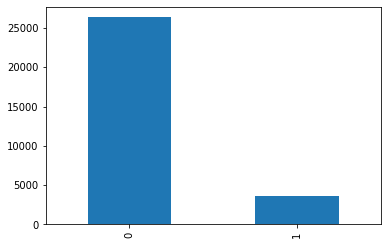

In [98]:
train_df_new['is_worker'].value_counts(dropna=True).plot(kind='bar')

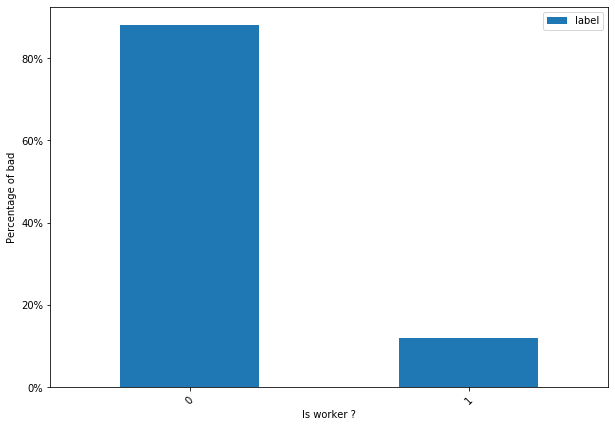

In [95]:
fig, ax = plt.subplots(figsize=(10,7))
bad_count = train_df_new[train_df_new['label'] == 1].label.count()
temp = train_df_new.groupby("is_worker").agg({
    'label': lambda x: (x==1).sum() * 100 / bad_count
})
temp.plot(kind='bar', ax=ax)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_xlabel('Is worker ?')
ax.set_ylabel('Percentage of bad')
ax.xaxis.set_tick_params(rotation=45)

In [25]:
new_cols = ['n_missing', 'bin_sum', 'bin_diff']

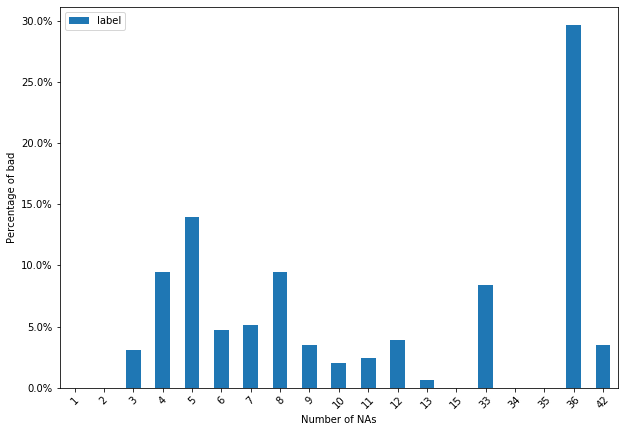

In [245]:
fig, ax = plt.subplots(figsize=(10,7))
bad_count = train_df_new[train_df_new['label'] == 1].label.count()
temp = train_df_new.groupby("n_missing").agg({
    'label': lambda x: (x==1).sum() * 100 / bad_count
})
temp.plot(kind='bar', ax=ax)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_xlabel('Number of NAs')
ax.set_ylabel('Percentage of bad')
ax.xaxis.set_tick_params(rotation=45)

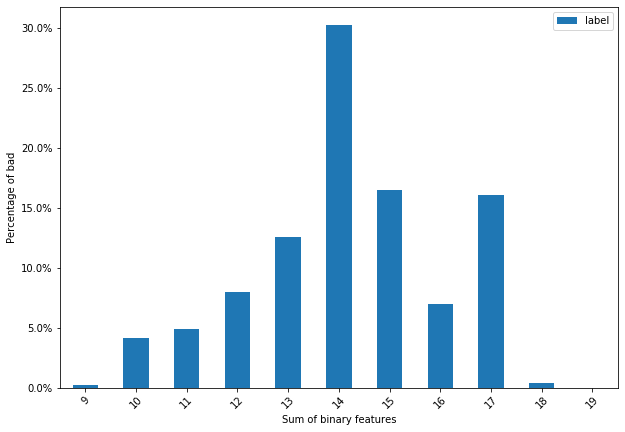

In [246]:
fig, ax = plt.subplots(figsize=(10,7))
bad_count = train_df_new[train_df_new['label'] == 1].label.count()
temp = train_df_new.groupby("bin_sum").agg({
    'label': lambda x: (x==1).sum() * 100 / bad_count
})
temp.plot(kind='bar', ax=ax)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_xlabel('Sum of binary features')
ax.set_ylabel('Percentage of bad')
ax.xaxis.set_tick_params(rotation=45)

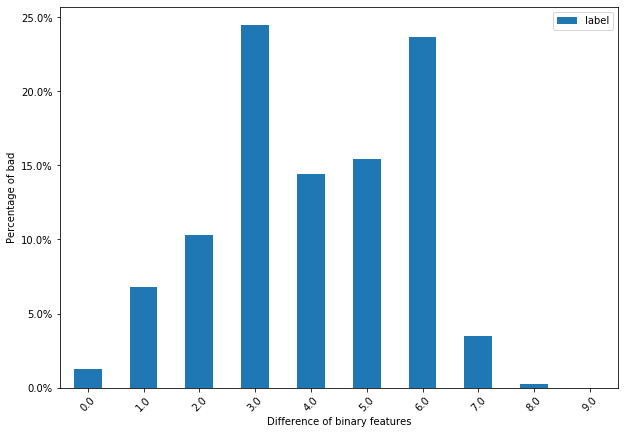

In [281]:
fig, ax = plt.subplots(figsize=(10,7))
bad_count = train_df_new[train_df_new['label'] == 1].label.count()
temp = train_df_new.groupby("bin_diff").agg({
    'label': lambda x: (x==1).sum() * 100 / bad_count
})
temp.plot(kind='bar', ax=ax)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_xlabel('Difference of binary features')
ax.set_ylabel('Percentage of bad')
ax.xaxis.set_tick_params(rotation=45)

## Baseline model comparison

In [83]:
train_df_new = train_df.copy()
to_drop = [
    "age_source2",
    "field_14",
    "field_52",
    "field_56",
    "field_18",
    "field_19",
    "field_27",
    "field_50",
    "field_51",
    "field_57",
]
cat_cols = [
    "province",
    "district",
    "macv",
    "field_7",
    "field_8",
    "field_9",
    "field_10",
    "field_12",
    "field_13",
    "field_17",
    "field_24",
    "field_35",
    "field_39",
    "field_40",
    "field_41",
    "field_42",
    "field_43",
    "field_44",
    "field_45",
]
ind_cols = ["field_4", "field_5", "field_6", "field_11", "field_16", "field_21"]
bin_cols = [
    "field_1",
    "field_2",
    "field_15",
    "field_20",
    "field_23",
    "field_25",
    "field_26",
    "field_28",
    "field_29",
    "field_30",
    "field_31",
    "field_32",
    "field_33",
    "field_34",
    "field_36",
    "field_37",
    "field_38",
    "field_46",
    "field_47",
    "field_48",
    "field_49",
]
bin_cols += ["field_14", "field_18", "field_19", "field_27"]
num_cols = ["age_source1", "field_3", "field_22", "field_53", "field_54", "field_55"]
num_cols += ["age_source2", "field_50", "field_51", "field_52", "field_56", "field_57"]
features = cat_cols + ind_cols + bin_cols + num_cols
# Fill 'None' with NaNs
for c in train_df_new.columns:
    train_df_new.loc[train_df_new[c] == "None", c] = np.nan

for c in features:
    if (c in cat_cols or c in bin_cols or c in ind_cols) and (
        train_df_new[c].dtype.kind in "fi"
    ):
        train_df_new[c] = train_df_new[c].astype("object")

# Fix age
train_df_new["age_source"] = np.where(
    train_df_new["age_source2"] == train_df_new["age_source1"],
    train_df_new["age_source1"],
    np.nan,
)

# Fix some fields
train_df_new.loc[train_df_new["field_3"] == -1, "field_3"] = np.nan
train_df_new.loc[
    train_df_new["field_9"].isin(["na", "79", "75", "80", "86"]), "field_9"
] = np.nan

# Fix typos
train_df_new = handle_category_typo(train_df_new)

# New feature: number of nans
train_df_new["n_missing"] = train_df_new.isna().sum(axis=1)
num_cols.append("n_missing")
features.append("n_missing")

# Remove rows with more than 20 nans
# train_df_new = train_df_new.query("n_missing < 20").copy()
# train_df_new.drop(columns=nan_cols, inplace=True)
# features = [f for f in features if f not in nan_cols]
# cat_cols = [f for f in cat_cols if f not in nan_cols]

# Handling binary cols
new_bin_cols = []
for c in bin_cols:
    if train_df_new[c].isna().sum() > 0:
        if train_df_new[c].isna().mean() < 0.1:
            train_df_new[c] = train_df_new[c].fillna(train_df_new[c].mode()[0])
            new_bin_cols.append(c)
            train_df_new[c] = train_df_new[c].astype("bool")
        else:
            #             train_df_new[c] = train_df_new[c].astype("bool").astype("int")
            #             train_df_new[c] = train_df_new[c].fillna(train_df_new[c].mean())
            train_df_new[c] = train_df_new[c].fillna("undefined")
            cat_cols.append(c)
    #             num_cols.append(c)
    else:
        new_bin_cols.append(c)
        train_df_new[c] = train_df_new[c].astype("bool")

# train_df_new.macv = train_df_new.macv.str.lower()

for c in features:
    #     print(c)
    if c in cat_cols or c in ind_cols:
        if train_df_new[c].isna().mean() < 0.1:
            train_df_new[c].fillna(train_df_new[c].mode()[0], inplace=True)
        else:
            train_df_new[c].fillna("undefined", inplace=True)
            train_df_new[c] = train_df_new[c].astype(str)
        #         if c == 'macv':
        #             pattern = "(^cn\s)|(công nhân)"
        #             train_df_new['is_worker'] = np.where(train_df_new[c].str.contains(pattern), 1, 0)
        #             features.append('is_worker')
        le = LabelEncoder()
        le.fit(train_df_new[c].astype(str))
        train_df_new[c] = le.transform(train_df_new[c].astype(str))
    elif c in num_cols:
        train_df_new[c].fillna(train_df_new[c].median(), inplace=True)

# New feature: Sum of binary
train_df_new["bin_sum"] = train_df_new[new_bin_cols].sum(axis=1)
features.append("bin_sum")
num_cols.append("bin_sum")

# New features: Differences measure for binary feature
# Reference row for binary features
bin_ref = train_df_new[new_bin_cols].copy()
bin_ref_med = bin_ref.median(axis=0).to_frame().T
bin_ref_med = pd.DataFrame(
    bin_ref_med.values.repeat(train_df_new.shape[0], axis=0),
    columns=bin_ref_med.columns,
)
# Calculate the difference
train_df_new["bin_diff"] = (
    train_df_new[new_bin_cols].subtract(bin_ref_med).abs().sum(axis=1)
)
features.append("bin_diff")
num_cols.append("bin_diff")

# Mean of 2 age sources
# train_df_new["mean_age"] = train_df_new[["age_source1", "age_source2"]].mean(axis=1)

# Count of categorical variables
count = 0
for c in ind_cols:
    if count == 0:
        train_df_new["new_ind"] = train_df_new[c].astype(str) + "_"
        count += 1
    else:
        train_df_new["new_ind"] += train_df_new[c].astype(str) + "_"
# train_df_new = cat_count_features(train_df_new, cat_cols + ['new_ind']).drop(columns=['new_ind'])
train_df_new, cat_count_cols = cat_count_features(
    train_df_new, ["new_ind", "field_7", "province", "district", "macv", "field_13"]
)
train_df_new = train_df_new.drop(columns=["new_ind"])

In [59]:
# Ranking cols
train_df_new, rank_cols = rank_features(
    train_df_new, ["field_22", "field_51", "field_3"]
)
# Fractional cols
train_df_new, fractional_cols = fractional_features(
    train_df_new,
    ["field_50", "field_51", "field_52", "field_53", "field_54", "field_55"],
)

group_cols = ["district", "field_7", "province"]
agg_cols = [
    "field_3",
    "age_source2",
    "field_22",
    #     "field_50",
    #     "field_51",
    #     "field_52",
    #     "field_53",
    #     "field_54",
    #     "field_55",
]

# Agg features
# train_df_new, agg_ft = aggregate_features(train_df_new, group_cols, agg_cols)

# Interaction features
# feature_set = ["age_source1", "age_source2", "field_3", "field_22"]
# train_df_new, inter_cols = interact_features(train_df_new, feature_set)

In [84]:
X, y = train_df_new.drop(columns=["id", "label"]).copy(), train_df_new["label"].copy()

In [85]:
X

,province,district,age_source1,age_source2,macv,field_1,field_2,field_3,field_4,field_5,field_6,field_7,field_8,field_9,field_10,field_11,field_12,field_13,field_14,field_15,field_16,field_17,field_18,field_19,field_20,field_21,field_22,field_23,field_24,field_25,field_26,field_27,field_28,field_29,field_30,field_31,field_32,field_33,field_34,field_35,field_36,field_37,field_38,field_39,field_40,field_41,field_42,field_43,field_44,field_45,field_46,field_47,field_48,field_49,field_50,field_51,field_52,field_53,field_54,field_55,field_56,field_57,age_source,n_missing,bin_sum,bin_diff,new_ind_count,field_7_count,province_count,district_count,macv_count,field_13_count
0,64,699,31.0,31.0,2522,True,True,2547.0,0,0,0,7087,2,31,2,44,4,227,True,True,5,7,2,2,2,3,23.0,1,3,2,2,2,2,2,2,1,True,True,True,5,2,2,2,44,8,5,2,6,2,2,False,True,True,True,29.77,33.650,30.955,31.171,0.0,0.11,0.0,0.0,NaN,47,10,4.0,8058,13093,12818,12849,22896,9700
1,62,570,44.0,44.0,2522,True,False,2187.0,1,1,1,3557,1,9,1,4,4,25,False,False,1,4,1,1,1,1,4.0,0,3,0,0,1,1,2,2,1,False,True,False,4,0,1,0,42,8,4,1,6,0,0,False,False,False,True,29.77,17.561,30.955,31.171,0.0,0.04,0.0,0.0,44.0,9,3,3.0,2,21,1033,322,22896,4857
2,62,185,30.0,30.0,331,False,True,3273.0,1,9,0,1745,0,6,1,4,0,225,False,False,0,7,0,0,0,1,54.0,0,3,1,1,1,1,0,0,0,False,True,True,4,0,1,0,44,8,0,1,6,1,1,True,True,True,True,29.77,56.512,30.955,31.171,0.0,0.16,0.0,0.0,30.0,5,7,3.0,262,2,1033,113,1389,4976
3,54,627,43.0,31.0,2522,False,True,3991.0,1,1,0,354,2,31,2,44,4,227,True,True,5,7,2,2,2,3,23.0,1,3,2,2,2,2,2,2,1,True,True,True,5,2,2,2,44,8,5,2,6,2,2,False,False,True,False,29.77,33.650,30.955,31.171,0.0,0.11,0.0,0.0,NaN,44,7,7.0,47,1,83,21,22896,9700
4,3,520,21.0,21.0,2522,False,True,1450.0,0,7,0,5733,1,9,1,4,4,25,False,False,0,4,1,1,1,1,24.0,0,3,0,0,1,1,2,2,1,False,True,False,4,0,1,0,44,8,4,1,6,0,0,True,True,True,True,29.77,13.789,30.955,31.171,0.0,0.03,0.0,0.0,21.0,9,6,2.0,362,11,2389,50,22896,4857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,41,295,28.0,28.0,2522,False,True,720.0,3,11,0,5529,0,6,1,0,0,200,False,False,0,7,1,0,0,1,36.0,0,3,1,0,1,1,0,1,0,False,False,False,0,0,1,0,42,8,0,1,6,0,0,False,True,True,True,29.77,33.503,30.955,31.171,0.0,0.11,0.0,0.0,28.0,5,4,2.0,36,1,102,10,22896,239
29996,62,86,34.0,34.0,1667,False,True,3627.0,0,13,2,4676,1,6,0,36,0,205,False,False,0,7,0,0,0,1,104.0,0,3,1,1,1,1,0,0,0,False,True,False,0,0,1,0,44,8,0,1,6,0,0,True,True,True,True,29.77,41.194,30.955,31.171,0.0,0.13,0.0,0.0,34.0,5,6,2.0,1,1,1033,48,449,177
29997,18,175,29.0,31.0,2522,True,True,3651.0,3,1,0,5366,2,31,2,44,4,227,True,True,5,7,2,2,2,3,23.0,1,3,2,2,2,2,2,2,1,True,True,True,5,2,2,2,44,8,5,2,6,2,2,False,True,True,True,29.77,33.650,30.955,31.171,0.0,0.11,0.0,0.0,NaN,44,10,4.0,23,17,109,5,22896,9700
29998,1,13,39.0,39.0,2522,True,False,2187.0,3,7,0,434,0,4,1,4,0,10,False,False,0,7,1,0,0,1,24.0,0,3,1,0,1,1,0,0,0,False,False,False,4,0,1,0,42,8,3,1,6,0,0,True,False,False,True,29.77,21.478,30.955,31.171,0.0,0.05,0.0,0.0,39.0,6,3,5.0,559,8,667,30,22896,43


In [86]:
# xgb_param = {
#     'colsample_bytree': 0.35471131556781954,
#     'n_jobs': -1,
#     'min_child_weight': 1,
#     'gamma': 1,
#     'subsample': 0.858185399525955,
#     'max_depth': 5,
#     'n_estimators': 1219,
#     'learning_rate': 0.10311333973796769,
#     'grow_policy': 'depthwise',
# }
xgb_params = {
    "n_jobs": -1,
    "colsample_bytree": 0.511182194059105,
    "min_child_weight": 5,
    "gamma": 0,
    "subsample": 0.7937217003281334,
    "max_depth": 5,
    "n_estimators": 231,
    "learning_rate": 0.044806747122933484,
}
# xgb_params = {
#     'n_jobs': -1,
#     'colsample_bytree': 0.6416885173465622,
#     'min_child_weight': 5,
#     'gamma': 0,
#     'subsample': 0.9610568300971172,
#     'max_depth': 7,
#     'n_estimators': 447,
#     'learning_rate': 0.019177795349459268
# }
# encoder = ce.BackwardDifferenceEncoder(cols=obj_cols + bin_cols)
# encoder = ce.BaseNEncoder(cols=obj_cols + bin_cols)
# encoder = ce.BinaryEncoder(cols=obj_cols + bin_cols)
# encoder = ce.CatBoostEncoder(cols=obj_cols + bin_cols)
# encoder = ce.HashingEncoder(cols=obj_cols + bin_cols)
# encoder = ce.HelmertEncoder(cols=obj_cols + bin_cols)
# encoder = ce.JamesSteinEncoder(cols=obj_cols + bin_cols)
# encoder = ce.LeaveOneOutEncoder(cols=obj_cols + bin_cols)
# encoder = ce.MEstimateEncoder(cols=obj_cols + bin_cols)
# encoder = ce.OneHotEncoder(cols=obj_cols + bin_cols)
# encoder = ce.OrdinalEncoder(cols=cat_cols + bin_cols + ind_cols)
# encoder = ce.SumEncoder(cols=obj_cols + bin_cols)
# encoder = ce.PolynomialEncoder(cols=obj_cols + bin_cols)
# encoder = ce.TargetEncoder(cols=cat_cols + bin_cols + ind_cols)
# encoder = ce.WOEEncoder(cols=obj_cols + bin_cols)
vote1 = VotingClassifier(
    [
        ("lr", LogisticRegression()),
        #     ('xgb', xgb.XGBClassifier(**xgb_param))
    ],
    voting="soft",
    weights=[0.5, 0.5],
)
estimators = [
    #     ('et', ExtraTreesClassifier(n_estimators=100, max_features='auto', n_jobs=-1)),
    ("xgb", xgb.XGBClassifier(**xgb_params)),
    #     ('cb', cb.CatBoostClassifier(leaf_estimation_method ='Newton', learning_rate=0.057, l2_leaf_reg = 23, depth=6, od_pval=0.0000001, iterations = 877, loss_function='Logloss')),
    #     ('cb', cb.CatBoostClassifier()),
    #     ("lr", LogisticRegression()),
    #     ('Ridge', RidgeClassifier()),
    #     ('lsvc', LinearSVC()),
    #     ('svc', SVC(probability=True)),
    #     ('mlp', MLPClassifier(max_iter=500)),
    #     ('vote1', vote1),
    #     ('vote2', vote2)
]
# Create folds
print(X.shape)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for name, clf in estimators:
    print(f"{name}:")
    pipe = Pipeline(
        [
            #         ('cat_enc', encoder),
            #         ('scale', StandardScaler()),
            #         ('pca', PCA(svd_solver='auto')),
            ("classifier", clf)
        ],
        verbose=False,
    )
    #     score = cross_validate(pipe, X[features], y, scoring=skgini, cv=cv, n_jobs=1,  method='predict_proba', verbose=False)
    scores = []
    auc_scores = []
    for i, (train_index, test_index) in enumerate(folds):
        Xtrain, Xtest = (
            X.iloc[train_index].copy().reset_index(drop=True),
            X.iloc[test_index].copy().reset_index(drop=True),
        )
        ytrain, ytest = (
            y[train_index].copy().reset_index(drop=True),
            y[test_index].copy().reset_index(drop=True),
        )
        #         sm = SMOTE(random_state=12, ratio = 1.0)
        #         X_train, y_train = sm.fit_sample(X_train, y_train)
        if name != "xgb" and name != "cb":  # then scale
            scaled_ft = StandardScaler().fit_transform(Xtrain[num_cols])
            test_scaled_ft = StandardScaler().fit_transform(Xtest[num_cols])
            Xtrain[num_cols], Xtest[num_cols] = scaled_ft, test_scaled_ft
        if name == "cb":
            clf.fit(Xtrain, ytrain, silent=True, eval_set=(Xtest, ytest))
        elif name == "xgb":
            clf.fit(
                Xtrain,
                ytrain,
                verbose=False,
                eval_set=[(Xtrain, ytrain), (Xtest, ytest)],
                eval_metric=gini_xgb,
                early_stopping_rounds=100,
            )
        else:
            clf.fit(Xtrain, ytrain)
        ypred = clf.predict_proba(Xtest)[:, 1].round(5)
        # print(ypred)
        score = gini(ytest, ypred)
        auc = roc_auc_score(ytest, ypred)
        max_score = gini(ytest, ytest)
        print(f"\tScore: {score} | max score: {max_score} | AUC: {auc}")
        scores.append(score)
        auc_scores.append(auc)
    print(f"\tMean score: {np.mean(scores)} | Mean AUC: {np.mean(auc_scores)}")
#     print(f" Gini: {score['test_skgini'].mean()}")
#     print(f" ROC: {score['test_roc_auc'].mean()}")

(30000, 72)
xgb:
	Score: 0.1347462497746974 | max score: 0.4918346942176304 | AUC: 0.6373246740674925
	Score: 0.1149561855670103 | max score: 0.49191666666666667 | AUC: 0.6178764598116282
	Score: 0.142196735395189 | max score: 0.49191666666666667 | AUC: 0.6442242368461957
	Score: 0.11145446735395187 | max score: 0.49191666666666667 | AUC: 0.6076990382314776
	Score: 0.1279783744026066 | max score: 0.49191531921987 | AUC: 0.6297716657292478
	Mean score: 0.12626640249869103 | Mean AUC: 0.6273792149372083


### Feature importance

In [63]:
# encoder = ce.OrdinalEncoder(cols=cat_cols + bin_cols + ind_cols)
xgb_params = {
    "n_jobs": -1,
    "colsample_bytree": 0.511182194059105,
    "min_child_weight": 5,
    "gamma": 0,
    "subsample": 0.7937217003281334,
    "max_depth": 5,
    "n_estimators": 231,
    "learning_rate": 0.044806747122933484,
}
clf = xgb.XGBClassifier(**xgb_params)
# clf = xgb.XGBClassifier(n_jobs=-1)
pipe = Pipeline(
    [
        #     ('cat_enc', encoder),
        #         ('scale', StandardScaler()),
        #         ('pca', PCA(svd_solver='auto')),
        ("classifier", clf)
    ],
    verbose=False,
)
# encoder.fit(X, y)
# X_transformed = encoder.transform(X)
clf.fit(X, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.511182194059105, gamma=0,
              learning_rate=0.044806747122933484, max_delta_step=0, max_depth=5,
              min_child_weight=5, missing=None, n_estimators=231, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.7937217003281334, verbosity=1)

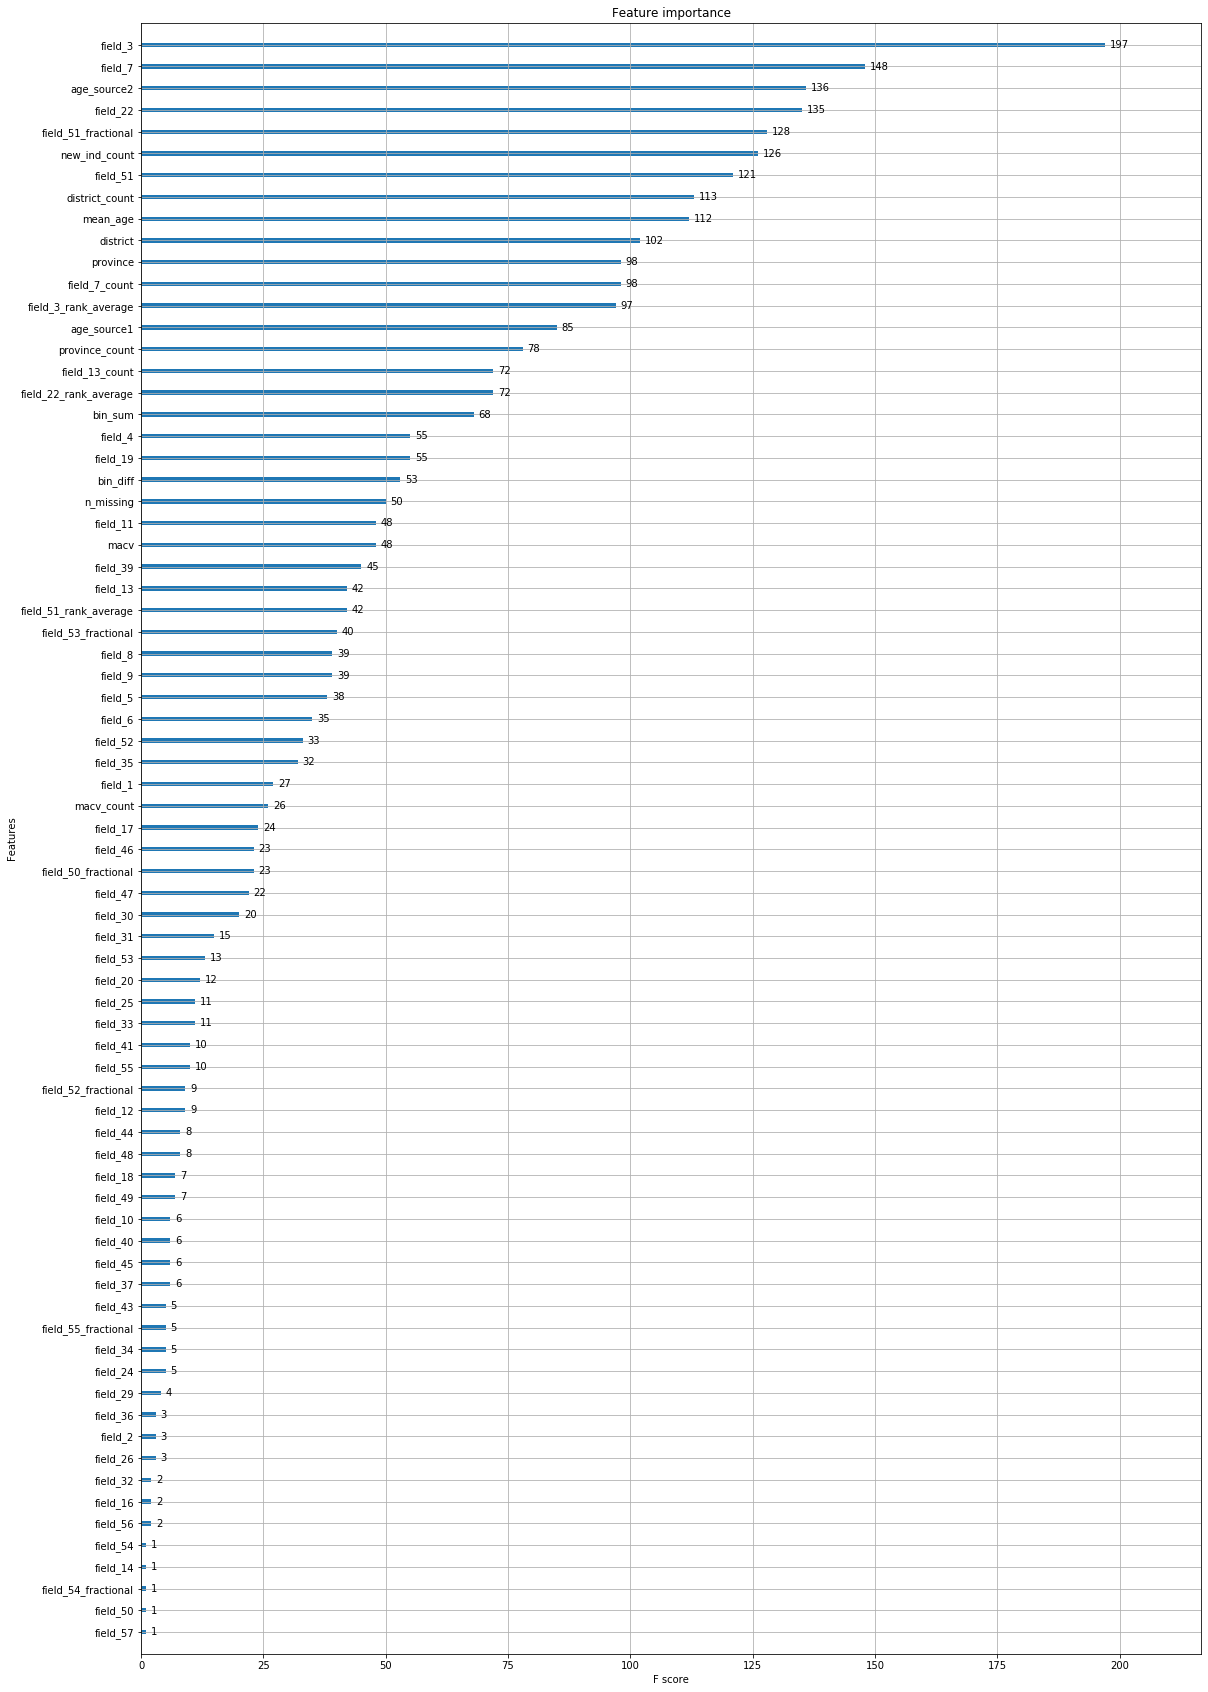

In [64]:
plt.rcParams["figure.figsize"] = (19, 30)
plot_importance(booster=clf)

In [39]:
num_cols

['age_source1',
 'field_3',
 'field_22',
 'field_53',
 'field_54',
 'field_55',
 'age_source2',
 'field_50',
 'field_51',
 'field_52',
 'field_56',
 'field_57',
 'n_missing',
 'n_missing',
 'bin_sum',
 'bin_diff']

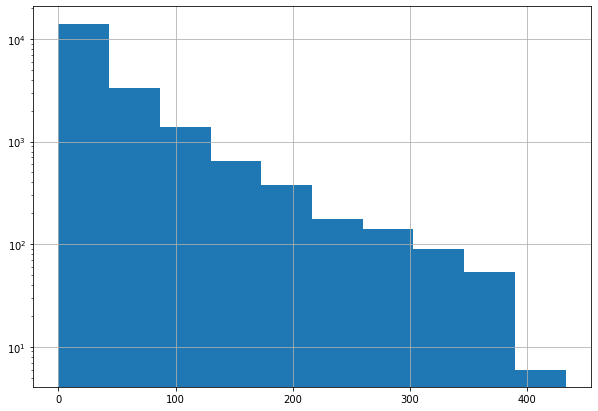

In [198]:
fig,ax = plt.subplots(1,1,figsize=(10,7))
ax.set_yscale('log')
train_df.field_22.hist(ax=ax)

### Feature selection

In [93]:
np.random.seed()

In [94]:
rfc = RandomForestClassifier(n_estimators=200, max_features='sqrt', max_depth=20, n_jobs=-1)
fold = 5
step = 2
rfecv = RFECV(
              estimator=rfc,
              step=step,
              cv=StratifiedKFold(
                                 n_splits=5,
                                 shuffle=False,
                                 random_state=1001),
              scoring='roc_auc',
              n_jobs=1,
              verbose=2)

In [95]:
starttime = timer(None)
start_time = timer(None)
rfecv.fit(X_agg, y)
timer(start_time)

Fitting estimator with 110 features.
Fitting estimator with 108 features.
Fitting estimator with 106 features.
Fitting estimator with 104 features.
Fitting estimator with 102 features.
Fitting estimator with 100 features.
Fitting estimator with 98 features.
Fitting estimator with 96 features.
Fitting estimator with 94 features.
Fitting estimator with 92 features.
Fitting estimator with 90 features.
Fitting estimator with 88 features.
Fitting estimator with 86 features.
Fitting estimator with 84 features.
Fitting estimator with 82 features.
Fitting estimator with 80 features.
Fitting estimator with 78 features.
Fitting estimator with 76 features.
Fitting estimator with 74 features.
Fitting estimator with 72 features.
Fitting estimator with 70 features.
Fitting estimator with 68 features.
Fitting estimator with 66 features.
Fitting estimator with 64 features.
Fitting estimator with 62 features.
Fitting estimator with 60 features.
Fitting estimator with 58 features.
Fitting estimator with

In [96]:
all_ft = X_agg.columns
all_ft

Index(['province', 'district', 'age_source1', 'age_source2', 'macv', 'field_1', 'field_2', 'field_3', 'field_4', 'field_5',
       ...
       'agg_province_age_source2_mean', 'agg_province_age_source2_median', 'agg_province_age_source2_min', 'agg_province_age_source2_max', 'agg_province_age_source2_std', 'agg_province_field_22_mean', 'agg_province_field_22_median', 'agg_province_field_22_min', 'agg_province_field_22_max', 'agg_province_field_22_std'], dtype='object', length=110)

In [97]:
len(rfecv.support_)

110

In [98]:
print('\n Optimal number of features: %d' % rfecv.n_features_)
sel_features = [f for f, s in zip(all_ft, rfecv.support_) if s]
print('\n The selected features are {}:'.format(sel_features))


 Optimal number of features: 104

 The selected features are ['province', 'district', 'age_source1', 'age_source2', 'macv', 'field_1', 'field_2', 'field_3', 'field_4', 'field_5', 'field_6', 'field_7', 'field_8', 'field_9', 'field_10', 'field_11', 'field_12', 'field_13', 'field_14', 'field_15', 'field_16', 'field_17', 'field_18', 'field_19', 'field_20', 'field_21', 'field_22', 'field_24', 'field_25', 'field_26', 'field_27', 'field_28', 'field_29', 'field_32', 'field_33', 'field_34', 'field_35', 'field_38', 'field_39', 'field_40', 'field_41', 'field_42', 'field_43', 'field_44', 'field_45', 'field_46', 'field_47', 'field_48', 'field_49', 'field_50', 'field_51', 'field_52', 'field_53', 'field_54', 'field_55', 'field_56', 'field_57', 'n_missing', 'bin_sum', 'bin_diff', 'agg_district_field_3_mean', 'agg_district_field_3_median', 'agg_district_field_3_min', 'agg_district_field_3_max', 'agg_district_field_3_std', 'agg_district_age_source2_mean', 'agg_district_age_source2_median', 'agg_distric

## Categorical embedding

### Create embeddings

In [136]:
train_df_em = train_df.copy()
test_df_em = test_df.copy()
df_em = pd.concat((train_df_em, test_df_em), ignore_index=True)

In [137]:
cat_cols = ['province', 'district', 'macv', 'field_7', 'field_8', 'field_9', 'field_10', 'field_12', 'field_13',
            'field_17', 'field_24', 'field_35', 'field_39', 'field_40', 'field_41', 'field_42', 'field_43', 'field_44', 'field_45']
ind_cols = ['field_4', 'field_5', 'field_6', 'field_11', 'field_16', 'field_21']
bin_cols = ['field_1', 'field_2', 'field_15', 'field_20', 'field_23', 'field_25', 'field_26', 'field_28', 'field_29', 'field_30', 'field_31', 'field_32', 'field_33', 'field_34',
           'field_36' , 'field_37', 'field_38', 'field_46', 'field_47', 'field_48', 'field_49']
bin_cols += ['field_14', 'field_18', 'field_19', 'field_27']
num_cols = ['age_source1', 'field_3', 'field_22', 'field_53', 'field_54', 'field_55']
num_cols += ['age_source2', 'field_50', 'field_51', 'field_52', 'field_56', 'field_57']
features = cat_cols + ind_cols + bin_cols + num_cols
# Fill 'None' with NaNs
for c in df_em.columns:
    df_em.loc[df_em[c] == 'None', c] = np.nan
    
for c in features:
    if (c in cat_cols or c in bin_cols or c in ind_cols) and (df_em[c].dtype.kind in 'fi'):
        df_em[c] = df_em[c].astype('object')
        
# New feature: number of nans
df_em['n_missing'] = df_em.isna().sum(axis=1)
num_cols.append('n_missing')
features.append('n_missing')
num_cols.append('n_missing')

# Handling binary cols
new_bin_cols = []
for c in bin_cols:
    if df_em[c].isna().sum() > 0:
        if df_em[c].isna().min() < 0.1:
            df_em[c] = df_em[c].fillna(df_em[c].mode()[0])
            new_bin_cols.append(c)
            df_em[c] = df_em[c].astype('bool')
        else:
            df_em[c] = df_em[c].fillna('undefined')
            cat_cols.append(c)
    else:
        new_bin_cols.append(c)
        df_em[c] = df_em[c].astype('bool')
        
df_em.macv = df_em.macv.str.lower()

for c in features:
#     print(c)
    if c in cat_cols or c in ind_cols:
        if df_em[c].isna().mean() < 0.1:
            df_em[c].fillna(df_em[c].mode()[0], inplace=True)
        else:
            df_em[c].fillna('undefined', inplace=True)
            df_em[c] = df_em[c].astype(str)
#         le = LabelEncoder()
#         le.fit(df_em[c].astype(str))
#         df_em[c] = le.transform(df_em[c].astype(str))
    elif c in num_cols:
        df_em[c].fillna(df_em[c].median(), inplace=True)
        
# New feature: Sum of binary
df_em['bin_sum'] = df_em[new_bin_cols].sum(axis=1)
features.append('bin_sum')
num_cols.append('bin_sum')

# New features: Differences measure for binary feature
# Reference row for binary features
bin_ref = df_em[new_bin_cols].copy()
bin_ref_med = bin_ref.median(axis=0).to_frame().T
bin_ref_med = pd.DataFrame(bin_ref_med.values.repeat(df_em.shape[0], axis=0), columns=bin_ref_med.columns)
# Calculate the difference
df_em['bin_diff'] = df_em[new_bin_cols].subtract(bin_ref_med).abs().sum(axis=1)
features.append('bin_diff')
num_cols.append('bin_diff')

pattern = "(^cn\s)|(công nhân)"
df_em['is_worker'] = np.where(df_em.macv.str.contains(pattern), 1, 0)
features.append('is_worker')

/usr/local/lib64/python3.7/site-packages/pandas/core/strings.py:1843: UserWarning:

This pattern has match groups. To actually get the groups, use str.extract.



In [138]:
cat_ft = ['province', 'district', 'macv', 'field_7', 'field_8', 'field_9', 'field_10', 'field_11', 'field_12', 'field_13', 'field_16', 'field_17', 'field_21', 'field_24', 'field_35', 'field_39', 'field_40', 'field_41', 'field_42', 'field_43', 'field_44', 'field_45']
to_embed = ['province', 'district', 'macv']
for c in cat_ft:
    if c not in to_embed: # label encode
        le = LabelEncoder()
        le.fit(df_em[c].astype(str))
        df_em[c] = le.transform(df_em[c].astype(str))

In [123]:
# Drop field_7
df_em = df_em.drop(columns=['field_7'])

In [139]:
X_em = df_em[df_em['id'] < 30000].drop(columns=['id', 'label']).copy()
X_em_test = df_em[df_em['id'] >= 30000].drop(columns=['id', 'label']).copy()

In [140]:
scaled_ft = StandardScaler().fit_transform(X_em[num_cols])
X_em[num_cols] = scaled_ft
test_scaled_ft = StandardScaler().fit_transform(X_em_test[num_cols])
X_em_test[num_cols] = test_scaled_ft

In [141]:
y_em = df_em[df_em['id'] < 30000].label.copy()

In [40]:
X_em_train, X_em_test, y_em_train, y_em_test = train_test_split(X_em, y_em, random_state=42, test_size=0.2)

In [142]:
cat_vars = preprocessing.categorize(df_em)

In [143]:
cat_vars

[('district', 746), ('macv', 3905), ('province', 66)]

In [144]:
cat_ft = [cat_vars[i][0] for i in range(len(cat_vars))]

In [145]:
emb_dims=[5, 1, 2, 1, 4, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 10, 1, 2, 7, 2]
emb_dims = [5, 6, 3]

In [146]:
emb_sz = preprocessing.pick_emb_dim(
    cat_vars,
    max_dim=10,
#     emb_dims=[5, 7, 8, 10, 1, 2, 1, 3, 1, 4, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1],
    emb_dims=emb_dims,
    include_unseen=False
)

In [147]:
%%time
X_train_encoded, encoders = preprocessing.encode_categorical(X_em, X_em)
X_test_encoded, test_encoders = preprocessing.encode_categorical(X_em_test, X_em,)

CPU times: user 5.68 s, sys: 19.3 ms, total: 5.7 s
Wall time: 5.7 s


In [148]:
%%time
embedder = Embedder(emb_sz, loss='binary_crossentropy', hiddens=[64,32], dropout=0.1, activation='relu')
es = EarlyStopping(monitor='val_loss', mode='min', patience=4, verbose=1)

CPU times: user 47 µs, sys: 0 ns, total: 47 µs
Wall time: 63.2 µs


In [149]:
%%time
embedder.fit(X_train_encoded, y_em, epochs=25, batch_size=32, verbose=1, early_stop=es, )

/usr/local/lib64/python3.7/site-packages/keras/callbacks/callbacks.py:998: UserWarning:

`epsilon` argument is deprecated and will be removed, use `min_delta` instead.

/usr/local/lib64/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning:

Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.



Train on 24000 samples, validate on 6000 samples
Epoch 1/25
24000/24000 [==============================] - ETA: 6:47 - loss: 0.710 - ETA: 33s - loss: 0.662 - ETA: 20s - loss: 0.62 - ETA: 15s - loss: 0.59 - ETA: 12s - loss: 0.56 - ETA: 10s - loss: 0.53 - ETA: 9s - loss: 0.5062 - ETA: 8s - loss: 0.480 - ETA: 7s - loss: 0.458 - ETA: 7s - loss: 0.432 - ETA: 6s - loss: 0.411 - ETA: 6s - loss: 0.391 - ETA: 5s - loss: 0.373 - ETA: 5s - loss: 0.359 - ETA: 5s - loss: 0.343 - ETA: 5s - loss: 0.328 - ETA: 4s - loss: 0.314 - ETA: 4s - loss: 0.302 - ETA: 4s - loss: 0.290 - ETA: 4s - loss: 0.281 - ETA: 4s - loss: 0.272 - ETA: 3s - loss: 0.267 - ETA: 3s - loss: 0.259 - ETA: 3s - loss: 0.250 - ETA: 3s - loss: 0.245 - ETA: 3s - loss: 0.240 - ETA: 3s - loss: 0.234 - ETA: 3s - loss: 0.230 - ETA: 3s - loss: 0.227 - ETA: 2s - loss: 0.221 - ETA: 2s - loss: 0.215 - ETA: 2s - loss: 0.211 - ETA: 2s - loss: 0.207 - ETA: 2s - loss: 0.202 - ETA: 2s - loss: 0.199 - ETA: 2s - loss: 0.196 - ETA: 2s - loss: 0.194 - E

Embedder({'input_dim': {'district': 746, 'macv': 3905, 'province': 66}, 'emb_dim': {'district': 5, 'macv': 6, 'province': 3}, 'categorical': dict_keys(['district', 'macv', 'province']), 'model': <keras.engine.training.Model object at 0x7ff1143bd7d0>})

In [150]:
embeddings = None
if embeddings is None:
    embeddings = embedder.get_embeddings()
else:
    new_embeddings = embedder.get_embeddings()
    for c, e in embeddings.items():
        embeddings[c] += new_embeddings[c]

In [151]:
len(cat_ft)

3

In [152]:
%%time
for c in tqdm(cat_ft):
    embed_matrix = embeddings[c]
    entity_list = encoders[c].classes_
    ft_df = get_embedding_df(embed_matrix, entity_list, colname=c, prefix=c)
    ft_df.to_csv("embeddings/{}_embedding.csv".format(c), index=False)

100%|██████████| 3/3 [00:00<00:00, 12.44it/s]


CPU times: user 101 ms, sys: 19 ms, total: 120 ms
Wall time: 247 ms


### Load embeddings

In [163]:
train_df_new = train_df.copy()
to_drop = ['age_source2', 'field_14', 'field_52', 'field_56', 'field_18', 'field_19', 'field_27', 'field_50', 'field_51', 'field_57']
cat_cols = ['province', 'district', 'macv', 'field_7', 'field_8', 'field_9', 'field_10', 'field_12', 'field_13',
            'field_17', 'field_24', 'field_35', 'field_39', 'field_40', 'field_41', 'field_42', 'field_43', 'field_44', 'field_45']
ind_cols = ['field_4', 'field_5', 'field_6', 'field_11', 'field_16', 'field_21']
bin_cols = ['field_1', 'field_2', 'field_15', 'field_20', 'field_23', 'field_25', 'field_26', 'field_28', 'field_29', 'field_30', 'field_31', 'field_32', 'field_33', 'field_34',
           'field_36' , 'field_37', 'field_38', 'field_46', 'field_47', 'field_48', 'field_49']
bin_cols += ['field_14', 'field_18', 'field_19', 'field_27']
num_cols = ['age_source1', 'field_3', 'field_22', 'field_53', 'field_54', 'field_55']
num_cols += ['age_source2', 'field_50', 'field_51', 'field_52', 'field_56', 'field_57']
features = cat_cols + ind_cols + bin_cols + num_cols
# Fill 'None' with NaNs
for c in train_df_new.columns:
    train_df_new.loc[train_df_new[c] == 'None', c] = np.nan
    
for c in features:
    if (c in cat_cols or c in bin_cols or c in ind_cols) and (train_df_new[c].dtype.kind in 'fi'):
        train_df_new[c] = train_df_new[c].astype('object')
        
# New feature: number of nans
train_df_new['n_missing'] = train_df_new.isna().sum(axis=1)
num_cols.append('n_missing')
features.append('n_missing')
num_cols.append('n_missing')

# Handling binary cols
new_bin_cols = []
for c in bin_cols:
    if train_df_new[c].isna().sum() > 0:
        if train_df_new[c].isna().min() < 0.1:
            train_df_new[c] = train_df_new[c].fillna(train_df_new[c].mode()[0])
            new_bin_cols.append(c)
            train_df_new[c] = train_df_new[c].astype('bool')
        else:
            train_df_new[c] = train_df_new[c].fillna('undefined')
            cat_cols.append(c)
    else:
        new_bin_cols.append(c)
        train_df_new[c] = train_df_new[c].astype('bool')
        
train_df_new.macv = train_df_new.macv.str.lower()

for c in features:
#     print(c)
    if c in cat_cols or c in ind_cols:
        if train_df_new[c].isna().mean() < 0.1:
            train_df_new[c].fillna(train_df_new[c].mode()[0], inplace=True)
        else:
            train_df_new[c].fillna('undefined', inplace=True)
            train_df_new[c] = train_df_new[c].astype(str)
#         le = LabelEncoder()
#         le.fit(train_df_new[c].astype(str))
#         train_df_new[c] = le.transform(train_df_new[c].astype(str))
    elif c in num_cols:
        train_df_new[c].fillna(train_df_new[c].median(), inplace=True)
        
# New feature: Sum of binary
train_df_new['bin_sum'] = train_df_new[new_bin_cols].sum(axis=1)
features.append('bin_sum')
num_cols.append('bin_sum')

# New features: Differences measure for binary feature
# Reference row for binary features
bin_ref = train_df_new[new_bin_cols].copy()
bin_ref_med = bin_ref.median(axis=0).to_frame().T
bin_ref_med = pd.DataFrame(bin_ref_med.values.repeat(train_df_new.shape[0], axis=0), columns=bin_ref_med.columns)
# Calculate the difference
train_df_new['bin_diff'] = train_df_new[new_bin_cols].subtract(bin_ref_med).abs().sum(axis=1)
features.append('bin_diff')
num_cols.append('bin_diff')

pattern = "(^cn\s)|(công nhân)"
train_df_new['is_worker'] = np.where(train_df_new.macv.str.contains(pattern), 1, 0)
features.append('is_worker')

/usr/local/lib64/python3.7/site-packages/pandas/core/strings.py:1843: UserWarning:

This pattern has match groups. To actually get the groups, use str.extract.



In [164]:
cat_ft = ['province', 'district', 'macv', 'field_7', 'field_8', 'field_9', 'field_10', 'field_11', 'field_12', 'field_13', 'field_16', 'field_17', 'field_21', 'field_24', 'field_35', 'field_39', 'field_40', 'field_41', 'field_42', 'field_43', 'field_44', 'field_45']

In [165]:
to_embed = ['province', 'district', 'macv']

In [166]:
len(to_embed)

3

In [167]:
%%time
for c in tqdm(to_embed):
#     print(c)
    temp = pd.read_csv('embeddings/{}_embedding.csv'.format(c))
    temp = temp[temp[c] != 'undefined']
#     print(temp[c].dtype)
#     merged = pd.merge(train_df_new1[[c]], temp, how='left', on=c).fillna(0)
#     print(merged.head())
#     print(merged.shape)
    train_df_new = pd.merge(train_df_new, temp, on=c, how='left').fillna(0)
#     del temp, merged
#     gc.collect()

100%|██████████| 3/3 [00:00<00:00,  6.12it/s]


CPU times: user 486 ms, sys: 8.86 ms, total: 494 ms
Wall time: 512 ms


In [168]:
gc.collect()

129

In [170]:
for c in cat_ft:
    if c not in to_embed: # label encode
        le = LabelEncoder()
        le.fit(train_df_new[c].astype(str))
        train_df_new[c] = le.transform(train_df_new[c].astype(str))

In [171]:
train_df_new.drop(columns=to_embed, inplace=True)

In [172]:
X, y = train_df_new.drop(columns=['id', 'label']), train_df_new['label']

In [173]:
X

,age_source1,age_source2,field_1,field_2,field_3,field_4,field_5,field_6,field_7,field_8,field_9,field_10,field_11,field_12,field_13,field_14,field_15,field_16,field_17,field_18,field_19,field_20,field_21,field_22,field_23,field_24,field_25,field_26,field_27,field_28,field_29,field_30,field_31,field_32,field_33,field_34,field_35,field_36,field_37,field_38,field_39,field_40,field_41,field_42,field_43,field_44,field_45,field_46,field_47,field_48,field_49,field_50,field_51,field_52,field_53,field_54,field_55,field_56,field_57,n_missing,bin_sum,bin_diff,is_worker,province_0,province_1,province_2,district_0,district_1,district_2,district_3,district_4,macv_0,macv_1,macv_2,macv_3,macv_4,macv_5
0,31.0,31.0,True,True,2547.0,0.0,0.0,0.0,7087,2,35,2,44,4,227,True,True,5,7,True,False,False,3,23.0,True,3,True,False,True,True,True,True,True,True,True,True,5,True,True,False,44,8,5,2,6,2,2,False,True,True,True,29.77,33.650,30.955,31.171,0.0,0.11,0.0,0.0,45,20,4.0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,44.0,44.0,True,False,-1.0,1.0,1.0,1.0,3557,1,13,1,4,4,25,False,False,1,4,True,True,True,1,4.0,True,3,False,False,True,True,True,True,True,False,True,False,4,True,True,False,42,8,4,1,6,0,0,False,False,False,True,29.77,17.561,30.955,31.171,0.0,0.04,0.0,0.0,8,14,6.0,0,-0.388974,-0.378655,0.305889,-0.971507,-1.077170,-1.003200,0.920839,-0.706181,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,30.0,30.0,False,True,3273.0,1.0,4.0,0.0,1745,0,10,1,4,0,225,False,False,0,7,False,False,False,1,54.0,True,3,True,True,True,True,True,True,True,False,True,True,4,True,True,False,44,8,0,1,6,1,1,True,True,True,True,29.77,56.512,30.955,31.171,0.0,0.16,0.0,0.0,5,17,5.0,1,-0.388974,-0.378655,0.305889,-0.121303,-0.107017,-0.040590,-0.017359,-0.050261,0.138992,-0.147001,-0.220418,-0.130602,-0.123806,0.215530
3,43.0,31.0,False,True,3991.0,1.0,1.0,0.0,354,2,35,2,44,4,227,True,True,5,7,True,False,False,3,23.0,True,3,True,False,True,True,True,True,True,True,True,True,5,True,True,False,44,8,5,2,6,2,2,False,False,True,False,29.77,33.650,30.955,31.171,0.0,0.11,0.0,0.0,42,17,7.0,0,-0.465794,-0.401999,0.466223,-0.164932,-0.177385,-0.231867,0.134900,-0.012518,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,21.0,21.0,False,True,1450.0,0.0,2.0,0.0,5733,1,13,1,4,4,25,False,False,0,4,True,True,True,1,24.0,True,3,False,False,True,True,True,True,True,False,True,False,4,True,True,False,44,8,4,1,6,0,0,True,True,True,True,29.77,13.789,30.955,31.171,0.0,0.03,0.0,0.0,9,17,5.0,0,-0.072793,-0.189236,0.122631,-0.355157,-0.438646,-0.371618,0.396561,-0.334527,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,28.0,28.0,False,True,720.0,2.0,6.0,0.0,5529,0,10,1,0,0,200,False,False,0,7,True,False,False,1,36.0,True,3,True,False,True,True,True,True,True,False,False,False,0,True,True,False,42,8,0,1,6,0,0,False,True,True,True,29.77,33.503,30.955,31.171,0.0,0.11,0.0,0.0,5,14,2.0,0,-0.540280,-0.515306,0.535482,-0.208641,-0.198732,-0.185358,0.103679,-0.072217,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
29996,34.0,34.0,False,True,3627.0,0.0,8.0,2.0,4676,1,10,0,36,0,205,False,False,0,7,False,False,False,1,104.0,True,3,True,True,True,True,True,True,True,False,True,False,0,True,True,False,44,8,0,1,6,0,0,True,True,True,True,29.77,41.194,30.955,31.171,0.0,0.13,0.0,0.0,5,16,4.0,0,-0.388974,-0.378655,0.305889,0.197951,0.166609,0.096454,-0.116369,0.075278,0.357110,-0.348827,-0.307910,-0.285507,-0.312836,0.300394
29997,29.0,31.0,True,True,3651.0,2.0,1.0,0.0,5366,2,35,2,44,4,227,True,True,5,7,True,False,False,3,23.0,True,3,True,False,True,True,True,True,True,True,True,True,5,True,True,

In [174]:
xgb_param = {
    'colsample_bytree': 0.35471131556781954,
    'n_jobs': -1,
    'min_child_weight': 1,
    'gamma': 1,
    'subsample': 0.858185399525955,
    'max_depth': 5,
    'n_estimators': 1219,
    'learning_rate': 0.10311333973796769,
    'grow_policy': 'depthwise',
}
# xgb_params = {
#     'n_jobs': -1,
#     'colsample_bytree': 0.6416885173465622, 
#     'min_child_weight': 5, 
#     'gamma': 0, 
#     'subsample': 0.9610568300971172, 
#     'max_depth': 7, 
#     'n_estimators': 447, 
#     'learning_rate': 0.019177795349459268
# }
# encoder = ce.BackwardDifferenceEncoder(cols=obj_cols + bin_cols)
# encoder = ce.BaseNEncoder(cols=obj_cols + bin_cols)
# encoder = ce.BinaryEncoder(cols=obj_cols + bin_cols)
# encoder = ce.CatBoostEncoder(cols=obj_cols + bin_cols)
# encoder = ce.HashingEncoder(cols=obj_cols + bin_cols)
# encoder = ce.HelmertEncoder(cols=obj_cols + bin_cols)
# encoder = ce.JamesSteinEncoder(cols=obj_cols + bin_cols)
# encoder = ce.LeaveOneOutEncoder(cols=obj_cols + bin_cols)
# encoder = ce.MEstimateEncoder(cols=obj_cols + bin_cols)
# encoder = ce.OneHotEncoder(cols=obj_cols + bin_cols)
# encoder = ce.OrdinalEncoder(cols=cat_cols + bin_cols + ind_cols)
# encoder = ce.SumEncoder(cols=obj_cols + bin_cols)
# encoder = ce.PolynomialEncoder(cols=obj_cols + bin_cols)
# encoder = ce.TargetEncoder(cols=cat_cols + bin_cols + ind_cols)
# encoder = ce.WOEEncoder(cols=obj_cols + bin_cols)
vote1 = VotingClassifier([
    ('lr', LogisticRegression()),
#     ('xgb', xgb.XGBClassifier(**xgb_param))
], voting='soft', weights=[0.5, 0.5])
estimators = [
#     ('et', ExtraTreesClassifier(n_estimators=100, max_features='auto', n_jobs=-1)),
    ('xgb', xgb.XGBClassifier(n_jobs=-1)),
#     ('cb', cb.CatBoostClassifier(leaf_estimation_method ='Newton', learning_rate=0.057, l2_leaf_reg = 23, depth=6, od_pval=0.0000001, iterations = 877, loss_function='Logloss')),
    ('cb', cb.CatBoostClassifier()),
    ('lr', LogisticRegression()),
#     ('Ridge', RidgeClassifier()),
#     ('lsvc', LinearSVC()),
#     ('svc', SVC(probability=True)),
#     ('mlp', MLPClassifier(max_iter=500)),
#     ('vote1', vote1),
#     ('vote2', vote2)
]
# Create folds
# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42,)
for name, clf in estimators:
    print(f"{name}:")
    pipe = Pipeline([
#         ('cat_enc', encoder),
#         ('scale', StandardScaler()),
#         ('pca', PCA(svd_solver='auto')),
        ('classifier', clf)
    ], verbose=False)
#     score = cross_validate(pipe, X[features], y, scoring=skgini, cv=cv, n_jobs=1,  method='predict_proba', verbose=False)
    scores = []
#     for i, (train_index, test_index) in enumerate(cv.split(X, y)):
    for i, (train_index, test_index) in enumerate(folds):
        Xtrain, Xtest = X.iloc[train_index].copy().reset_index(drop=True), X.iloc[test_index].copy().reset_index(drop=True)
        ytrain, ytest = y[train_index].copy().reset_index(drop=True), y[test_index].copy().reset_index(drop=True)
#         sm = SMOTE(random_state=12, ratio = 1.0)
#         X_train, y_train = sm.fit_sample(X_train, y_train)
        if name != 'xgb' and name != 'cb': # then scale
            scaled_ft = StandardScaler().fit_transform(Xtrain[num_cols])
            test_scaled_ft = StandardScaler().fit_transform(Xtest[num_cols])
            Xtrain[num_cols], Xtest[num_cols] = scaled_ft, test_scaled_ft
        if name == 'cb':
            clf.fit(Xtrain, ytrain, silent=True, eval_set=(Xtest, ytest))
        elif name == 'xgb':
            clf.fit(Xtrain, ytrain, verbose=False, eval_set=[(Xtrain, ytrain), (Xtest, ytest)])
        else:
            clf.fit(Xtrain, ytrain)
        ypred = clf.predict_proba(Xtest)[:, 1].round(5)
        # print(ypred)
        score = gini(ytest, ypred)
        max_score = gini(ytest, ytest)
        print(f"\tScore: {score} | max score: {max_score}")
        scores.append(score)
    print(f"\tMean score: {np.mean(scores)}")
#     print(f" Gini: {score['test_skgini'].mean()}")
#     print(f" ROC: {score['test_roc_auc'].mean()}")

xgb:
	Score: 0.24378760002584599 | max score: 0.4918346942176304
	Score: 0.21390463917525768 | max score: 0.49191666666666667
	Score: 0.1825592783505155 | max score: 0.49191666666666667
	Score: 0.2209321305841924 | max score: 0.49191666666666667
	Score: 0.19504281641441956 | max score: 0.49191531921987
	Mean score: 0.21124529291004626
cb:
	Score: 0.24314655040486458 | max score: 0.4918346942176304
	Score: 0.2254338487972509 | max score: 0.49191666666666667
	Score: 0.18988573883161508 | max score: 0.49191666666666667
	Score: 0.21826030927835047 | max score: 0.49191666666666667
	Score: 0.17983925155910868 | max score: 0.49191531921987
	Mean score: 0.21131313977423796
lr:
	Score: 0.23377226244605498 | max score: 0.4918346942176304
	Score: 0.18340120274914096 | max score: 0.49191666666666667
	Score: 0.17021735395189005 | max score: 0.49191666666666667
	Score: 0.18389261168384882 | max score: 0.49191666666666667
	Score: 0.1873869012533017 | max score: 0.49191531921987
	Mean score: 0.1917340

In [28]:
# What if we drop the new engineered features
xgb_param = {
    'colsample_bytree': 0.35471131556781954,
    'n_jobs': -1,
    'min_child_weight': 1,
    'gamma': 1,
    'subsample': 0.858185399525955,
    'max_depth': 5,
    'n_estimators': 1219,
    'learning_rate': 0.10311333973796769,
    'grow_policy': 'depthwise',
}
vote1 = VotingClassifier([
    ('lr', LogisticRegression()),
#     ('xgb', xgb.XGBClassifier(**xgb_param))
], voting='soft', weights=[0.5, 0.5])
estimators = [
#     ('et', ExtraTreesClassifier(n_estimators=100, max_features='auto', n_jobs=-1)),
    ('xgb', xgb.XGBClassifier(n_jobs=-1)),
#     ('cb', cb.CatBoostClassifier(leaf_estimation_method ='Newton', learning_rate=0.057, l2_leaf_reg = 23, depth=6, od_pval=0.0000001, iterations = 877, loss_function='Logloss')),
    ('cb', cb.CatBoostClassifier()),
    ('lr', LogisticRegression()),
#     ('Ridge', RidgeClassifier()),
#     ('lsvc', LinearSVC()),
#     ('svc', SVC(probability=True)),
#     ('mlp', MLPClassifier(max_iter=500)),
#     ('vote1', vote1),
#     ('vote2', vote2)
]
# Create folds
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42,)
for name, clf in estimators:
    print(f"{name}:")
    pipe = Pipeline([
#         ('cat_enc', encoder),
#         ('scale', StandardScaler()),
#         ('pca', PCA(svd_solver='auto')),
        ('classifier', clf)
    ], verbose=False)
#     score = cross_validate(pipe, X[features], y, scoring=skgini, cv=cv, n_jobs=1,  method='predict_proba', verbose=False)
    scores = []
    for i, (train_index, test_index) in enumerate(folds):
        Xtrain, Xtest = X.iloc[train_index].copy().reset_index(drop=True), X.iloc[test_index].copy().reset_index(drop=True)
        ytrain, ytest = y[train_index].copy().reset_index(drop=True), y[test_index].copy().reset_index(drop=True)
#         sm = SMOTE(random_state=12, ratio = 1.0)
#         X_train, y_train = sm.fit_sample(X_train, y_train)
        if name != 'xgb' and name != 'cb': # then scale
            scaled_ft = StandardScaler().fit_transform(Xtrain[num_cols])
            test_scaled_ft = StandardScaler().fit_transform(Xtest[num_cols])
            Xtrain[num_cols], Xtest[num_cols] = scaled_ft, test_scaled_ft
        if name == 'cb':
            clf.fit(Xtrain.drop(columns=new_cols), ytrain, silent=True, eval_set=(Xtest.drop(columns=new_cols), ytest))
        elif name == 'xgb':
            clf.fit(Xtrain.drop(columns=new_cols), ytrain, verbose=False, eval_set=[(Xtrain.drop(columns=new_cols), ytrain), (Xtest.drop(columns=new_cols), ytest)])
        else:
            clf.fit(Xtrain.drop(columns=new_cols), ytrain)
        ypred = clf.predict_proba(Xtest.drop(columns=new_cols))[:, 1].round(5)
        # print(ypred)
        score = gini(ytest, ypred)
        max_score = gini(ytest, ytest)
        print(f"\tScore: {score} | max score: {max_score}")
        scores.append(score)
    print(f"\tMean score: {np.mean(scores)}")
#     print(f" Gini: {score['test_skgini'].mean()}")
#     print(f" ROC: {score['test_roc_auc'].mean()}")

xgb:
	Score: 0.20482810688014583 | max score: 0.4918346942176304
	Score: 0.26212113402061854 | max score: 0.49191666666666667
	Score: 0.24929810996563567 | max score: 0.49191666666666667
	Score: 0.2340661512027491 | max score: 0.49191666666666667
	Score: 0.2669551454452031 | max score: 0.49191531921987
	Mean score: 0.24345372950287042
cb:
	Score: 0.22668330788406013 | max score: 0.4918346942176304
	Score: 0.25713831615120275 | max score: 0.49191666666666667
	Score: 0.2525833333333333 | max score: 0.49191666666666667
	Score: 0.23417955326460485 | max score: 0.49191666666666667
	Score: 0.26006224405098444 | max score: 0.49191531921987
	Mean score: 0.2461293509368371
lr:
	Score: 0.22883090913419185 | max score: 0.4918346942176304
	Score: 0.24390807560137454 | max score: 0.49191666666666667
	Score: 0.2539836769759449 | max score: 0.49191666666666667
	Score: 0.21262628865979377 | max score: 0.49191666666666667
	Score: 0.2768571394201439 | max score: 0.49191531921987
	Mean score: 0.243241217

In [175]:
clf = xgb.XGBClassifier(n_jobs=-1)
clf.fit(X, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

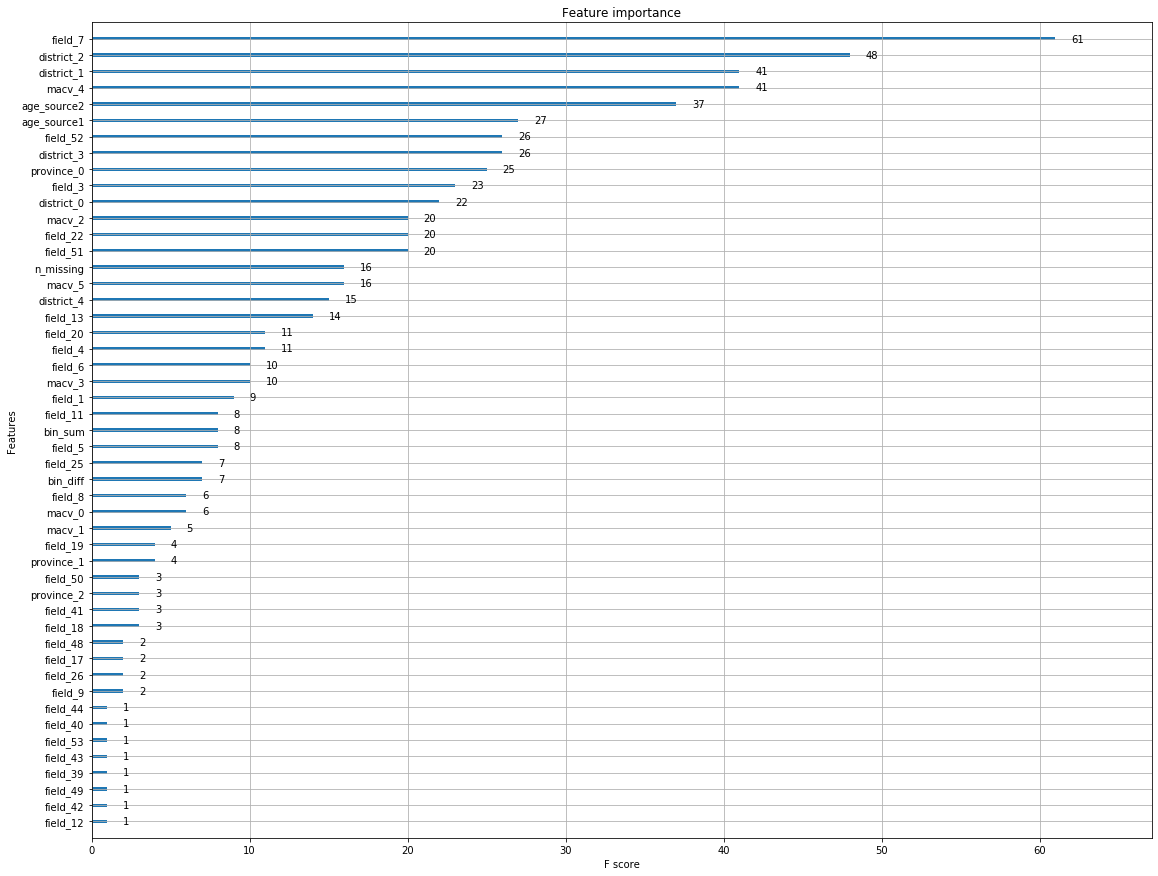

In [176]:
plt.rcParams["figure.figsize"] = (19, 15)
plot_importance(booster=clf)

## Vanilla neural net

In [114]:
def nn_model(cat_fea, cat_uniques, max_cat_values):
    inputs = []
    flatten_layers = []
    for e, c in enumerate(cat_fea):
        input_c = Input(shape=(1,), dtype="int32")
        num_c = cat_uniques[e]
        embed_c = Embedding(
            num_c,
            # 6,
            max_cat_values[e],
            input_length=1,
        )(input_c)
        #         embed_c = Dropout(0.25)(embed_c)
        flatten_c = Flatten()(embed_c)

        inputs.append(input_c)
        flatten_layers.append(flatten_c)

    input_num = Input(shape=(X.shape[1],), dtype="float32")
    flatten_layers.append(input_num)
    inputs.append(input_num)

    # flatten = merge(flatten_layers, mode='concat')
    flatten = concatenate(flatten_layers, axis=-1)

    fc1 = Dense(32, init="he_normal")(flatten)
    fc1 = PReLU()(fc1)
    fc1 = BatchNormalization()(fc1)
    fc1 = Dropout(0.1)(fc1)

    fc1 = Dense(32, init="he_normal")(fc1)
    fc1 = PReLU()(fc1)
    fc1 = BatchNormalization()(fc1)
    fc1 = Dropout(0.1)(fc1)

    outputs = Dense(1, init="he_normal", activation="sigmoid")(fc1)

    model = Model(input=inputs, output=outputs)
    model.compile(loss="binary_crossentropy", optimizer="adam")
    return model

In [105]:
train_df_new = train_df.copy()
to_drop = [
    "age_source2",
    "field_14",
    "field_52",
    "field_56",
    "field_18",
    "field_19",
    "field_27",
    "field_50",
    "field_51",
    "field_57",
]
cat_cols = [
    "province",
    "district",
    "macv",
    "field_7",
    "field_8",
    "field_9",
    "field_10",
    "field_12",
    "field_13",
    "field_17",
    "field_24",
    "field_35",
    "field_39",
    "field_40",
    "field_41",
    "field_42",
    "field_43",
    "field_44",
    "field_45",
]
ind_cols = ["field_4", "field_5", "field_6", "field_11", "field_16", "field_21"]
bin_cols = [
    "field_1",
    "field_2",
    "field_15",
    "field_20",
    "field_23",
    "field_25",
    "field_26",
    "field_28",
    "field_29",
    "field_30",
    "field_31",
    "field_32",
    "field_33",
    "field_34",
    "field_36",
    "field_37",
    "field_38",
    "field_46",
    "field_47",
    "field_48",
    "field_49",
]
bin_cols += ["field_14", "field_18", "field_19", "field_27"]
num_cols = ["age_source1", "field_3", "field_22", "field_53", "field_54", "field_55"]
num_cols += ["age_source2", "field_50", "field_51", "field_52", "field_56", "field_57"]
features = cat_cols + ind_cols + bin_cols + num_cols
# Fill 'None' with NaNs
for c in train_df_new.columns:
    train_df_new.loc[train_df_new[c] == "None", c] = np.nan

for c in features:
    if (c in cat_cols or c in bin_cols or c in ind_cols) and (
        train_df_new[c].dtype.kind in "fi"
    ):
        train_df_new[c] = train_df_new[c].astype("object")

# New feature: number of nans
train_df_new["n_missing"] = train_df_new.isna().sum(axis=1)
num_cols.append("n_missing")
features.append("n_missing")
num_cols.append("n_missing")

# Remove rows with more than 20 nans
# train_df_new = train_df_new.query("n_missing < 20").copy()
# train_df_new.drop(columns=nan_cols, inplace=True)
# features = [f for f in features if f not in nan_cols]
# cat_cols = [f for f in cat_cols if f not in nan_cols]

# Handling binary cols
new_bin_cols = []
for c in bin_cols:
    if train_df_new[c].isna().sum() > 0:
        if train_df_new[c].isna().min() < 0.1:
            train_df_new[c] = train_df_new[c].fillna(train_df_new[c].mode()[0])
            new_bin_cols.append(c)
            train_df_new[c] = train_df_new[c].astype("bool")
        else:
            train_df_new[c] = train_df_new[c].fillna("undefined")
            cat_cols.append(c)
    else:
        new_bin_cols.append(c)
        train_df_new[c] = train_df_new[c].astype("bool")

# train_df_new.macv = train_df_new.macv.str.lower()

for c in features:
    #     print(c)
    if c in cat_cols or c in ind_cols:
        if train_df_new[c].isna().mean() < 0.1:
            train_df_new[c].fillna(train_df_new[c].mode()[0], inplace=True)
        else:
            train_df_new[c].fillna("undefined", inplace=True)
            train_df_new[c] = train_df_new[c].astype(str)
        #         if c == 'macv':
        #             pattern = "(^cn\s)|(công nhân)"
        #             train_df_new['is_worker'] = np.where(train_df_new[c].str.contains(pattern), 1, 0)
        #             features.append('is_worker')
        le = LabelEncoder()
        le.fit(train_df_new[c].astype(str))
        train_df_new[c] = le.transform(train_df_new[c].astype(str))
    elif c in num_cols:
        train_df_new[c].fillna(train_df_new[c].median(), inplace=True)

# New feature: Sum of binary
train_df_new["bin_sum"] = train_df_new[new_bin_cols].sum(axis=1).astype("float")
features.append("bin_sum")
num_cols.append("bin_sum")

# New features: Differences measure for binary feature
# Reference row for binary features
bin_ref = train_df_new[new_bin_cols].copy()
bin_ref_med = bin_ref.median(axis=0).to_frame().T
bin_ref_med = pd.DataFrame(
    bin_ref_med.values.repeat(train_df_new.shape[0], axis=0),
    columns=bin_ref_med.columns,
)
# Calculate the difference
train_df_new["bin_diff"] = (
    train_df_new[new_bin_cols].subtract(bin_ref_med).abs().sum(axis=1).astype("float")
)
features.append("bin_diff")
num_cols.append("bin_diff")

# Mean of 2 age sources
train_df_new["mean_age"] = train_df_new[["age_source1", "age_source2"]].mean(axis=1)
features.append("mean_age")
num_cols.append("mean_age")

# Count of categorical variables
count = 0
for c in ind_cols:
    if count == 0:
        train_df_new["new_ind"] = train_df_new[c].astype(str) + "_"
        count += 1
    else:
        train_df_new["new_ind"] += train_df_new[c].astype(str) + "_"
# train_df_new = cat_count_features(train_df_new, cat_cols + ['new_ind']).drop(columns=['new_ind'])
train_df_new, cat_count_cols = cat_count_features(
    train_df_new, ["new_ind", "field_7", "province", "district", "macv", "field_13"]
)
train_df_new = train_df_new.drop(columns=["new_ind"])

# Aggregate features
group_cols = ["district", "field_7", "province"]
agg_cols = ["field_3", "age_source2", "field_22"]
train_df_new, agg_ft = aggregate_features(train_df_new, group_cols, agg_cols)

# Interaction features
feature_set = ["age_source2", "field_3", "field_22"]
train_df_new, inter_cols = interact_features(train_df_new, feature_set)

In [107]:
cat_fea = cat_cols + ind_cols
max_cat_values = []
cat_uniques = []
for c in cat_fea:
    cat_uniques.append(train_df_new[c].nunique())
    if train_df_new[c].nunique() < 5:
        max_cat_values.append(1)
    else:
        max_cat_values.append(min(7, int(np.sqrt(train_df_new[c].nunique()).round())))

In [108]:
X, y = (
    train_df_new.drop(columns=["id", "label"] + cat_cols + ind_cols + bin_cols).copy(),
    train_df_new["label"].copy(),
)

In [109]:
# Convert back boolean columns to 0/1
for c in X.columns:
    if X[c].dtype.kind in "b":
        X[c] = X[c].astype("int")
#     if X_test[c].dtype.kind in 'b':
#         X_test[c] = X_test[c].astype('int')

In [110]:
# Replace inf by nan
X = X.replace([np.inf, -np.inf], np.nan).fillna(0)

In [111]:
X_cat = train_df_new[cat_cols + ind_cols].copy().as_matrix()

In [112]:
scaler = StandardScaler()
scaler.fit(X.astype(float))
X_scaled = scaler.transform(X.astype(float))

In [27]:
def get_rank(x):
    return pd.Series(x).rank(pct=True).values

In [115]:
%%time
for s in range(1):  # seeds
    np.random.seed(s)
    scores = []
    for i, (tr_ind, tst_ind) in enumerate(folds):
        print(f"fold {i}")
        xtr = X_scaled[tr_ind].copy()
        ytr = y[tr_ind].copy()
        xte = X_scaled[tst_ind].copy()
        yte = y[tst_ind].copy()

        # Categorical cols
        xtr_cat = X_cat[tr_ind]
        xte_cat = X_cat[tst_ind]

        # get xtr/xte categorical list
        xtr_cat_list, xte_cat_list = [], []
        for i in range(xtr_cat.shape[1]):
            xtr_cat_list.append(xtr_cat[:, i].reshape(-1, 1))
            xte_cat_list.append(xte_cat[:, i].reshape(-1, 1))

        # Append numeric columns
        xtr_cat_list.append(xtr)
        xte_cat_list.append(xte)

        model = nn_model(cat_fea, cat_uniques, max_cat_values)
        rlr = ReduceLROnPlateau(
            monitor="val_loss",
            patience=2,
            verbose=1,
            factor=0.3,
            min_lr=0.00001,
            epsilon=0.001,
        )
        es = EarlyStopping(monitor="val_loss", mode="min", patience=4, verbose=1)
        model.fit(
            xtr_cat_list,
            ytr,
            epochs=15,
            batch_size=32,
            verbose=0,
            validation_data=[xte_cat_list, yte],
            callbacks=[es, rlr],
        )
        pred = model.predict(xte_cat_list, batch_size=32, verbose=0)
        # print(pred.shape)
        # print(pred)
        score = gini(yte, pred)
        print(f"score: {score}")
        scores.append(score)
        del model
        gc.collect()
        K.clear_session()
        tf.keras.backend.clear_session()
        tf.compat.v1.reset_default_graph()
    print(f"Mean score: {np.mean(scores)}")

fold 0

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.

Epoch 00007: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.

Epoch 00009: ReduceLROnPlateau reducing learning rate to 2.700000040931627e-05.
Epoch 00009: early stopping
score: 0.08723716115341322
fold 1

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.

Epoch 00005: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
Epoch 00006: early stopping
score: 0.06331013745704467
fold 2

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.

Epoch 00005: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.

Epoch 00007: ReduceLROnPlateau reducing learning rate to 2.700000040931627e-05.
Epoch 00008: early stopping
score: 0.11009192439862545
fold 3

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.

Epoch 00005: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-0

## Baseline from forum #1 (kinda) 

In [61]:
%%time
train_df_new = train_df.copy()
roman_conversion = {"I": 1, "II": 2, "III": 3, "IV": 4, "V": 5}
cat_cols = [
    "province",
    "district",
    "macv",
    "field_7",
    "field_8",
    "field_9",
    "field_10",
    "field_12",
    "field_13",
    "field_17",
    "field_24",
    "field_35",
    "field_39",
    "field_40",
    "field_42",
    "field_43",
    "field_44",
]

ind_cols = [
    "field_1",
    "field_4",
    "field_5",
    "field_6",
    "field_11",
    "field_14",
    "field_15",
    "field_16",
    "field_21",
    "field_32",
    "field_33",
    "field_34",
    "field_41",
    "field_45",
    "field_46",
]

bin_cols = [
    "field_2",
    "field_18",
    "field_19",
    "field_20",
    "field_23",
    "field_25",
    "field_26",
    "field_27",
    "field_28",
    "field_29",
    "field_30",
    "field_31",
    "field_36",
    "field_37",
    "field_38",
    "field_47",
    "field_48",
    "field_49",
]

num_cols = [
    "age_source1",
    "field_3",
    "field_22",
    "field_53",
    "field_54",
    "field_55",
    "age_source2",
    "field_50",
    "field_51",
    "field_52",
    "field_56",
    "field_57",
]
features = cat_cols + ind_cols + bin_cols + num_cols
assert set(train_df_new.columns) - set(features) == {"id", "label"}

# Fix typo
train_df_new = handle_category_typo(train_df_new)

# New features: Counts of NaNs and Nones
train_df_new["nan_count"] = train_df_new.isna().sum(axis=1).astype(float)
train_df_new["none_count"] = (train_df_new == "None").sum(axis=1).astype(float)

# Handling binary cols
new_bin_cols = []
for c in bin_cols:
    if (train_df_new[c] == "None").any().sum() > 0:
        cat_cols.append(c)
    elif train_df_new[c].isna().sum() > 0:
        if train_df_new[c].isna().mean() < 0.1:
            train_df_new[c] = train_df_new[c].fillna(train_df_new[c].mode()[0])
            new_bin_cols.append(c)
            train_df_new[c] = train_df_new[c].astype("bool")
        else:
            train_df_new[c] = train_df_new[c].fillna("undefined")
            cat_cols.append(c)
    else:
        new_bin_cols.append(c)
        train_df_new[c] = train_df_new[c].astype("bool")

# Handling cat cols
for c in cat_cols:
    if train_df_new[c].isna().mean() < 0.1:  # Fill with mode
        train_df_new[c] = train_df_new[c].fillna(train_df_new[c].mode()[0])
    else:  # create new value
        train_df_new[c] = train_df_new[c].fillna("undefined")

# Handling ind cols
train_df_new["field_41"].replace(roman_conversion, inplace=True)
for c in ind_cols:
    train_df_new.loc[train_df_new[c] == "None", c] = -2
    if train_df_new[c].isna().mean() < 0.1:  # Fill with mode
        train_df_new[c] = train_df_new[c].fillna(train_df_new[c].mode()[0])
    else:  # replace with -1
        train_df_new[c] = train_df_new[c].fillna(-1)
    train_df_new[c] = train_df_new[c].astype(int)

# New features Category Count feature
train_df_new, cat_count_cols = cat_count_features(train_df_new, cat_cols + ind_cols)

# # check if this value is unique in a column
# u_cols = []
# for c in num_cols + bin_cols + ind_cols:
#     unique_v = train_df_new[c].value_counts()
#     unique_v = unique_v.index[unique_v == 1]
#     train_df_new[f"{c}_u"] = train_df_new[c].isin(unique_v)
#     u_cols.append(f"{c}_u")
    
# # Check if there is any 'unique' values in each row
# train_df_new['has_unique'] = train_df_new[u_cols].any(axis=1)


# Categories with less than or eq 10 unique values
# cat_cols_less10 = [c for c in cat_cols if train_df_new[c].nunique() < 10]
# print(cat_cols_less10)

# One-hot encoded cols
# train_df_new = pd.get_dummies(train_df_new, columns=cat_cols_less10, drop_first=False)

# Label encoding
for c in cat_cols:
    le = LabelEncoder()
    le.fit(train_df_new[c].astype(str))
    train_df_new[c] = le.transform(train_df_new[c].astype(str))

# New feature: Sum of binary
train_df_new["bin_sum"] = train_df_new[new_bin_cols].sum(axis=1)
features.append("bin_sum")
num_cols.append("bin_sum")

# New features: Differences measure for binary feature
# Reference row for binary features
bin_ref = train_df_new[new_bin_cols].copy()
bin_ref_med = bin_ref.median(axis=0).to_frame().T
bin_ref_med = pd.DataFrame(
    bin_ref_med.values.repeat(train_df_new.shape[0], axis=0),
    columns=bin_ref_med.columns,
)
# Calculate the difference
train_df_new["bin_diff"] = (
    train_df_new[new_bin_cols].subtract(bin_ref_med).abs().sum(axis=1)
)
features.append("bin_diff")
num_cols.append("bin_diff")

# Ranking cols
train_df_new, rank_cols = rank_features(
    train_df_new, ["field_22", "field_51", "field_3"]
)
# Fractional cols
train_df_new, fractional_cols = fractional_features(
    train_df_new,
    ["field_50", "field_51", "field_52", "field_53", "field_54", "field_55"],
)

group_cols = ["district", "field_7", "province"]
agg_cols = [
    "field_3",
    "age_source2",
    "field_22",
    "field_50",
    "field_51",
    "field_52",
    "field_53",
    "field_54",
    "field_55",
]

# Agg features
# train_df_new, agg_ft = aggregate_features(train_df_new, group_cols, agg_cols)

# Interaction features
# feature_set = ["age_source1", "age_source2", "field_3", "field_22"]
# train_df_new, inter_cols = interact_features(train_df_new, feature_set)


# Handling numeric cols
for c in num_cols:
#     train_df_new.loc[train_df_new[c] == "None", c] = -2
    train_df_new.loc[train_df_new[c] == "None", c] = np.nan
    if train_df_new[c].isna().mean() < 0.1:  # Fill with median
        train_df_new[c] = train_df_new[c].fillna(train_df_new[c].median())
#     else:  # replace with -1
#         train_df_new[c] = train_df_new[c].fillna(-1)
        

# Mean of 2 age sources
train_df_new["mean_age"] = train_df_new[["age_source1", "age_source2"]].mean(axis=1)

# train_df_new = train_df_new.drop(
#     columns=[c for c in cat_cols if c not in cat_cols_less10]
# )

CPU times: user 1.91 s, sys: 1.87 ms, total: 1.91 s
Wall time: 1.93 s


In [56]:
# train_df_new['age_bin'] = pd.qcut(train_df_new['age_source2'], 5)
for c in [
    "age_source2",
    "field_22",
    "field_50",
    "field_51",
    "field_52",
    "field_53",
    "field_54",
    "field_55",
]:
    print(c)
    train_df_new[f"{c}_bin"] = pd.qcut(train_df_new[c], 5, duplicates="drop")
    train_df_new.drop(columns=c, inplace=True)

age_source2
field_22
field_50
field_51
field_52
field_53
field_54
field_55


In [73]:
ohe_cols = [
    "field_17",
    "field_19",
    "field_20",
    "field_23",
    "field_25",
    "field_30",
    "field_31",
]
woe_cols = [
    "province",
    "district",
    "macv",
    "age_source2",
    "field_3",
    "field_7",
    "field_17",
    "field_19",
    "field_20",
    "field_22",
    "field_23",
    "field_25",
    "field_30",
    "field_31",
    "field_51",
    "field_52",
    "field_53",
]

In [76]:
train_df_new.dtypes.index

Index(['id', 'label', 'province', 'district', 'age_source1', 'age_source2', 'macv', 'field_1', 'field_2', 'field_3',
       ...
       'field_22_rank_average', 'field_51_rank_average', 'field_3_rank_average', 'field_50_fractional', 'field_51_fractional', 'field_52_fractional', 'field_53_fractional', 'field_54_fractional', 'field_55_fractional', 'mean_age'], dtype='object', length=124)

In [ ]:
X, y = train_df_new.drop(columns=["id", "label"]).copy(), train_df_new["label"].copy()

In [31]:
%%time
# Scaling
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2)
scaler = StandardScaler()
Xtr_scaled = scaler.fit_transform(Xtr.astype(float))
Xte_scaled = scaler.fit_transform(Xte.astype(float))
X_scaled = scaler.fit_transform(X.astype(float))
# Nearest neighbours
# Fit on train set
nbrs = NearestNeighbors(n_neighbors=500, algorithm='ball_tree', n_jobs=-1).fit(Xtr_scaled[:])
# Get indices on train and test
distances_train, indices_train = nbrs.kneighbors(Xtr_scaled[:])
distances_test, indices_test = nbrs.kneighbors(Xte_scaled[:])

CPU times: user 4min 33s, sys: 887 ms, total: 4min 34s
Wall time: 1min 13s


In [32]:
Xte["label_mean"] = 0
for i in tqdm(range(Xte.shape[0])):
    Xte.at[i, "label_mean"] = ytr[indices_test[i]].mean()

100%|██████████| 6000/6000 [00:37<00:00, 160.81it/s]


In [137]:
xgb_params = {
    "n_jobs": -1,
    "colsample_bytree": 0.511182194059105,
    "min_child_weight": 5,
    "gamma": 0,
    "subsample": 0.7937217003281334,
    "max_depth": 5,
    "n_estimators": 231,
    "learning_rate": 0.044806747122933484,
}

estimators = [
    #     ('et', ExtraTreesClassifier(n_estimators=100, max_features='auto', n_jobs=-1)),
    ("xgb", xgb.XGBClassifier(**xgb_params)),
    #     ('cb', cb.CatBoostClassifier(leaf_estimation_method ='Newton', learning_rate=0.057, l2_leaf_reg = 23, depth=6, od_pval=0.0000001, iterations = 877, loss_function='Logloss')),
    #     ('cb', cb.CatBoostClassifier()),
    #     ("lr", LogisticRegression()),
    #     ('Ridge', RidgeClassifier()),
    #     ('lsvc', LinearSVC()),
    #     ('svc', SVC(probability=True)),
    #     ('mlp', MLPClassifier(max_iter=500)),
    #     ('vote1', vote1),
    #     ('vote2', vote2)
]
# Create folds
print(X.shape)
X_scaled = StandardScaler().fit_transform(
    X[num_cols + cat_count_cols + ["nan_count", "none_count"]]
)
# X['label_mean'] = 0
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for name, clf in estimators:
    print(f"{name}:")
    scores = []
    auc_scores = []
    for i, (train_index, test_index) in enumerate(folds):
        Xtrain, Xtest = (
            X.iloc[train_index].copy().reset_index(drop=True),
            X.iloc[test_index].copy().reset_index(drop=True),
        )
        ytrain, ytest = (
            y[train_index].copy().reset_index(drop=True),
            y[test_index].copy().reset_index(drop=True),
        )
        #         Get nearest neighbours
        #         print("get neighbours...")
        #         scaler = StandardScaler()
        #         Xtr_scaled = scaler.fit_transform(
        #             Xtrain[num_cols + cat_count_cols + ["nan_count", "none_count"]].astype(
        #                 float
        #             )
        #         )
        #         Xte_scaled = scaler.fit_transform(
        #             Xtest[num_cols + cat_count_cols + ["nan_count", "none_count"]].astype(float)
        #         )
        #         nbrs = NearestNeighbors(
        #             n_neighbors=500, algorithm="ball_tree", n_jobs=-1, metric="manhattan"
        #         ).fit(Xtr_scaled[:])
        #         # Get indices on train and test
        #         _, indices_train = nbrs.kneighbors(Xtr_scaled[:])
        #         _, indices_test = nbrs.kneighbors(Xte_scaled[:])
        #         # Calculate label mean of 500 nearest neighbours
        #         for i in tqdm(Xtrain.index.values):
        #             Xtrain.at[i, "label_mean"] = ytrain[indices_train[i]].mean()
        #         for i in tqdm(Xtest.index.values):
        #             Xtest.at[i, "label_mean"] = ytrain[indices_test[i]].mean()

        #         sm = SMOTE(random_state=12, ratio = 1.0)
        #         X_train, y_train = sm.fit_sample(X_train, y_train)
        if name != "xgb" and name != "cb":  # then scale
            scaled_ft = StandardScaler().fit_transform(Xtrain[num_cols])
            test_scaled_ft = StandardScaler().fit_transform(Xtest[num_cols])
            Xtrain[num_cols], Xtest[num_cols] = scaled_ft, test_scaled_ft
        if name == "cb":
            clf.fit(Xtrain, ytrain, silent=True, eval_set=(Xtest, ytest))
        elif name == "xgb":
            clf.fit(
                Xtrain,
                ytrain,
                verbose=False,
                eval_set=[(Xtrain, ytrain), (Xtest, ytest)],
                eval_metric=gini_xgb,
                early_stopping_rounds=100,
            )
            print(f"Best ntree {clf.get_booster().best_ntree_limit}")
        else:
            clf.fit(Xtrain, ytrain)
        ypred = clf.predict_proba(
            Xtest, ntree_limit=clf.get_booster().best_ntree_limit
        )[:, 1].round(6)
        # print(ypred)
        score = gini(ytest, ypred)
        auc = roc_auc_score(ytest, ypred)
        max_score = gini(ytest, ytest)
        print(f"\tScore: {score} | max score: {max_score} | AUC: {auc}")
        scores.append(score)
        auc_scores.append(auc)
    print(f"\tMean score: {np.mean(scores)} | Mean AUC: {np.mean(auc_scores)}")
#     print(f" Gini: {score['test_skgini'].mean()}")
#     print(f" ROC: {score['test_roc_auc'].mean()}")

(30000, 319)
xgb:
Best ntree 191
	Score: 0.12298800540046048 | max score: 0.4918346942176304 | AUC: 0.6252363896600484
Best ntree 50
	Score: 0.10793900343642614 | max score: 0.49191666666666667 | AUC: 0.6107439690808971
Best ntree 73
	Score: 0.14600773195876285 | max score: 0.49191666666666667 | AUC: 0.6478454953011836
Best ntree 181
	Score: 0.13037886597938148 | max score: 0.49191666666666667 | AUC: 0.6320907943016918
Best ntree 49
	Score: 0.11860052276754031 | max score: 0.49191531921987 | AUC: 0.6205637089646354
	Mean score: 0.12518282590851426 | Mean AUC: 0.6272960714616913


In [138]:
X

,age_source1,age_source2,field_1,field_2,field_3,field_4,field_5,field_6,field_11,field_14,field_15,field_16,field_21,field_22,field_32,field_33,field_34,field_41,field_45,field_46,field_47,field_48,field_49,field_50,field_51,field_52,field_53,field_54,field_55,field_56,field_57,nan_count,none_count,province_count,district_count,macv_count,field_7_count,field_8_count,field_9_count,field_10_count,field_12_count,field_13_count,field_17_count,field_24_count,field_35_count,field_39_count,field_40_count,field_42_count,field_43_count,field_44_count,field_18_count,field_19_count,field_20_count,field_23_count,field_25_count,field_26_count,field_27_count,field_28_count,field_29_count,field_30_count,field_31_count,field_36_count,field_37_count,field_38_count,field_1_count,field_4_count,field_5_count,field_6_count,field_11_count,field_14_count,field_15_count,field_16_count,field_21_count,field_32_count,field_33_count,field_34_count,field_41_count,field_45_count,field_46_count,field_8_FEMALE,field_8_MALE,field_8_undefined,field_10_GH,field_10_T1,field_10_undefined,field_12_0,field_12_1,field_12_HT,field_12_None,field_12_TN,field_12_undefined,field_17_G2,field_17_G3,field_17_G4,field_17_G7,field_17_G8,field_17_G9,field_17_GX,field_17_None,field_17_undefined,field_24_K1,field_24_K2,field_24_K3,field_24_None,field_24_undefined,field_35_Four,field_35_One,field_35_Three,field_35_Two,field_35_Zero,field_35_undefined,field_42_None,field_42_One,field_42_Zezo,field_42_undefined,field_43_0,field_43_5,field_43_A,field_43_B,field_43_C,field_43_D,field_43_None,field_43_undefined,field_44_None,field_44_One,field_44_Two,field_44_undefined,field_18_False,field_18_True,field_18_undefined,field_19_False,field_19_True,field_19_undefined,field_20_False,field_20_True,field_20_undefined,field_23_True,field_23_undefined,field_25_False,field_25_True,field_25_undefined,field_26_False,field_26_True,field_26_undefined,field_27_False,field_27_True,field_27_undefined,field_28_False,field_28_True,field_28_undefined,field_29_FALSE,field_29_None,field_29_TRUE,field_29_undefined,field_30_FALSE,field_30_None,field_30_TRUE,field_30_undefined,field_31_FALSE,field_31_None,field_31_undefined,field_36_FALSE,field_36_None,field_36_TRUE,field_36_undefined,field_37_FALSE,field_37_None,field_37_TRUE,field_37_undefined,field_38_False,field_38_True,field_38_undefined,bin_sum,bin_diff,field_22_rank_average,field_51_rank_average,field_3_rank_average,field_50_fractional,field_51_fractional,field_52_fractional,field_53_fractional,field_54_fractional,field_55_fractional,agg_district_field_3_mean,agg_district_field_3_median,agg_district_field_3_min,agg_district_field_3_max,agg_district_field_3_std,agg_district_age_source2_mean,agg_district_age_source2_median,agg_district_age_source2_min,agg_district_age_source2_max,agg_district_age_source2_std,agg_district_field_22_mean,agg_district_field_22_median,agg_district_field_22_min,agg_district_field_22_max,agg_district_field_22_std,agg_district_field_50_mean,agg_district_field_50_median,agg_district_field_50_min,agg_district_field_50_max,agg_district_field_50_std,agg_district_field_51_mean,agg_district_field_51_median,agg_district_field_51_min,agg_district_field_51_max,agg_district_field_51_std,agg_district_field_52_mean,agg_district_field_52_median,agg_district_field_52_min,agg_district_field_52_max,agg_district_field_52_std,agg_district_field_53_mean,agg_district_field_53_median,agg_district_field_53_min,agg_district_field_53_max,agg_district_field_53_std,agg_district_field_54_mean,agg_district_field_54_median,agg_district_field_54_min,agg_district_field_54_max,agg_district_field_54_std,agg_district_field_55_mean,agg_district_field_55_median,agg_district_field_55_min,agg_district_field_55_max,agg_district_field_55_std,agg_field_7_field_3_mean,agg_field_7_field_3_median,agg_field_7_field_3_min,agg_field_7_field_3_max,agg_field_7_field_3_std,agg_field_7_age_source2_mean,agg_field_7_age_source2_median,agg_field_7_age_source2_min,agg_field_7_age_s

In [101]:
# X_scaled = scaler.fit_transform(
#     X[num_cols + cat_count_cols + ["nan_count", "none_count"]].astype(float)
# )
# # Nearest neighbours
# # Fit on train set
# nbrs = NearestNeighbors(n_neighbors=500, algorithm="ball_tree", n_jobs=-1).fit(
#     X_scaled[:]
# )
# # Get indices on train and test
# distances_train, indices_train = nbrs.kneighbors(X_scaled[:])
# X["label_mean"] = 0
# for i in tqdm(X.index.values):
#     X.at[i, "label_mean"] = y[indices_train[i]].mean()
clf = xgb.XGBClassifier()
clf.fit(X, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

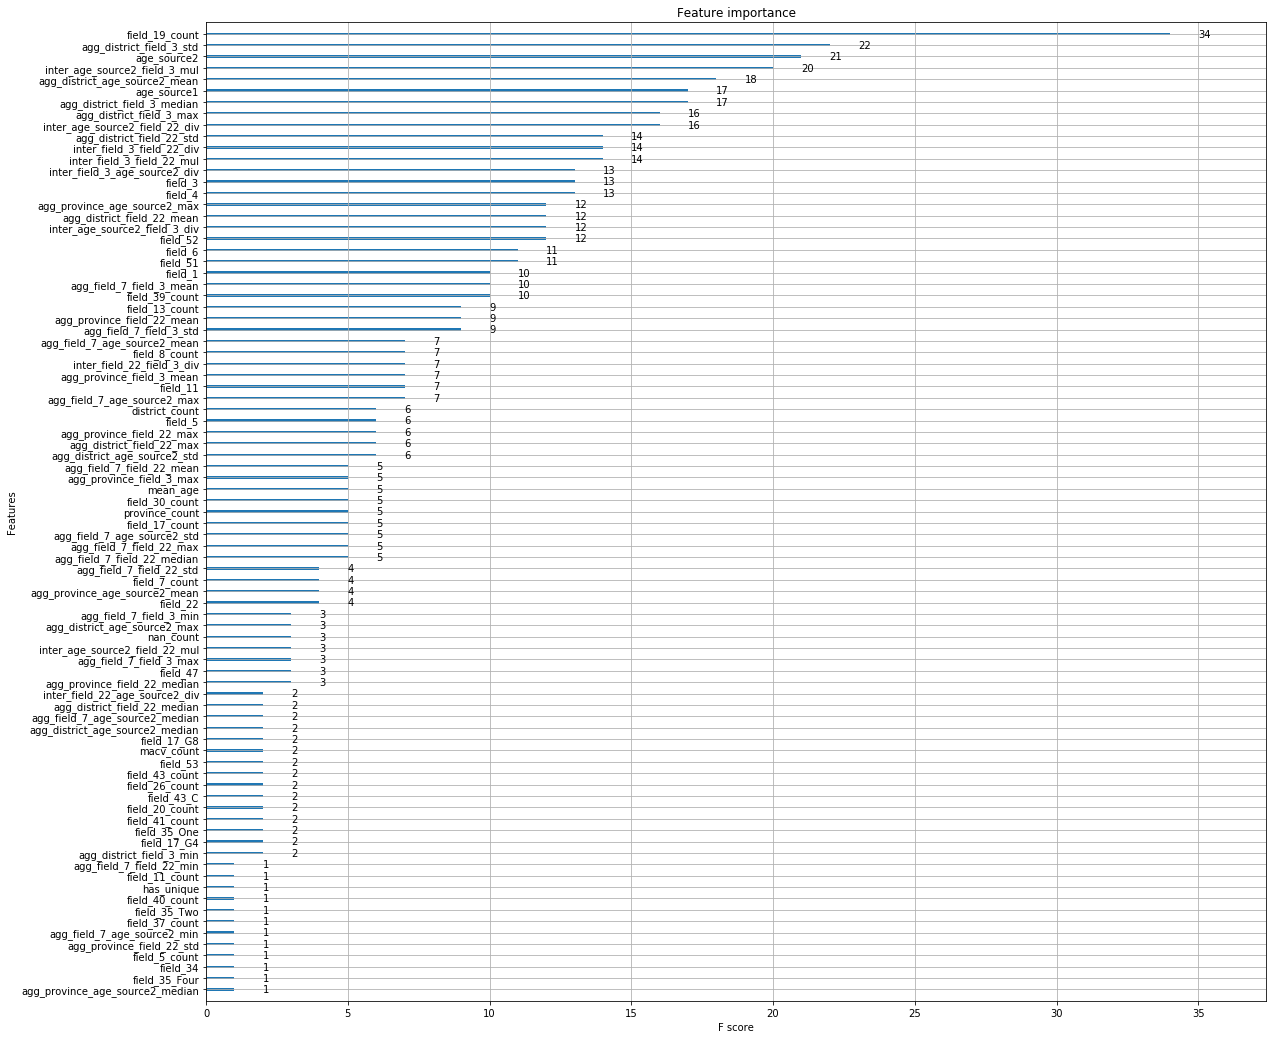

In [103]:
plt.rcParams["figure.figsize"] = (19, 18)
plot_importance(booster=clf)

## WOE-IV approach

In [27]:
train_df_new = train_df.copy()
roman_conversion = {"I": 1, "II": 2, "III": 3, "IV": 4, "V": 5}
cat_cols = [
    "province",
    "district",
    "macv",
    "field_7",
    "field_8",
    "field_9",
    "field_10",
    "field_12",
    "field_13",
    "field_17",
    "field_24",
    "field_35",
    "field_39",
    "field_40",
    "field_42",
    "field_43",
    "field_44",
]

ind_cols = [
    "field_1",
    "field_4",
    "field_5",
    "field_6",
    "field_11",
    "field_14",
    "field_15",
    "field_16",
    "field_21",
    "field_32",
    "field_33",
    "field_34",
    "field_41",
    "field_45",
    "field_46",
]


bin_cols = [
    "field_2",
    "field_18",
    "field_19",
    "field_20",
    "field_23",
    "field_25",
    "field_26",
    "field_27",
    "field_28",
    "field_29",
    "field_30",
    "field_31",
    "field_36",
    "field_37",
    "field_38",
    "field_47",
    "field_48",
    "field_49",
]
# features = cat_cols + ind_cols + bin_cols + num_cols
# assert set(train_df_new.columns) - set(features) == {"id", "label"}
# Fix typo
train_df_new = handle_category_typo(train_df_new)

# New features: Counts of NaNs and Nones
train_df_new["nan_count"] = train_df_new.isna().sum(axis=1).astype(float)
train_df_new["none_count"] = (train_df_new == "None").sum(axis=1).astype(float)

# Handling binary cols
new_bin_cols = []
for c in bin_cols:
    if (train_df_new[c] == "None").any().sum() > 0:
        cat_cols.append(c)
    elif train_df_new[c].isna().sum() > 0:
        if train_df_new[c].isna().mean() < 0.1:
            train_df_new[c] = train_df_new[c].fillna(train_df_new[c].mode()[0])
            new_bin_cols.append(c)
            train_df_new[c] = train_df_new[c].astype("bool")
        else:
            train_df_new[c] = train_df_new[c].fillna("undefined")
            cat_cols.append(c)
    else:
        new_bin_cols.append(c)
        train_df_new[c] = train_df_new[c].astype("bool")

# Handling ind cols
train_df_new["field_41"].replace(roman_conversion, inplace=True)
for c in ind_cols:
    train_df_new.loc[train_df_new[c] == "None", c] = -2
    if train_df_new[c].isna().mean() < 0.1:  # Fill with mode
        train_df_new[c] = train_df_new[c].fillna(train_df_new[c].mode()[0])
    else:  # replace with -1
        train_df_new[c] = train_df_new[c].fillna(-1)
    train_df_new[c] = train_df_new[c].astype(int)

# New feature: Sum of binary
train_df_new["bin_sum"] = train_df_new[new_bin_cols].sum(axis=1)
# features.append("bin_sum")
# num_cols.append("bin_sum")

# New features: Differences measure for binary feature
# Reference row for binary features
bin_ref = train_df_new[new_bin_cols].copy()
bin_ref_med = bin_ref.median(axis=0).to_frame().T
bin_ref_med = pd.DataFrame(
    bin_ref_med.values.repeat(train_df_new.shape[0], axis=0),
    columns=bin_ref_med.columns,
)
# Calculate the difference
train_df_new["bin_diff"] = (
    train_df_new[new_bin_cols].subtract(bin_ref_med).abs().sum(axis=1)
)
# features.append("bin_diff")
# num_cols.append("bin_diff")

# Ranking cols
train_df_new, rank_cols = rank_features(
    train_df_new, ["field_22", "field_51", "field_3"]
)
# Fractional cols
train_df_new, fractional_cols = fractional_features(
    train_df_new,
    ["field_50", "field_51", "field_52", "field_53", "field_54", "field_55"],
)

# Mean of 2 age sources
# train_df_new["mean_age"] = train_df_new[["age_source1", "age_source2"]].mean(axis=1)

# Count of categorical variables
# count = 0
# for c in ind_cols:
#     if count == 0:
#         train_df_new["new_ind"] = train_df_new[c].astype(str) + "_"
#         count += 1
#     else:
#         train_df_new["new_ind"] += train_df_new[c].astype(str) + "_"
# # train_df_new = cat_count_features(train_df_new, cat_cols + ['new_ind']).drop(columns=['new_ind'])
# train_df_new, cat_count_cols = cat_count_features(
#     train_df_new, ["new_ind", "field_7", "province", "district", "macv", "field_13"]
# )
# train_df_new = train_df_new.drop(columns=["new_ind"])

# group_cols = ["district", "field_7", "province"]
# agg_cols = [
#     "field_3",
#     "age_source2",
#     "field_22",
#     #     "field_50",
#     #     "field_51",
#     #     "field_52",
#     #     "field_53",
#     #     "field_54",
#     #     "field_55",
# ]

# # Agg features
# train_df_new, agg_ft = aggregate_features(train_df_new, group_cols, agg_cols)

# # Interaction features
# feature_set = ["age_source1", "age_source2", "field_3", "field_22"]
# train_df_new, inter_cols = interact_features(train_df_new, feature_set)

In [28]:
%%time
train_df_new = train_df.copy()
roman_conversion = {"I": 1, "II": 2, "III": 3, "IV": 4, "V": 5}
cat_cols = [
    "province",
    "district",
    "macv",
    "field_7",
    "field_8",
    "field_9",
    "field_10",
    "field_12",
    "field_13",
    "field_17",
    "field_24",
    "field_35",
    "field_39",
    "field_40",
    "field_42",
    "field_43",
    "field_44",
]

ind_cols = [
    "field_1",
    "field_4",
    "field_5",
    "field_6",
    "field_11",
    "field_14",
    "field_15",
    "field_16",
    "field_21",
    "field_32",
    "field_33",
    "field_34",
    "field_41",
    "field_45",
    "field_46",
]

bin_cols = [
    "field_2",
    "field_18",
    "field_19",
    "field_20",
    "field_23",
    "field_25",
    "field_26",
    "field_27",
    "field_28",
    "field_29",
    "field_30",
    "field_31",
    "field_36",
    "field_37",
    "field_38",
    "field_47",
    "field_48",
    "field_49",
]

num_cols = [
    "age_source1",
    "field_3",
    "field_22",
    "field_53",
    "field_54",
    "field_55",
    "age_source2",
    "field_50",
    "field_51",
    "field_52",
    "field_56",
    "field_57",
]
features = cat_cols + ind_cols + bin_cols + num_cols
assert set(train_df_new.columns) - set(features) == {"id", "label"}

# Fix typo
train_df_new = handle_category_typo(train_df_new)

# Fix age
train_df_new["age_source"] = np.where(
    train_df_new["age_source2"] == train_df_new["age_source1"],
    train_df_new["age_source1"],
    np.nan,
)

# Fix some fields
train_df_new.loc[train_df_new["field_3"] == -1, "field_3"] = np.nan
train_df_new.loc[
    train_df_new["field_9"].isin(["na", "79", "75", "80", "86"]), "field_9"
] = np.nan
train_df_new["field_7"] = train_df_new["field_7"].fillna("[]").apply(lambda x: eval(x))
train_df_new["field_7_elem_count"] = train_df_new["field_7"].apply(lambda x: len(x))
train_df_new["field_7"] = [",".join(map(str, l)) for l in train_df_new["field_7"]]


# New features: Counts of NaNs and Nones
train_df_new["nan_count"] = train_df_new.isna().sum(axis=1).astype(float)
train_df_new["none_count"] = (train_df_new == "None").sum(axis=1).astype(float)
train_df_new["cat_nan_count"] = train_df_new[cat_cols+ind_cols].isna().sum(axis=1).astype(float)
train_df_new["bin_nan_count"] = train_df_new[bin_cols].isna().sum(axis=1).astype(float)
train_df_new["num_nan_count"] = train_df_new[num_cols].isna().sum(axis=1).astype(float)
train_df_new["cat_none_count"] = (train_df_new[cat_cols+ind_cols] == 'None').sum(axis=1).astype(float)
train_df_new["bin_none_count"] = (train_df_new[bin_cols] == 'None').sum(axis=1).astype(float)
train_df_new["num_none_count"] = (train_df_new[num_cols] == 'None').sum(axis=1).astype(float)

# Handling binary cols
new_bin_cols = []
for c in bin_cols:
    train_df_new[f"{c}_is_null"] = train_df_new[c].isnull()
    train_df_new.loc[train_df_new[c] == 'None', c] = -1
    train_df_new[c] = train_df_new[c].astype("bool")
    train_df_new[c] = train_df_new[c].fillna(-999)
#     if (train_df_new[c] == "None").any().sum() > 0:
#         cat_cols.append(c)
#     elif train_df_new[c].isna().sum() > 0:
#         if train_df_new[c].isna().mean() < 0.1:
#             train_df_new[c] = train_df_new[c].fillna(train_df_new[c].mode()[0])
#             new_bin_cols.append(c)
#             train_df_new[c] = train_df_new[c].astype("bool")
#         else:
#             train_df_new[c] = train_df_new[c].fillna("undefined")
#             cat_cols.append(c)
#     else:
#         new_bin_cols.append(c)
#         train_df_new[c] = train_df_new[c].astype("bool")

# Handling cat cols
for c in cat_cols:
    if train_df_new[c].isna().mean() > 0:  # Fill with unedfined
        train_df_new[c] = train_df_new[c].fillna("undefined")
train_df_new['district_macv'] = train_df_new['district'].astype('str') + train_df_new['macv'].astype('str')


# Handling ind cols
train_df_new["field_41"].replace(roman_conversion, inplace=True)
for c in ind_cols:
    train_df_new.loc[train_df_new[c] == "None", c] = -999
    if train_df_new[c].isna().mean() < 0.1:  # Fill with mode
        train_df_new[c] = train_df_new[c].fillna(train_df_new[c].mode()[0])
    else:  # replace with -1
        train_df_new[c] = train_df_new[c].fillna(-1)
    train_df_new[c] = train_df_new[c].astype(int)

# New features Category Count feature
train_df_new, cat_count_cols = cat_count_features(train_df_new, cat_cols + ind_cols)

# # check if this value is unique in a column
# u_cols = []
# for c in num_cols + bin_cols + ind_cols:
#     unique_v = train_df_new[c].value_counts()
#     unique_v = unique_v.index[unique_v == 1]
#     train_df_new[f"{c}_u"] = train_df_new[c].isin(unique_v)
#     u_cols.append(f"{c}_u")
    
# # Check if there is any 'unique' values in each row
# train_df_new['has_unique'] = train_df_new[u_cols].any(axis=1)


# Categories with less than or eq 10 unique values
# cat_cols_less10 = [c for c in cat_cols if train_df_new[c].nunique() < 10]
# print(cat_cols_less10)

# One-hot encoded cols
# train_df_new = pd.get_dummies(train_df_new, columns=cat_cols_less10, drop_first=False)

# Label encoding
for c in cat_cols + ['district_macv']:
    le = LabelEncoder()
    le.fit(train_df_new[c].astype(str))
    train_df_new[c] = le.transform(train_df_new[c].astype(str))


# New feature: Sum of binary
train_df_new["bin_sum"] = train_df_new[new_bin_cols].sum(axis=1)
features.append("bin_sum")
num_cols.append("bin_sum")

# New features: Differences measure for binary feature
# Reference row for binary features
bin_ref = train_df_new[new_bin_cols].copy()
bin_ref_med = bin_ref.median(axis=0).to_frame().T
bin_ref_med = pd.DataFrame(
    bin_ref_med.values.repeat(train_df_new.shape[0], axis=0),
    columns=bin_ref_med.columns,
)
# Calculate the difference
train_df_new["bin_diff"] = (
    train_df_new[new_bin_cols].subtract(bin_ref_med).abs().sum(axis=1)
)
features.append("bin_diff")
num_cols.append("bin_diff")

# Ranking cols
train_df_new, rank_cols = rank_features(
    train_df_new, ["field_22", "field_51", "field_3"]
)
# Fractional cols
train_df_new, fractional_cols = fractional_features(
    train_df_new,
    ["field_50", "field_51", "field_52", "field_53", "field_54", "field_55"],
)

group_cols = ["district", "field_7", "province"]
agg_cols = [
    "field_3",
    "age_source2",
    "field_22",
    "field_50",
    "field_51",
    "field_52",
    "field_53",
    "field_54",
    "field_55",
]

# Agg features
# train_df_new, agg_ft = aggregate_features(train_df_new, group_cols, agg_cols)

# Interaction features
# feature_set = ["age_source1", "age_source2", "field_3", "field_22"]
# train_df_new, inter_cols = interact_features(train_df_new, feature_set)


# Handling numeric cols
for c in num_cols:
#     train_df_new.loc[train_df_new[c] == "None", c] = -2
    train_df_new.loc[train_df_new[c] == "None", c] = np.nan
    if train_df_new[c].isna().mean() < 0.1:  # Fill with median
        train_df_new[c] = train_df_new[c].fillna(train_df_new[c].median())
#     else:  # replace with -1
#         train_df_new[c] = train_df_new[c].fillna(-1)
        

# Mean of 2 age sources
# train_df_new["mean_age"] = train_df_new[["age_source1", "age_source2"]].mean(axis=1)

# train_df_new = train_df_new.drop(
#     columns=[c for c in cat_cols if c not in cat_cols_less10]
# )
# Combination of province,district and macv

CPU times: user 2.29 s, sys: 15.5 ms, total: 2.31 s
Wall time: 2.34 s


### Train test split before WOE

In [29]:
Xtrain, Xtest, ytrain, ytest = train_test_split(
    train_df_new.drop(columns=["id", "label"]),
    train_df_new["label"],
    test_size=0.2,
    stratify=train_df_new["label"],
    random_state=4124,
)

In [30]:
%%time
final_iv_train, iv_train = data_vars(Xtrain, ytrain)
Xtrain = woe_features(Xtrain, final_iv_train, iv_train)
Xtest = woe_features(Xtest, final_iv_train, iv_train)

100%|██████████| 134/134 [00:10<00:00, 12.67it/s]


CPU times: user 10.5 s, sys: 50.3 ms, total: 10.6 s
Wall time: 10.7 s


In [31]:
woe_cols = iv_train[iv_train["IV"] >= 0.1].VAR_NAME.tolist()
woe_cols

['field_19']

In [32]:
Xtrain

,province,district,age_source1,age_source2,macv,field_1,field_2,field_3,field_4,field_5,field_6,field_7,field_8,field_9,field_10,field_11,field_12,field_13,field_14,field_15,field_16,field_17,field_18,field_19,field_20,field_21,field_22,field_23,field_24,field_25,field_26,field_27,field_28,field_29,field_30,field_31,field_32,field_33,field_34,field_35,field_36,field_37,field_38,field_39,field_40,field_41,field_42,field_43,field_44,field_45,field_46,field_47,field_48,field_49,field_50,field_51,field_52,field_53,field_54,field_55,field_56,field_57,age_source,field_7_elem_count,nan_count,none_count,cat_nan_count,bin_nan_count,num_nan_count,cat_none_count,bin_none_count,num_none_count,field_2_is_null,field_18_is_null,field_19_is_null,field_20_is_null,field_23_is_null,field_25_is_null,field_26_is_null,field_27_is_null,field_28_is_null,field_29_is_null,field_30_is_null,field_31_is_null,field_36_is_null,field_37_is_null,field_38_is_null,field_47_is_null,field_48_is_null,field_49_is_null,district_macv,province_count,district_count,macv_count,field_7_count,field_8_count,field_9_count,field_10_count,field_12_count,field_13_count,field_17_count,field_24_count,field_35_count,field_39_count,field_40_count,field_42_count,field_43_count,field_44_count,field_1_count,field_4_count,field_5_count,field_6_count,field_11_count,field_14_count,field_15_count,field_16_count,field_21_count,field_32_count,field_33_count,field_34_count,field_41_count,field_45_count,field_46_count,bin_sum,bin_diff,field_22_rank_average,field_51_rank_average,field_3_rank_average,field_50_fractional,field_51_fractional,field_52_fractional,field_53_fractional,field_54_fractional,field_55_fractional,woe_field_19
0,64,699,NaN,NaN,2523,0,False,NaN,0,0,0,0,2,31,2,-1,5,227,1,1,-1,8,True,True,True,-1,NaN,True,4,True,True,True,True,True,True,True,1,1,1,5,True,True,True,45,9,-1,3,7,3,-1,0,False,False,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,48.0,0.0,21.0,14.0,12.0,0.0,0.0,0.0,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,False,False,6199,12818,12849,9693,13093,9678,9691,9678,9678,9700,9678,9678,9678,9678,9678,9678,9678,9678,6740,20209,12817,26881,9678,11933,11852,9678,9678,10122,20478,13663,9678,9678,17918,0.0,0.0,20847.0,21183.0,24077.0,NaN,NaN,NaN,NaN,NaN,NaN,0.295646
1,64,699,NaN,NaN,2523,1,True,1082.0,0,0,0,0,2,31,2,-1,5,227,1,1,-1,8,True,True,True,-1,NaN,True,4,True,True,True,True,True,True,True,1,1,1,5,True,True,True,45,9,-1,3,7,3,-1,0,True,True,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,47.0,0.0,21.0,14.0,11.0,0.0,0.0,0.0,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,False,False,6199,12818,12849,9693,13093,9678,9691,9678,9678,9700,9678,9678,9678,9678,9678,9678,9678,9678,23260,20209,12817,26881,9678,11933,11852,9678,9678,10122,20478,13663,9678,9678,17918,0.0,0.0,26592.0,26592.0,5488.0,NaN,NaN,NaN,NaN,NaN,NaN,0.295646
2,64,699,NaN,NaN,2523,1,False,NaN,0,0,0,0,2,31,2,-1,5,227,1,1,-1,8,True,True,True,-1,NaN,True,4,True,True,True,True,True,True,True,1,1,1,5,True,True,True,45,9,-1,3,7,3,-1,0,False,False,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,48.0,0.0,21.0,14.0,12.0,0.0,0.0,0.0,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,False,False,6199,12818,12849,9693,13093,9678,9691,9678,9678,9700,9678,9678,9678,9678,9678,9678,9678,9678,23260,20209,12817,26881,9678,11933,11852,9678,9678,10122,20478,13663,9678,9678,17918,0.0,0.0,23705.0,23705.0,29161.0,NaN,NaN,NaN,NaN,NaN,NaN,0.295646
3,64,699,NaN,50.0,2163,1,True,2905.0,0,0,0,0,1,8,1,12,0,15,0,0,1,7,True,False,False,1,24.0,True,3,True,False,True,True,True,True,True,0,0,0,4,True,True,False,43,8,4,2,6,1,1,1,True,True,True,29.77,25.758,30.955,31.171,0.0,0.05,0.00,0.00,NaN,0,4.0,4.0,2.0,0.0,1.0,4.0,0.0,0.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,6098,12818,12849,13203,13093,11031,263,10857,16650,260,16631,19823,9210,10569,15221,20163,19126,14850,23260,20209,12817,2688

In [33]:
Xtrain.drop(columns="field_19", inplace=True)
Xtest.drop(columns="field_19", inplace=True)

In [34]:
Xtrain.shape

(24000, 134)

In [35]:
for c in tqdm(cat_cols):
    le = LabelEncoderExt()
    le.fit(Xtrain[c].astype(str))
    Xtrain[c] = le.transform(Xtrain[c].astype(str))
    Xtest[c] = le.transform(Xtest[c].astype(str))

100%|██████████| 17/17 [00:02<00:00,  6.48it/s]


In [36]:
xgb_params = {
    "n_jobs": -1,
    "colsample_bytree": 0.511182194059105,
    "min_child_weight": 5,
    "gamma": 0,
    "subsample": 0.7937217003281334,
    "max_depth": 5,
    "n_estimators": 231,
    "learning_rate": 0.044806747122933484,
}
clf = xgb.XGBClassifier(**xgb_params)
clf.fit(
    Xtrain,
    ytrain,
    verbose=False,
    eval_set=[(Xtrain, ytrain), (Xtest, ytest)],
    eval_metric=gini_xgb,
    early_stopping_rounds=100,
)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.511182194059105, gamma=0,
              learning_rate=0.044806747122933484, max_delta_step=0, max_depth=5,
              min_child_weight=5, missing=None, n_estimators=231, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.7937217003281334, verbosity=1)

In [37]:
ypred = clf.predict_proba(Xtest)[:, 1].round(6)
# print(ypred)
gini(ytest, ypred)

0.14416924398625428

### Full WOE

In [56]:
%%time
final_iv, iv = data_vars(train_df_new.drop(columns=["id", "label"]), train_df_new["label"])

100%|██████████| 134/134 [00:11<00:00, 11.39it/s]


CPU times: user 11.7 s, sys: 45.3 ms, total: 11.7 s
Wall time: 11.8 s


In [58]:
woe_cols = iv.sort_values("IV", ascending=False).VAR_NAME.tolist()[:9]

In [147]:
%%time
transform_prefix = "woe_"
for var in tqdm_notebook(woe_cols):
    # print(var)
    small_df = final_iv[final_iv['VAR_NAME'] == var][['MAX_VALUE', 'WOE']].rename(columns={
        'WOE': f'woe_{var}'
    })
#     transform_dict = dict(zip(small_df.MAX_VALUE,small_df.WOE))
#     replace_cmd = ""
#     replace_cmd1 = ""
#     for i in sorted(transform_dict.items()):
#         replace_cmd = replace_cmd + str(i[1]) + str(' if x <= ') + str(i[0]) + ' else '
#         replace_cmd1 = replace_cmd1 + str(i[1]) + str(' if x == "') + str(i[0]) + '" else '
#     replace_cmd = replace_cmd + '0'
#     replace_cmd1 = replace_cmd1 + '0'
#     if replace_cmd != '0':
#         try:
#             df[transform_prefix + var] = df[var].apply(lambda x: eval(replace_cmd))
#         except:
#             df[transform_prefix + var] = df[var].apply(lambda x: eval(replace_cmd1))
    train_df_new = pd.merge(train_df_new, small_df, left_on=var, right_on='MAX_VALUE', how='left').drop(columns=['MAX_VALUE'])


CPU times: user 1.68 s, sys: 8.84 ms, total: 1.69 s
Wall time: 1.71 s


In [60]:
for c in tqdm(cat_cols):
    le = LabelEncoder()
    le.fit(train_df_new[c].astype(str))
    train_df_new[c] = le.transform(train_df_new[c].astype(str))

100%|██████████| 17/17 [00:01<00:00, 16.40it/s]


In [62]:
train_df_new.field_19.dtypes

dtype('bool')

### Model fitting

In [63]:
X, y = train_df_new.drop(columns=["id", "label"]).copy(), train_df_new["label"].copy()

In [64]:
xgb_params = {
    "n_jobs": -1,
    "colsample_bytree": 0.511182194059105,
    "min_child_weight": 5,
    "gamma": 0,
    "subsample": 0.7937217003281334,
    "max_depth": 5,
    "n_estimators": 231,
    "learning_rate": 0.044806747122933484,
}

estimators = [
    #     ('et', ExtraTreesClassifier(n_estimators=100, max_features='auto', n_jobs=-1)),
    ("xgb", xgb.XGBClassifier(**xgb_params)),
    #     ('cb', cb.CatBoostClassifier(leaf_estimation_method ='Newton', learning_rate=0.057, l2_leaf_reg = 23, depth=6, od_pval=0.0000001, iterations = 877, loss_function='Logloss')),
    #     ('cb', cb.CatBoostClassifier()),
    #     ("lr", LogisticRegression()),
    #     ('Ridge', RidgeClassifier()),
    #     ('lsvc', LinearSVC()),
    #     ('svc', SVC(probability=True)),
    #     ('mlp', MLPClassifier(max_iter=500)),
    #     ('vote1', vote1),
    #     ('vote2', vote2)
]
# Create folds
print(X.shape)
# X_scaled = StandardScaler().fit_transform(
#     X[num_cols + cat_count_cols + ["nan_count", "none_count"]]
# )
# X['label_mean'] = 0
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for name, clf in estimators:
    print(f"{name}:")
    scores = []
    auc_scores = []
    for i, (train_index, test_index) in enumerate(folds):
        Xtrain, Xtest = (
            X.iloc[train_index].copy().reset_index(drop=True),
            X.iloc[test_index].copy().reset_index(drop=True),
        )
        ytrain, ytest = (
            y[train_index].copy().reset_index(drop=True),
            y[test_index].copy().reset_index(drop=True),
        )
        final_iv_train, iv_train = data_vars(Xtrain, ytrain)
        woe_cols = iv_train[iv_train["IV"] >= 0.1].VAR_NAME.tolist()
        Xtrain = woe_features(Xtrain, final_iv_train, iv_train)
        Xtest = woe_features(Xtest, final_iv_train, iv_train)
        for c in tqdm(cat_cols):
            le = LabelEncoder()
            #             le.fit(Xtrain[c].astype(str))
            Xtrain[c] = le.fit_transform(Xtrain[c].astype(str))
            Xtest[c] = le.fit_transform(Xtest[c].astype(str))
        Xtrain.drop(woe_cols, axis=1, inplace=True)
        Xtest.drop(woe_cols, axis=1, inplace=True)
        #         Get nearest neighbours
        #         print("get neighbours...")
        #         scaler = StandardScaler()
        #         Xtr_scaled = scaler.fit_transform(
        #             Xtrain[num_cols + cat_count_cols + ["nan_count", "none_count"]].astype(
        #                 float
        #             )
        #         )
        #         Xte_scaled = scaler.fit_transform(
        #             Xtest[num_cols + cat_count_cols + ["nan_count", "none_count"]].astype(float)
        #         )
        #         nbrs = NearestNeighbors(
        #             n_neighbors=500, algorithm="ball_tree", n_jobs=-1, metric="manhattan"
        #         ).fit(Xtr_scaled[:])
        #         # Get indices on train and test
        #         _, indices_train = nbrs.kneighbors(Xtr_scaled[:])
        #         _, indices_test = nbrs.kneighbors(Xte_scaled[:])
        #         # Calculate label mean of 500 nearest neighbours
        #         for i in tqdm(Xtrain.index.values):
        #             Xtrain.at[i, "label_mean"] = ytrain[indices_train[i]].mean()
        #         for i in tqdm(Xtest.index.values):
        #             Xtest.at[i, "label_mean"] = ytrain[indices_test[i]].mean()

        #         sm = SMOTE(random_state=12, ratio = 1.0)
        #         X_train, y_train = sm.fit_sample(X_train, y_train)
        if name != "xgb" and name != "cb":  # then scale
            scaled_ft = StandardScaler().fit_transform(Xtrain[num_cols])
            test_scaled_ft = StandardScaler().fit_transform(Xtest[num_cols])
            Xtrain[num_cols], Xtest[num_cols] = scaled_ft, test_scaled_ft
        if name == "cb":
            clf.fit(Xtrain, ytrain, silent=True, eval_set=(Xtest, ytest))
        elif name == "xgb":
            clf.fit(
                Xtrain,
                ytrain,
                verbose=False,
                eval_set=[(Xtrain, ytrain), (Xtest, ytest)],
                eval_metric=gini_xgb,
                early_stopping_rounds=100,
            )
            print(f"Best ntree {clf.get_booster().best_ntree_limit}")
        else:
            clf.fit(Xtrain, ytrain)
        ypred = clf.predict_proba(Xtest)[:, 1].round(6)
        # print(ypred)
        score = gini(ytest, ypred)
        auc = roc_auc_score(ytest, ypred)
        max_score = gini(ytest, ytest)
        print(f"\tScore: {score} | max score: {max_score} | AUC: {auc}")
        scores.append(score)
        auc_scores.append(auc)
    print(f"\tMean score: {np.mean(scores)} | Mean AUC: {np.mean(auc_scores)}")
#     print(f" Gini: {score['test_skgini'].mean()}")
#     print(f" ROC: {score['test_roc_auc'].mean()}")

(30000, 134)
xgb:


100%|██████████| 17/17 [00:00<00:00, 30.94it/s]


Best ntree 203
	Score: 0.11765386041101993 | max score: 0.4918346942176304 | AUC: 0.6196365044408413


100%|██████████| 17/17 [00:00<00:00, 32.10it/s]


Best ntree 15
	Score: 0.09211082474226805 | max score: 0.49191666666666667 | AUC: 0.5850598420163782


100%|██████████| 17/17 [00:00<00:00, 30.50it/s]


Best ntree 34
	Score: 0.12025171821305844 | max score: 0.49191666666666667 | AUC: 0.6203520488446378


100%|██████████| 17/17 [00:00<00:00, 23.74it/s]


Best ntree 39
	Score: 0.14016065292096216 | max score: 0.49191666666666667 | AUC: 0.6423991994285624


100%|██████████| 17/17 [00:00<00:00, 30.66it/s]


Best ntree 34
	Score: 0.11188634531872152 | max score: 0.49191531921987 | AUC: 0.6122500847170451
	Mean score: 0.11641268032120602 | Mean AUC: 0.615939535889493


### Feature importance

In [154]:
# encoder = ce.OrdinalEncoder(cols=cat_cols + bin_cols + ind_cols)
xgb_params = {
    "n_jobs": -1,
    "colsample_bytree": 0.511182194059105,
    "min_child_weight": 5,
    "gamma": 0,
    "subsample": 0.7937217003281334,
    "max_depth": 5,
    "n_estimators": 231,
    "learning_rate": 0.044806747122933484,
}
clf = xgb.XGBClassifier(**xgb_params)
# clf = xgb.XGBClassifier(n_jobs=-1)
pipe = Pipeline(
    [
        #     ('cat_enc', encoder),
        #         ('scale', StandardScaler()),
        #         ('pca', PCA(svd_solver='auto')),
        ("classifier", clf)
    ],
    verbose=False,
)
# encoder.fit(X, y)
# X_transformed = encoder.transform(X)
clf.fit(X, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.511182194059105, gamma=0,
              learning_rate=0.044806747122933484, max_delta_step=0, max_depth=5,
              min_child_weight=5, missing=None, n_estimators=231, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.7937217003281334, verbosity=1)

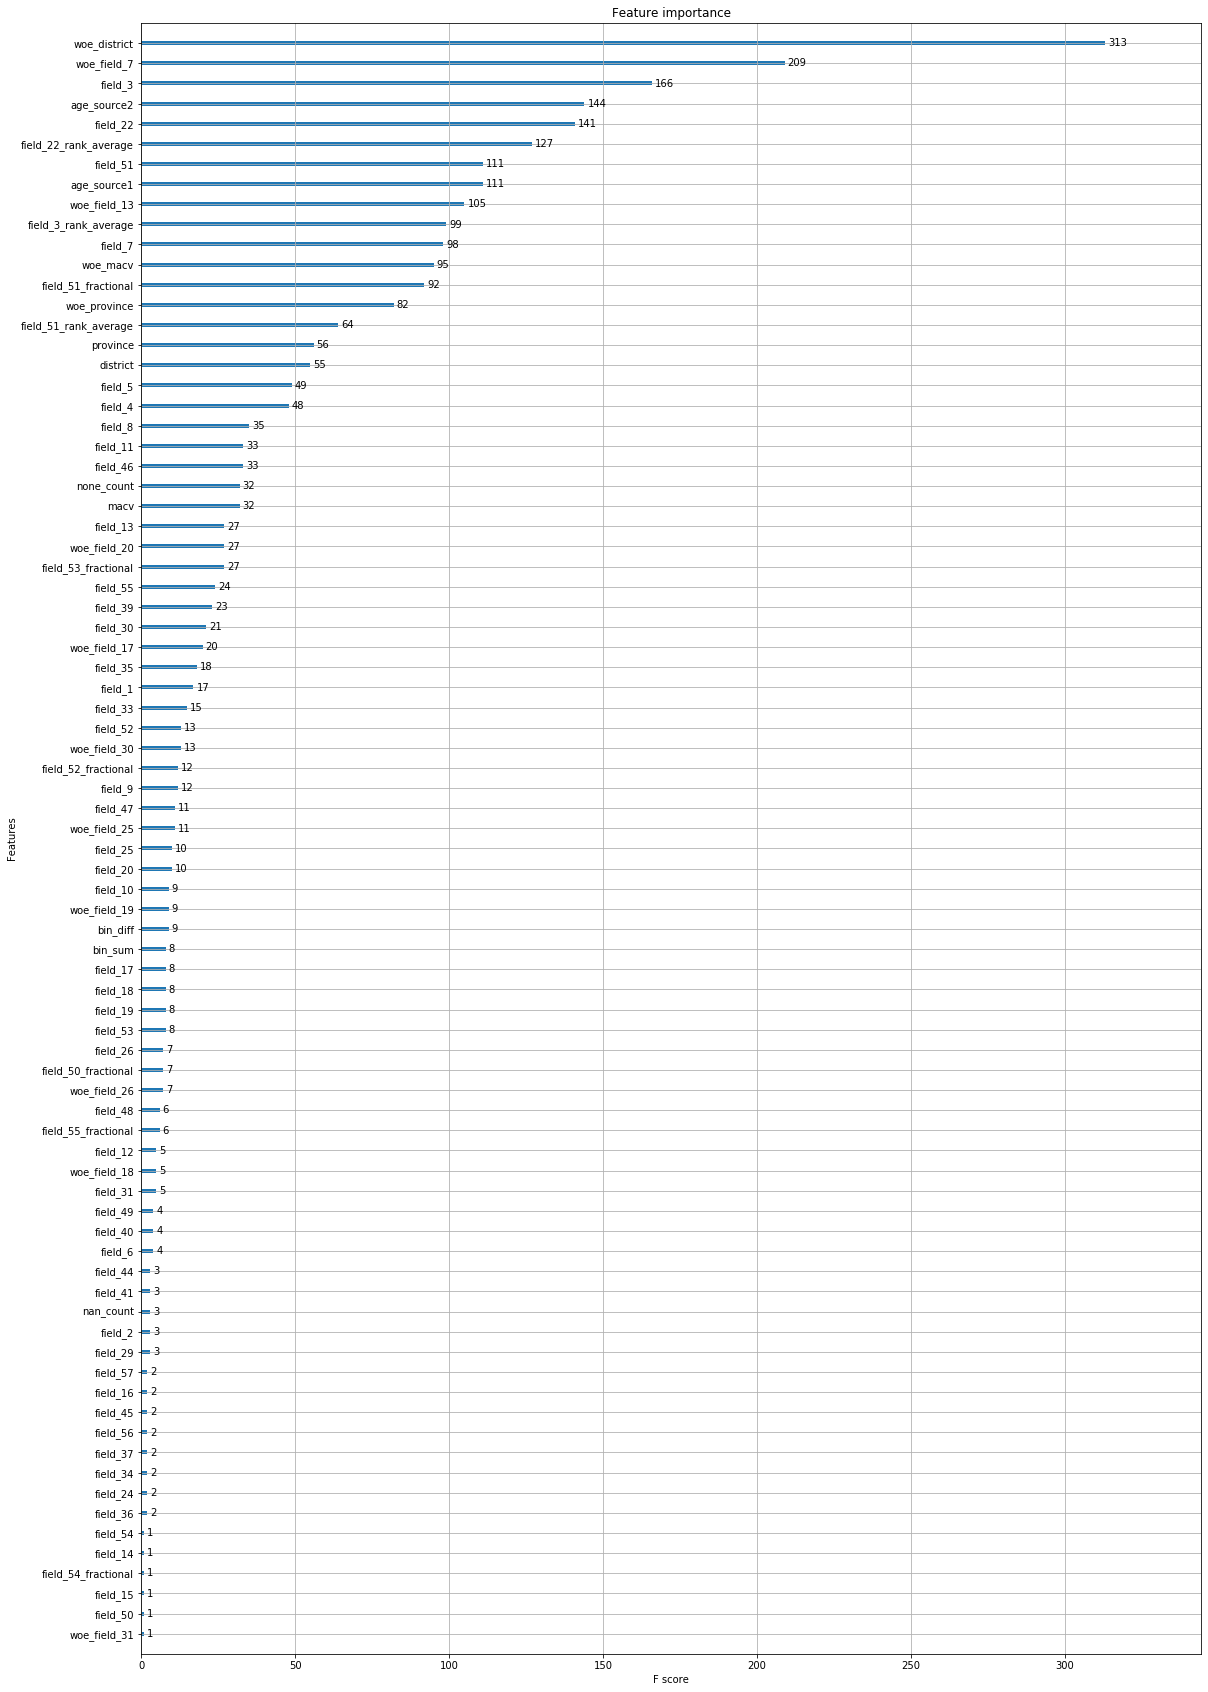

In [112]:
plt.rcParams["figure.figsize"] = (19, 30)
plot_importance(booster=clf)

## Baseline #2

In [123]:
train_df_new = train_df.copy()
train_df_new["field_7"] = train_df_new["field_7"].fillna("[]").apply(lambda x: eval(x))
train_df_new["field_7_elem_count"] = train_df_new["field_7"].apply(lambda x: len(x))
train_df_new["field_71"] = [",".join(map(str, l)) for l in train_df_new["field_7"]]

In [64]:
%%time
train_df_new = train_df.copy()
roman_conversion = {"I": 1, "II": 2, "III": 3, "IV": 4, "V": 5}
cat_cols = [
    "province",
    "district",
    "macv",
    "field_7",
    "field_8",
    "field_9",
    "field_10",
    "field_12",
    "field_13",
    "field_17",
    "field_24",
    "field_35",
    "field_39",
    "field_40",
    "field_42",
    "field_43",
    "field_44",
]

ind_cols = [
    "field_1",
    "field_4",
    "field_5",
    "field_6",
    "field_11",
    "field_14",
    "field_15",
    "field_16",
    "field_21",
    "field_32",
    "field_33",
    "field_34",
    "field_41",
    "field_45",
    "field_46",
]

bin_cols = [
    "field_2",
    "field_18",
    "field_19",
    "field_20",
    "field_23",
    "field_25",
    "field_26",
    "field_27",
    "field_28",
    "field_29",
    "field_30",
    "field_31",
    "field_36",
    "field_37",
    "field_38",
    "field_47",
    "field_48",
    "field_49",
]

num_cols = [
    "age_source1",
    "field_3",
    "field_22",
    "field_53",
    "field_54",
    "field_55",
    "age_source2",
    "field_50",
    "field_51",
    "field_52",
    "field_56",
    "field_57",
]
features = cat_cols + ind_cols + bin_cols + num_cols
assert set(train_df_new.columns) - set(features) == {"id", "label"}

# Fix typo
train_df_new = handle_category_typo(train_df_new)

# Fix age
train_df_new["age_source"] = np.where(
    train_df_new["age_source2"] == train_df_new["age_source1"],
    train_df_new["age_source1"],
    np.nan,
)
num_cols.append('age_source')

# Fix some fields
train_df_new.loc[train_df_new["field_3"] == -1, "field_3"] = np.nan
train_df_new.loc[
    train_df_new["field_9"].isin(["na", "79", "75", "80", "86"]), "field_9"
] = np.nan
train_df_new["field_7"] = train_df_new["field_7"].fillna("[]").apply(lambda x: eval(x))
train_df_new["field_7_elem_count"] = train_df_new["field_7"].apply(lambda x: len(x))
f7_uniques = pd.DataFrame(train_df_new.field_7.tolist()).stack().unique()
for c in f7_uniques:
    train_df_new[f"field_7_has_{c}"] = train_df_new.field_7.apply(lambda x: c in x)
    train_df_new[f"field_7_count_{c}"] = train_df_new.field_7.apply(lambda x: x.count(c))
train_df_new["field_7"] = [",".join(map(str, l)) for l in train_df_new["field_7"]]


# New features: Counts of NaNs and Nones
train_df_new["nan_count"] = train_df_new.isna().sum(axis=1).astype(float)
train_df_new["none_count"] = (train_df_new == "None").sum(axis=1).astype(float)
train_df_new["cat_nan_count"] = train_df_new[cat_cols+ind_cols].isna().sum(axis=1).astype(float)
train_df_new["bin_nan_count"] = train_df_new[bin_cols].isna().sum(axis=1).astype(float)
train_df_new["num_nan_count"] = train_df_new[num_cols].isna().sum(axis=1).astype(float)
train_df_new["cat_none_count"] = (train_df_new[cat_cols+ind_cols] == 'None').sum(axis=1).astype(float)
train_df_new["bin_none_count"] = (train_df_new[bin_cols] == 'None').sum(axis=1).astype(float)
train_df_new["num_none_count"] = (train_df_new[num_cols] == 'None').sum(axis=1).astype(float)

# Handling binary cols
new_bin_cols = []
for c in bin_cols:
    train_df_new[f"{c}_is_null"] = train_df_new[c].isnull()
    train_df_new.loc[train_df_new[c] == 'None', c] = -1
    train_df_new[c] = train_df_new[c].astype("bool")
    train_df_new[c] = train_df_new[c].fillna(-999)
#     if (train_df_new[c] == "None").any().sum() > 0:
#         cat_cols.append(c)
#     elif train_df_new[c].isna().sum() > 0:
#         if train_df_new[c].isna().mean() < 0.1:
#             train_df_new[c] = train_df_new[c].fillna(train_df_new[c].mode()[0])
#             new_bin_cols.append(c)
#             train_df_new[c] = train_df_new[c].astype("bool")
#         else:
#             train_df_new[c] = train_df_new[c].fillna("undefined")
#             cat_cols.append(c)
#     else:
#         new_bin_cols.append(c)
#         train_df_new[c] = train_df_new[c].astype("bool")

# Handling cat cols
for c in cat_cols:
    train_df_new[f"{c}_is_null"] = train_df_new[c].isnull()
    if train_df_new[c].isna().mean() > 0:  # Fill with unedfined
        train_df_new[c] = train_df_new[c].fillna("undefined")
# train_df_new['district_macv'] = train_df_new['district'].astype('str') + train_df_new['macv'].astype('str')
# train_df_new['province_macv'] = train_df_new['province'].astype('str') + train_df_new['macv'].astype('str')
train_df_new['province_district'] = train_df_new['province'].astype('str') + train_df_new['district'].astype('str')
# train_df_new['province_district_macv'] = train_df_new['province'].astype('str') + train_df_new['district'].astype('str') + train_df_new['macv'].astype('str')
# sys.exit()
# Handling ind cols
train_df_new["field_41"].replace(roman_conversion, inplace=True)
for c in ind_cols:
    train_df_new[f"{c}_is_null"] = train_df_new[c].isnull()
    train_df_new.loc[train_df_new[c] == "None", c] = -999
    if train_df_new[c].isna().mean() < 0.1:  # Fill with mode
        train_df_new[c] = train_df_new[c].fillna(train_df_new[c].mode()[0])
    else:  # replace with -1
        train_df_new[c] = train_df_new[c].fillna(-1)
    train_df_new[c] = train_df_new[c].astype(int)

# New features Category Count feature
# train_df_new, cat_count_cols = cat_count_features(train_df_new, cat_cols + ind_cols)

# # check if this value is unique in a column
# u_cols = []
# for c in num_cols + bin_cols + ind_cols:
#     unique_v = train_df_new[c].value_counts()
#     unique_v = unique_v.index[unique_v == 1]
#     train_df_new[f"{c}_u"] = train_df_new[c].isin(unique_v)
#     u_cols.append(f"{c}_u")
    
# # Check if there is any 'unique' values in each row
# train_df_new['has_unique'] = train_df_new[u_cols].any(axis=1)


# Categories with less than or eq 10 unique values
# cat_cols_less10 = [c for c in cat_cols if train_df_new[c].nunique() < 10]
# print(cat_cols_less10)

# One-hot encoded cols
# train_df_new = pd.get_dummies(train_df_new, columns=cat_cols_less10, drop_first=False)

# Label encoding
for c in cat_cols + ['province_district']:
    le = LabelEncoder()
    le.fit(train_df_new[c].astype(str))
    train_df_new[c] = le.transform(train_df_new[c].astype(str))
    
# Is null features for numeric cols
# for c in num_cols:
#     train_df_new[f"{c}_is_null"] = train_df_new[c].isnull()

# New feature: Sum of binary
train_df_new["bin_sum"] = train_df_new[new_bin_cols].sum(axis=1)
features.append("bin_sum")
num_cols.append("bin_sum")

# New features: Differences measure for binary feature
# Reference row for binary features
# bin_ref = train_df_new[new_bin_cols].copy()
# bin_ref_med = bin_ref.median(axis=0).to_frame().T
# bin_ref_med = pd.DataFrame(
#     bin_ref_med.values.repeat(train_df_new.shape[0], axis=0),
#     columns=bin_ref_med.columns,
# )
# # Calculate the difference
# train_df_new["bin_diff"] = (
#     train_df_new[new_bin_cols].subtract(bin_ref_med).abs().sum(axis=1)
# )
# features.append("bin_diff")
# num_cols.append("bin_diff")

# Ranking cols
# train_df_new, rank_cols = rank_features(
#     train_df_new, ["field_22", "field_51", "field_3"]
# )
# Fractional cols
train_df_new, fractional_cols = fractional_features(
    train_df_new,
    ["field_51"],
)
num_cols.extend(fractional_cols)

group_cols = ["district", "field_9", "province", 'field_3']
agg_cols = [
#     "field_3",
    "age_source2",
    "field_22",
    "field_50",
    "field_51",
#     "field_52",
#     "field_53",
#     "field_54",
#     "field_55",
]

# Agg features
# train_df_new, agg_ft = aggregate_features(train_df_new, group_cols, agg_cols)

# Mean of 2 age sources
train_df_new["mean_age"] = train_df_new[["age_source1", "age_source2"]].mean(axis=1)

# Interaction features
# feature_set = ["age_source1", "field_3", "field_22", "field_51"]
# train_df_new, inter_cols = interact_features(train_df_new, feature_set)


# Handling numeric cols
for c in num_cols:
#     train_df_new.loc[train_df_new[c] == "None", c] = -2
    train_df_new.loc[train_df_new[c] == "None", c] = np.nan
    if train_df_new[c].isna().mean() < 0.1:  # Fill with median
        train_df_new[c] = train_df_new[c].fillna(train_df_new[c].median())
#     else:  # replace with -1
#         train_df_new[c] = train_df_new[c].fillna(-1)
        

# train_df_new = train_df_new.drop(
#     columns=[c for c in cat_cols if c not in cat_cols_less10]
# )
# Combination of province,district and macv

CPU times: user 2.7 s, sys: 3.97 ms, total: 2.71 s
Wall time: 2.72 s


In [65]:
X, y = train_df_new.drop(columns=["id", "label"]).copy(), train_df_new["label"].copy()

In [60]:
# X["field_22_new"] = X["field_22"] // 12

In [71]:
%%time
xgb_params = {
    "n_jobs": -1,
    "colsample_bytree": 0.511182194059105,
    "min_child_weight": 5,
    "gamma": 0,
    "subsample": 0.7937217003281334,
    "max_depth": 5,
    "n_estimators": 231,
    "learning_rate": 0.044806747122933484,
}
cb_params = {
    "leaf_estimation_method": "Newton",
    'learning_rate': 0.057,
    'l2_leaf_reg': 23,
    'depth': 6,
    'od_pval': 0.0000001,
    'iterations': 887,
    'loss_function': "Logloss"
}
avg = AveragingClassifier([
    ('cb', cb.CatBoostClassifier(random_state=2020, **cb_params)),
#     ("lr", LogisticRegression(random_state=2020)),
#     ('svc', SVC(probability=True)),
#     ('et', ExtraTreesClassifier(n_jobs=-1, random_state=2020)),
    ('xgb', xgb.XGBClassifier(random_state=2020, **xgb_params))
], weights=[1,1])

estimators = [
#     ('et', ExtraTreesClassifier(n_estimators=100, max_features='auto', n_jobs=-1)),
    ("xgb", xgb.XGBClassifier(random_state=2020, **xgb_params)),
#     ("cb", cb.CatBoostClassifier(random_state=2020, **cb_params)),
    #     ('cb', cb.CatBoostClassifier()),
#     ("lr", LogisticRegression(random_state=2020)),
    #     ('Ridge', RidgeClassifier()),
#     ('lsvc', LinearSVC()),
#     ('svc', SVC(probability=True)),
    #     ('mlp', MLPClassifier(max_iter=500)),
    #     ('vote1', vote1),
    #     ('vote2', vote2)
#     ("avg", avg)
]
# Create folds
print(X.shape)
# X_scaled = MinMax().fit_transform(
#     X['field_3', 'field_19', 'field']
# )
# X['label_mean'] = 0
final_scores = {}
for _ in tqdm(range(1)): # 10 times experiment
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=2020)
    for name, clf in estimators:
        print(f"{name}:")
        scores = []
        auc_scores = []
        for i, (train_index, test_index) in enumerate(cv.split(X, y)):
            Xtrain, Xtest = (
                X.iloc[train_index].copy().reset_index(drop=True),
                X.iloc[test_index].copy().reset_index(drop=True),
            )
            ytrain, ytest = (
                y[train_index].copy().reset_index(drop=True),
                y[test_index].copy().reset_index(drop=True),
            )
            #         # Get nearest neighbours
            #         knn_ft = ["field_3", "field_19", "field_22", "field_51"]
            #         print("get neighbours...")
            #         scaler = StandardScaler()
            #         Xtr_scaled = scaler.fit_transform(
            #             fillna_numeric(Xtrain[knn_ft].astype(float), knn_ft)
            #         )
            #         Xte_scaled = scaler.fit_transform(
            #             fillna_numeric(Xtest[knn_ft].astype(float), knn_ft)
            #         )
            #         nbrs = NearestNeighbors(n_neighbors=1000, algorithm="ball_tree", n_jobs=-1).fit(
            #             Xtr_scaled[:]
            #         )
            #         # Get indices on train and test
            #         _, indices_train = nbrs.kneighbors(Xtr_scaled[:])
            #         _, indices_test = nbrs.kneighbors(Xte_scaled[:])
            #         # Calculate label mean of 500 nearest neighbours
            #         for i in tqdm(Xtrain.index.values):
            #             Xtrain.at[i, "label_mean"] = ytrain[indices_train[i]].mean()
            #         for i in tqdm(Xtest.index.values):
            #             Xtest.at[i, "label_mean"] = ytrain[indices_test[i]].mean()
            # Rank features
#             print("Rank features...")
#             Xtrain, _ = rank_features(
#                 Xtrain, ["field_22", "field_51", "field_3"]
#             )
#             Xtest, _ = rank_features(
#                 Xtest, ["field_22", "field_51", "field_3"]
#             )
            # Mean encoding
            print("Mean encoding...")
            mean_ft = ['field_3', 'field_22', 'field_9', 'field_19', 'macv', 'province_district', 'field_1', 'field_6']
            Xtrain, Xtest = mean_encoding(Xtrain, ytrain, Xtest, mean_ft)
            # Get nearest neighbours
            knn_ft = [f"{c}_mean_target" for c in mean_ft]
#             print("get neighbours...")
#             scaler = StandardScaler()
#             Xtr_scaled = scaler.fit_transform(
#                 fillna_numeric(Xtrain[knn_ft].astype(float), knn_ft)
#             )
#             Xte_scaled = scaler.fit_transform(
#                 fillna_numeric(Xtest[knn_ft].astype(float), knn_ft)
#             )
#             nbrs = NearestNeighbors(n_neighbors=1000, algorithm="ball_tree", n_jobs=-1).fit(
#                 Xtr_scaled[:]
#             )
#             # Get indices on train and test
#             _, indices_train = nbrs.kneighbors(Xtr_scaled[:])
#             _, indices_test = nbrs.kneighbors(Xte_scaled[:])
#             # Calculate label mean of 500 nearest neighbours
#             for i in tqdm_notebook(Xtrain.index.values):
#                 Xtrain.at[i, "label_mean"] = ytrain[indices_train[i]].mean()
#             for i in tqdm_notebook(Xtest.index.values):
#                 Xtest.at[i, "label_mean"] = ytrain[indices_test[i]].mean()
            print("Modelling...")
            if name != "xgb" and name != "cb":  # then scale
                scaled_ft = StandardScaler().fit_transform(Xtrain[num_cols])
                test_scaled_ft = StandardScaler().fit_transform(Xtest[num_cols])
                Xtrain[num_cols], Xtest[num_cols] = scaled_ft, test_scaled_ft
            if name == "cb":
#                 clf.fit(Xtrain, ytrain, silent=True)
#                 sorted_idx = np.argsort(clf.feature_importances_)[::-1]
#                 selected_features = pd.DataFrame(
#                     np.array([Xtrain.columns[sorted_idx], clf.feature_importances_[sorted_idx]]).T,
#                     columns=["feature", "importance"],
#                 ).query("importance>=0.01").feature.tolist()
                selected_features = Xtrain.columns.tolist()
                print(len(selected_features))
                clf.fit(
                    Xtrain[selected_features],
                    ytrain,
                    silent=True,
                    eval_set=(Xtest[selected_features], ytest),
                    early_stopping_rounds=100,
                )
            elif name == "xgb":
#                 clf.fit(Xtrain, ytrain, verbose=False)
#                 sorted_idx = np.argsort(clf.feature_importances_)[::-1]
#                 print(sorted_idx.shape)
#                 selected_features = pd.DataFrame(
#                     np.array([Xtrain.columns[sorted_idx], clf.feature_importances_[sorted_idx]]).T,
#                     columns=["feature", "importance"],
#                 ).query("importance>=0.01").feature.tolist()
                selected_features = Xtrain.columns.tolist()
                print(len(selected_features))
                clf.fit(
                    Xtrain[selected_features],
                    ytrain,
                    verbose=False,
                    eval_set=[(Xtrain[selected_features], ytrain), (Xtest[selected_features], ytest)],
                    eval_metric=gini_xgb,
                    early_stopping_rounds=100,
                )
                # print(f"Best ntree {clf.get_booster().best_ntree_limit}")
            else:
                clf.fit(Xtrain, ytrain)
            ypred = clf.predict_proba(Xtest[selected_features])[:, 1].round(6)
            # print(ypred)
            score = gini(ytest, ypred)
            auc = roc_auc_score(ytest, ypred)
            max_score = gini(ytest, ytest)
            print(f"\tScore: {score} | max score: {max_score} | AUC: {auc}")
            scores.append(score)
            auc_scores.append(auc)
        print(f"\tMean score: {np.mean(scores)} | Mean AUC: {np.mean(auc_scores)}")
    #     print(f" Gini: {score['test_skgini'].mean()}")
    #     print(f" ROC: {score['test_roc_auc'].mean()}")
        if name in final_scores:
            final_scores[name].append(np.mean(scores))
        else:
            final_scores[name] = [np.mean(scores)]

(30000, 200)





  0%|          | 0/1 [00:00<?, ?it/s]

xgb:
Mean encoding...
Modelling...
209
	Score: 0.14856615120274919 | max score: 0.49191666666666667 | AUC: 0.6516675951944756
Mean encoding...
Modelling...
209
	Score: 0.16532731958762883 | max score: 0.49191666666666667 | AUC: 0.6686037677853827
Mean encoding...
Modelling...
209
	Score: 0.12974828178694156 | max score: 0.49191666666666667 | AUC: 0.630705861601038
Mean encoding...
Modelling...
209
	Score: 0.08819845360824745 | max score: 0.49191666666666667 | AUC: 0.589289737351792
Mean encoding...
Modelling...
209
	Score: 0.12229931972789117 | max score: 0.49183333333333334 | AUC: 0.6241113354864142
	Mean score: 0.13082790518269163 | Mean AUC: 0.6328756594838205





100%|██████████| 1/1 [02:26<00:00, 146.43s/it]


CPU times: user 2min 24s, sys: 771 ms, total: 2min 25s
Wall time: 2min 26s


In [56]:
X, _ = mean_encoding(
    X,
    y,
    X,
    [
        "field_3",
        "field_22",
        #         "field_7",
        "field_19",
        "field_9",
        "macv",
        "province_district",
    ],
)
clf = xgb.XGBClassifier()
clf.fit(X, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [62]:
cat_cols

['province',
 'district',
 'macv',
 'field_7',
 'field_8',
 'field_9',
 'field_10',
 'field_12',
 'field_13',
 'field_17',
 'field_24',
 'field_35',
 'field_39',
 'field_40',
 'field_42',
 'field_43',
 'field_44']

In [63]:
ind_cols

['field_1',
 'field_4',
 'field_5',
 'field_6',
 'field_11',
 'field_14',
 'field_15',
 'field_16',
 'field_21',
 'field_32',
 'field_33',
 'field_34',
 'field_41',
 'field_45',
 'field_46']

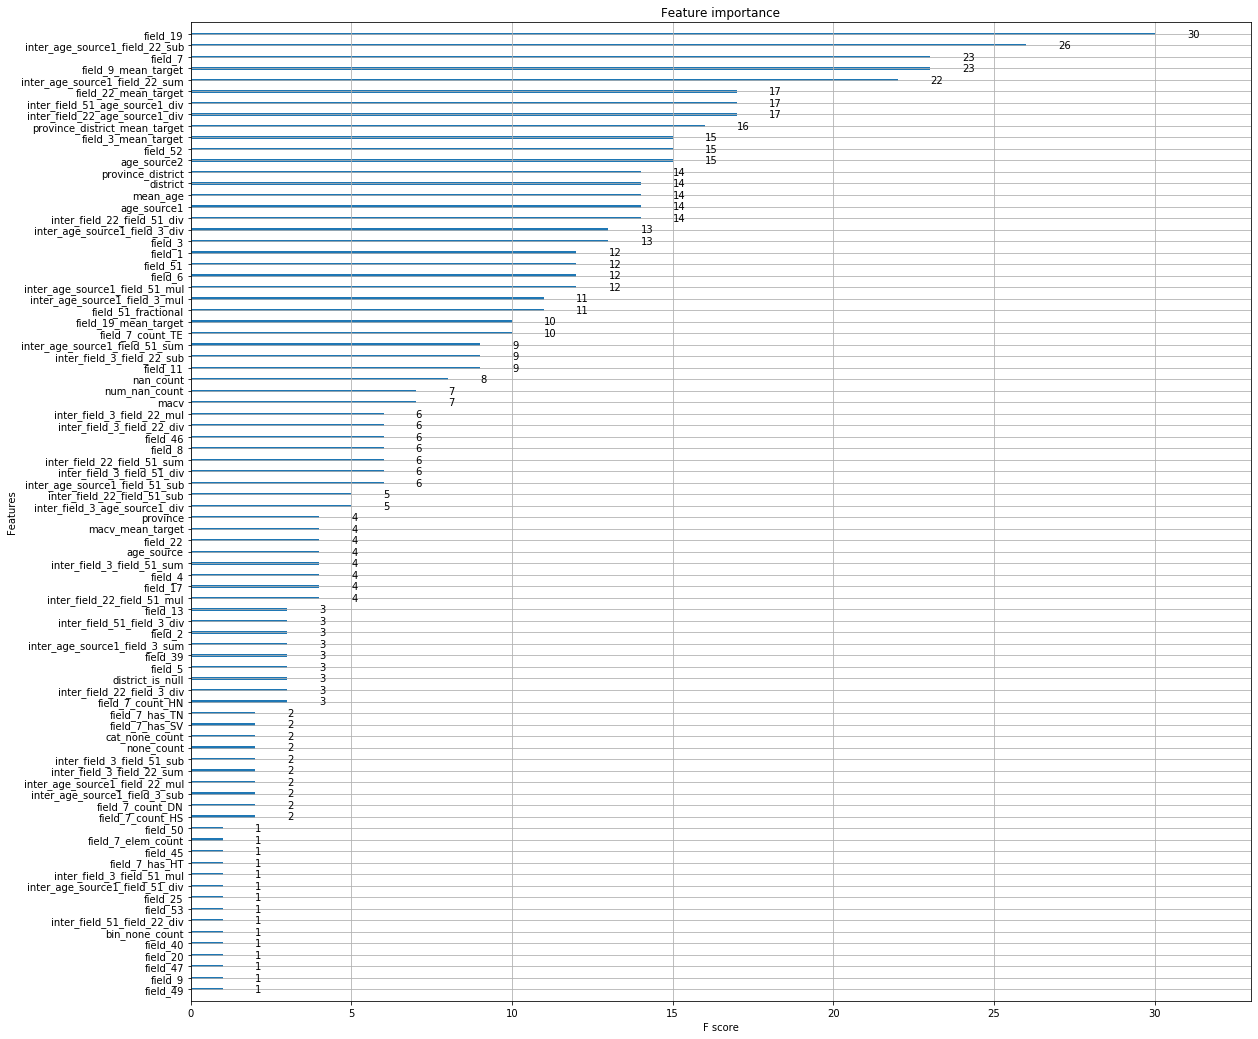

In [57]:
plt.rcParams["figure.figsize"] = (19, 18)
plot_importance(booster=clf)

## Job title clustering

In [135]:
train_df_new = train_df.copy()
train_df_new = handle_category_typo(train_df_new, cols=["macv"])
train_df_new["macv"] = train_df_new["macv"].fillna("none")

In [136]:
%%time
train_df_new['macv_tokenised'] = train_df_new['macv'].apply(lambda x: word_tokenize(x, format='text'))

CPU times: user 4.11 s, sys: 982 µs, total: 4.11 s
Wall time: 4.13 s


In [137]:
train_df_new[["macv", "macv_tokenised"]].sample(10)

,macv,macv_tokenised
18514,none,none
12964,none,none
13774,lắp ráp,lắp_ráp
17437,none,none
9785,none,none
361,công nhân ép đế,công_nhân ép đế
17937,kế toán,kế_toán
11272,none,none
3023,none,none
613,none,none


In [138]:
%%time
tf = TfidfVectorizer(min_df=5,max_df= 0.95,max_features=1000,sublinear_tf=True)
tf.fit(train_df_new['macv_tokenised'])
X = tf.transform(train_df_new['macv_tokenised'])

CPU times: user 365 ms, sys: 991 µs, total: 366 ms
Wall time: 370 ms


Fit 2 clusters
Fit 4 clusters
Fit 6 clusters
Fit 8 clusters
Fit 10 clusters
Fit 12 clusters
Fit 14 clusters
Fit 16 clusters
Fit 18 clusters
Fit 20 clusters
CPU times: user 496 ms, sys: 53 ms, total: 549 ms
Wall time: 38.7 s


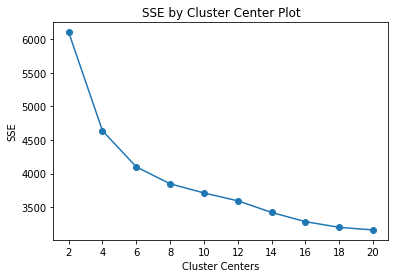

In [123]:
%%time
find_optimal_clusters(X, 20)

In [86]:
clusters = KMeans(
    n_clusters=6, init="k-means++", n_jobs=-1, random_state=2020
).fit_predict(X)

In [140]:
clusters = AgglomerativeClustering(n_clusters=6).fit_predict(X.toarray())

In [141]:
train_df_new["cluster"] = clusters

In [145]:
train_df_new[["macv", "cluster"]].sample(10)

,macv,cluster
8724,none,1
9158,none,1
23475,none,1
23124,none,1
10154,none,1
20207,none,1
17476,none,1
2749,none,1
9668,công nhân,5
29793,tài xế,0


In [146]:
train_df_new.groupby("cluster").agg({"macv": lambda x: x.values[:3].tolist()})

,macv
cluster,
0,"[2983, cấp dưỡng, nhân viên bảo trì]"
1,"[none, none, none]"
2,"[công nhân may công nghiệp, công nhân may công..."
3,"[nhân viên, nhân viên, nhân viên]"
4,"[giáo viên, giáo viên, giáo viên]"
5,"[công nhân, công nhân, công nhân]"


In [147]:
def get_top_keywords(data, clusters, labels, n_terms):
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()

    for i, r in df.iterrows():
        print("\nCluster {}".format(i))
        print(",".join([labels[t] for t in np.argsort(r)[-n_terms:]]))


get_top_keywords(X, clusters, tf.get_feature_names(), 10)


Cluster 0
máy_may,bán,may,hàng,kỹ_thuật,vận_hành,cn,sản_xuất,nhân_viên,công_nhân

Cluster 1
kd,kcs,in,ii,hợp_đồng,hội,hộ_sinh,hỗ_trợ,ủi,none

Cluster 2
ii,hợp_đồng,hội,khối,lắp_ráp,kiểm_hóa,cn,công_nghiệp,công_nhân,may

Cluster 3
kd,kcs,in,ii,hợp_đồng,hội,hộ_sinh,kho,ủi,nhân_viên

Cluster 4
kd,kcs,in,ii,hợp_đồng,hội,hộ_sinh,kho,ủi,giáo_viên

Cluster 5
kd,kcs,in,ii,hợp_đồng,hội,hộ_sinh,giới_thiệu,ủi,công_nhân


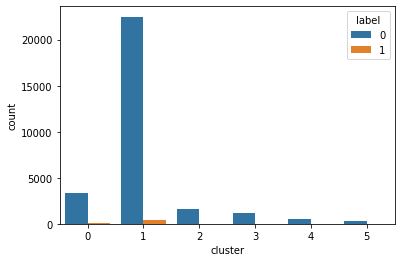

In [126]:
sns.countplot(x="cluster", hue="label", data=train_df_new)

In [127]:
train_df_new.groupby("cluster").label.agg(["sum", "mean"])

,sum,mean
cluster,,
0,47,0.013955
1,390,0.017044
2,25,0.014952
3,14,0.011299
4,7,0.013972
5,3,0.008876
